In [1]:
import numpy as np
import pandas as pd
import h5py
import os
import glob
from datetime import datetime
from datetime import timedelta
from matplotlib import pyplot as plt
import matplotlib.dates as md
import warnings
from scipy.interpolate import interp2d
from scipy.interpolate import interp1d
from scipy.interpolate import make_interp_spline
warnings.filterwarnings('ignore')
import scipy.ndimage as ndimage
from matplotlib import cm
from matplotlib.colors import LogNorm
import matplotlib.ticker as ticker
from sklearn import preprocessing
import seaborn as sns
from scipy.stats import pearsonr
from scipy import stats

In [2]:
def simple_read(path):
    with open(path) as f:
        first_line = f.readline()
        header_line = int(first_line[0:-2].split(",")[0])-1
        #all_lines = f.readlines()
    data = pd.read_csv(path, sep=',', skiprows=header_line)
    data.columns = [i.strip() for i in data.columns]
    #date = all_lines[5][0:10].split(',')
    #dt = datetime(int(date[0]), int(date[1]), int(date[2]))

    acc = 0
    boo = False
    for letter in path:
        if letter == '2':
            boo = True
        elif boo and letter == '0':
            acc -= 1
            break
        acc += 1
    #print(path[:acc+4], path[acc+4:acc+6], path[acc+6:acc+8])
    dt = datetime(int(path[acc:acc+4]), int(path[acc+4:acc+6]), int(path[acc+6:acc+8]))
    
    for column in data.keys():
        if 'Time' in column:
            data[column] = dt + pd.to_timedelta(data[column], unit='seconds')
    return data.replace(-999999, np.NaN)

In [3]:
'''DAY2 = simple_read('C:/Users/taiwoajayi/Documents/Intvol/activate-mrg1_hu25_20220602_R0_L1_20230625T113221.ict')

start_index = np.where(DAY2["Time_Start"] == pd.to_datetime("2022-06-02 13:48:00"))
stop_index = np.where(DAY2["Time_Start"] == pd.to_datetime("2022-06-02 14:10:00"))

DAY2_subset = DAY2[start_index[0][0]:stop_index[0][0]]

start_col2 = 'CNgt3nm_ZIEMBA'

DAY22_subset = DAY2_subset.copy()
DAY22_subset.loc[:, start_col2:] *= 1e-6
DAY22_subset.replace(-888888, np.NaN, inplace=True)

# Print the modified subset dataframe
print(DAY22_subset)'''


'DAY2 = simple_read(\'C:/Users/taiwoajayi/Documents/Intvol/activate-mrg1_hu25_20220602_R0_L1_20230625T113221.ict\')\n\nstart_index = np.where(DAY2["Time_Start"] == pd.to_datetime("2022-06-02 13:48:00"))\nstop_index = np.where(DAY2["Time_Start"] == pd.to_datetime("2022-06-02 14:10:00"))\n\nDAY2_subset = DAY2[start_index[0][0]:stop_index[0][0]]\n\nstart_col2 = \'CNgt3nm_ZIEMBA\'\n\nDAY22_subset = DAY2_subset.copy()\nDAY22_subset.loc[:, start_col2:] *= 1e-6\nDAY22_subset.replace(-888888, np.NaN, inplace=True)\n\n# Print the modified subset dataframe\nprint(DAY22_subset)'

In [4]:
DAY2 = simple_read('C:/Users/taiwoajayi/Documents/Intvol/activate-mrg1_hu25_20220602_R0_L1_20230625T113221.ict')

start_index = np.where(DAY2["Time_Start"] == pd.to_datetime("2022-06-02 13:48:00"))
stop_index = np.where(DAY2["Time_Start"] == pd.to_datetime("2022-06-02 14:10:00"))

DAY2_subset = DAY2[start_index[0][0]:stop_index[0][0]]

# Print the modified subset dataframe
DAY2_subset


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
8926,2022-06-02 13:48:00,2022-06-02 13:48:01,32.397719,-65.920473,1896.68,476.375,351.620,161.290,109.395,11.555,0.410,0.00,0.00,0.00,NaN,NaN,NaN
8927,2022-06-02 13:48:01,2022-06-02 13:48:02,32.397400,-65.918900,1897.28,450.215,344.275,159.470,98.900,11.855,0.515,0.00,0.00,0.00,NaN,NaN,NaN
8928,2022-06-02 13:48:02,2022-06-02 13:48:03,32.397079,-65.917327,1898.01,457.285,346.865,155.815,90.705,10.505,0.460,0.65,2.04,0.34,NaN,NaN,NaN
8929,2022-06-02 13:48:03,2022-06-02 13:48:04,32.396758,-65.915754,1898.83,460.935,348.770,160.780,94.045,10.440,0.445,1.30,4.08,0.68,NaN,NaN,NaN
8930,2022-06-02 13:48:04,2022-06-02 13:48:05,32.396435,-65.914182,1899.75,456.205,348.780,159.545,85.935,11.370,0.585,1.17,8.54,2.50,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10241,2022-06-02 14:09:55,2022-06-02 14:09:56,32.272869,-64.969777,2855.32,644.105,476.070,332.540,138.440,15.425,0.705,0.00,0.00,0.00,NaN,NaN,NaN
10242,2022-06-02 14:09:56,2022-06-02 14:09:57,32.273564,-64.970808,2861.28,678.270,483.345,336.920,148.955,17.415,0.885,0.00,0.00,0.00,NaN,NaN,NaN
10243,2022-06-02 14:09:57,2022-06-02 14:09:58,32.274234,-64.971861,2867.15,699.820,489.220,339.900,144.315,16.245,0.820,0.00,0.00,0.00,NaN,NaN,NaN
10244,2022-06-02 14:09:58,2022-06-02 14:09:59,32.274877,-64.972937,2872.99,715.035,493.775,342.940,145.035,14.960,0.645,0.00,0.00,0.00,NaN,NaN,NaN


In [5]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY2_subset.GPS_Altitude_THORNHILL.min(), DAY2_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY2_subset['Bins'] = pd.cut(DAY2_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY2_subset_1000 = DAY2_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY2_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY2_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_1000 = DAY2_subset_1000[start_index:stop_index]
DAY1000_subset_1000


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
Bins,,,,,,,,,,,,,,,,,
"(106.28, 134.006]",2022-06-02 13:58:08.316455680,2022-06-02 13:58:09.316455680,32.208589,-65.046984,121.847785,422.641329,334.360253,203.976519,215.946582,29.711899,1.370316,0.999747,8.525823,2.937468,185.400000,1.577500,0.020000
"(134.006, 161.732]",2022-06-02 13:58:10.600000000,2022-06-02 13:58:11.600000000,32.212691,-65.043093,148.533600,431.214200,331.396600,203.122400,207.666800,27.918400,1.250000,0.747800,7.103000,2.438400,176.490000,1.495000,0.020000
"(161.732, 189.459]",2022-06-02 13:58:12.588235264,2022-06-02 13:58:13.588235264,32.218407,-65.041818,174.502647,431.892941,332.469706,201.581765,195.820588,27.147941,1.267059,0.731765,8.181765,2.933235,163.172727,1.380000,0.017273
"(189.459, 217.185]",2022-06-02 13:58:03.454545664,2022-06-02 13:58:04.454545408,32.224814,-65.054117,203.336364,426.890455,331.552727,205.023636,205.843182,28.850455,1.354545,0.824091,3.790000,0.849091,148.008333,1.256667,0.011667
"(217.185, 244.911]",2022-06-02 13:57:54.700000000,2022-06-02 13:57:55.700000000,32.229233,-65.065482,231.925500,427.325500,331.951500,204.828500,213.276000,29.531000,1.421000,0.506000,3.092000,0.803500,143.500000,1.220000,0.010000
"(244.911, 272.637]",2022-06-02 13:58:08.000000000,2022-06-02 13:58:09.000000256,32.231133,-65.053264,259.895833,433.793750,332.220833,201.451250,216.467917,29.630417,1.351250,0.658333,4.067083,1.042500,155.550000,1.315000,0.012500
"(272.637, 300.363]",2022-06-02 13:58:30.894736896,2022-06-02 13:58:31.894736896,32.235800,-65.035237,283.662895,430.406316,332.927368,203.442895,197.058947,26.538421,1.167105,0.928684,6.825263,2.274211,161.257895,1.360000,0.013684
"(300.363, 328.09]",2022-06-02 13:57:43.642857216,2022-06-02 13:57:44.642857216,32.243336,-65.088576,313.085357,422.281429,331.919643,204.777857,201.551071,26.391429,1.128571,0.854643,6.650000,2.159643,174.485714,1.464286,0.016429
"(328.09, 355.816]",2022-06-02 13:57:48.700000000,2022-06-02 13:57:49.700000000,32.246542,-65.087461,340.071000,426.105000,333.599500,203.584000,193.572500,26.184000,1.178000,1.062000,8.956000,3.054500,172.420000,1.448000,0.016000


In [6]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY2_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY2_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3000_subset_3000 = DAY2_subset_1000[start_index:stop_index]
DAY3000_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
Bins,,,,,,,,,,,,,,,,,
"(993.518, 1021.245]",2022-06-02 13:58:28.875000064,2022-06-02 13:58:29.875000064,32.265496,-65.181578,1005.609375,434.131875,339.216250,197.493750,191.098125,25.703125,1.219375,0.552500,5.855000,1.971875,237.080000,1.720000,0.02
"(1021.245, 1048.971]",2022-06-02 13:58:30.875000064,2022-06-02 13:58:31.875000064,32.267893,-65.180104,1036.225000,439.006875,335.775000,198.064375,186.927500,23.640000,0.975625,0.583750,4.612500,1.516250,237.080000,1.720000,0.02
"(1048.971, 1076.697]",2022-06-02 14:00:25.300000000,2022-06-02 14:00:26.300000000,32.256697,-65.074768,1061.471000,437.740500,333.528000,199.179000,174.537500,22.929000,1.021500,0.753000,10.822000,4.376500,237.080000,1.720000,0.02
"(1076.697, 1104.423]",2022-06-02 13:58:37.124999936,2022-06-02 13:58:38.124999936,32.275372,-65.176683,1089.870000,437.448750,342.318125,197.392500,176.749375,23.615000,1.124375,0.258750,2.641875,0.809375,237.080000,1.720000,0.02
"(1104.423, 1132.149]",2022-06-02 13:59:06.666666752,2022-06-02 13:59:07.666666496,32.276005,-65.151618,1119.245556,454.620556,342.410000,192.491667,161.687778,20.208889,0.883333,0.563333,5.006111,1.552778,257.213333,1.743333,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(2712.543, 2740.269]",2022-06-02 14:09:22.000000000,2022-06-02 14:09:23.000000000,32.239794,-64.957288,2728.482727,608.608182,422.585000,286.281818,153.325455,16.380000,0.664091,0.212727,3.342727,1.628182,260.720000,2.470000,0.03
"(2740.269, 2767.995]",2022-06-02 14:09:30.500000000,2022-06-02 14:09:31.500000000,32.249103,-64.955685,2752.315000,591.790833,419.686667,274.777500,148.849167,16.050000,0.685833,0.367500,3.183333,0.955000,260.720000,2.470000,0.03
"(2767.995, 2795.721]",2022-06-02 14:09:38.000000000,2022-06-02 14:09:39.000000000,32.257308,-64.957425,2783.561111,624.484444,423.714444,285.934444,140.442222,14.546111,0.585000,0.245000,1.591111,0.397778,260.720000,2.470000,0.03


In [7]:
nbins = 15
bins = np.linspace(DAY2_subset.GPS_Altitude_THORNHILL.min(), DAY2_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY2_subset['Bins'] = pd.cut(DAY2_subset['GPS_Altitude_THORNHILL'], bins)
DAY2_subset_mean = DAY2_subset.groupby('Bins').mean()
DAY2_subset_mean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
Bins,,,,,,,,,,,,,,,,,
"(106.28, 291.121]",2022-06-02 13:58:10.426035456,2022-06-02 13:58:11.426035456,32.216377,-65.046278,166.815237,426.736716,333.117811,203.549172,210.267574,28.853757,1.326864,0.861657,7.089290,2.378225,174.066855,1.477419,0.017742
"(291.121, 475.963]",2022-06-02 13:55:33.333333248,2022-06-02 13:55:34.333333248,32.272029,-65.247586,425.881979,431.568812,338.858625,211.442146,215.712979,29.126146,1.308062,0.721625,5.856187,1.890750,182.706304,1.580380,0.016957
"(475.963, 660.804]",2022-06-02 13:57:56.255101952,2022-06-02 13:57:57.255102208,32.283749,-65.167032,552.505663,453.522602,347.536582,216.002653,216.450765,28.969082,1.272602,0.794286,6.315765,2.141122,135.644375,1.290000,0.012031
"(660.804, 845.645]",2022-06-02 13:58:46.277777920,2022-06-02 13:58:47.277777920,32.260697,-65.168642,747.877361,439.589306,335.000833,202.460000,206.702222,27.438125,1.207986,0.681250,5.609583,1.882917,180.813433,1.705075,0.020000
"(845.645, 1030.487]",2022-06-02 13:58:15.543478272,2022-06-02 13:58:16.543478016,32.264122,-65.194026,944.842283,434.444457,333.454565,194.744674,186.837174,24.336848,1.066413,0.485326,4.153370,1.405978,218.105000,1.630714,0.020000
"(1030.487, 1215.328]",2022-06-02 13:59:34.017241600,2022-06-02 13:59:35.017241600,32.274364,-65.128831,1124.396724,443.958190,336.319397,189.874052,165.510776,21.106983,0.928276,0.492328,4.707586,1.586034,253.404324,1.738919,0.020000
"(1215.328, 1400.169]",2022-06-02 14:00:12.951612672,2022-06-02 14:00:13.951612928,32.296695,-65.140298,1306.463871,439.792419,328.097177,174.548387,151.900161,18.996613,0.819113,0.343710,3.006371,1.031129,268.302951,1.804426,0.020000
"(1400.169, 1585.011]",2022-06-02 14:00:10.982758656,2022-06-02 14:00:11.982758656,32.293985,-65.200999,1497.952931,481.088017,359.429569,198.390086,154.667845,18.919569,0.815948,0.371552,2.895345,0.863707,248.807209,2.052791,0.025581
"(1585.011, 1769.852]",2022-06-02 14:00:31.684931328,2022-06-02 14:00:32.684931584,32.268770,-65.216905,1670.366027,497.533630,368.522397,204.628014,147.720000,17.744178,0.762945,0.448493,5.129452,2.102603,258.162326,2.239535,0.028140


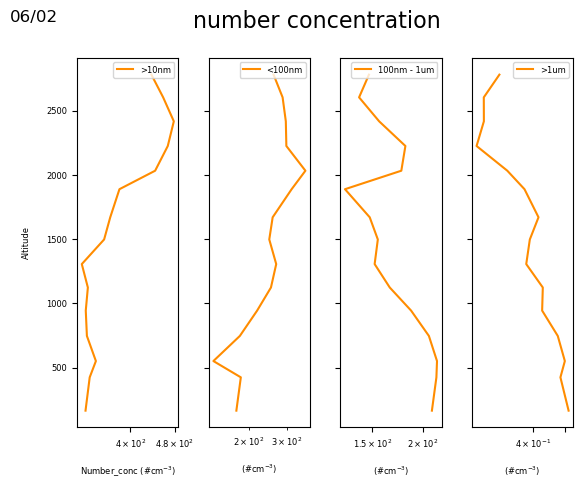

In [112]:
fig, ax = plt.subplots(1, 4, sharey='all')
plt.rcParams['font.size'] = '6'
ax[0].plot(DAY2_subset_mean['CNgt10nm_ZIEMBA'], DAY2_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label=">10nm")
ax[1].plot(DAY2_subset_mean['nSMPS_ZIEMBA'], DAY2_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label="<100nm")
ax[2].plot(DAY2_subset_mean['IntegN_100to1000nm_LAS_ZIEMBA'], DAY2_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label="100nm - 1um")
ax[3].plot(DAY2_subset_mean['IntegN_gt1000nm_LAS_ZIEMBA'], DAY2_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label='>1um')
ax[0].set_ylabel('Altitude', labelpad=11)
ax[0].set_xlabel('Number_conc (#cm$^{-3}$)', labelpad=11)
ax[1].set_xlabel('(#cm$^{-3}$)', labelpad=11)
ax[2].set_xlabel('(#cm$^{-3}$)', labelpad=11)
ax[3].set_xlabel('(#cm$^{-3}$)', labelpad=11)
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[3].set_xscale('log')
ax[0].legend(loc='upper right', fontsize=6)
ax[1].legend(loc='upper right', fontsize=6)
ax[2].legend(loc='upper right', fontsize=6)
ax[3].legend(loc='upper right', fontsize=6)

# Reduce the number of x-axis tickers to 2 for ax[0]
ax[0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=2))
ax[0].xaxis.set_minor_locator(ticker.NullLocator())

# Reduce the number of x-axis tickers to 2 for ax[2]
ax[2].xaxis.set_major_locator(ticker.MaxNLocator(nbins=2))
ax[2].xaxis.set_minor_locator(ticker.NullLocator())

# Reduce the number of x-axis tickers to 2 for ax[3]
ax[3].xaxis.set_major_locator(ticker.MaxNLocator(nbins=2))
ax[3].xaxis.set_minor_locator(ticker.NullLocator())

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)
fig.text(0.02, 0.98, '06/02', ha='left', va='top', fontsize=12)
# Set the title
fig.suptitle('number concentration', fontsize=16)

plt.show()


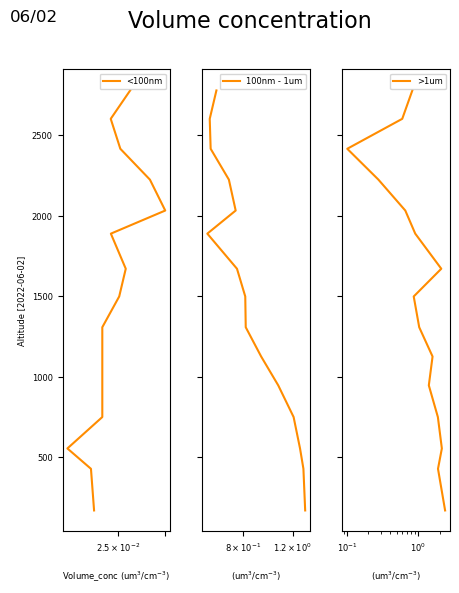

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(5, 6), sharey='all')
plt.rcParams['font.size'] = '6'
ax[0].plot(DAY2_subset_mean['vSMPS_ZIEMBA'], DAY2_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label="<100nm")
ax[1].plot(DAY2_subset_mean['IntegV_100to1000nm_LAS_ZIEMBA'], DAY2_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label='100nm - 1um')
ax[2].plot(DAY2_subset_mean['IntegV_gt1000nm_LAS_ZIEMBA'], DAY2_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label='>1um')
ax[0].set_ylabel('Altitude [2022-06-02]')
ax[0].set_xlabel('Volume_conc (um$^{3}$/cm$^{-3}$)', labelpad=11)
ax[1].set_xlabel('(um$^{3}$/cm$^{-3}$)', labelpad=11)
ax[2].set_xlabel('(um$^{3}$/cm$^{-3}$)', labelpad=11)
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[0].legend(loc='upper right', fontsize=6)
ax[1].legend(loc='upper right', fontsize=6)
ax[2].legend(loc='upper right', fontsize=6)
# Reduce the number of x-axis tickers to 2 for ax[0]
ax[0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=2))
ax[0].xaxis.set_minor_locator(ticker.NullLocator())

# Reduce the number of x-axis tickers to 2 for ax[1]
ax[1].xaxis.set_major_locator(ticker.MaxNLocator(nbins=2))
ax[1].xaxis.set_minor_locator(ticker.NullLocator())

# Limit the number of tickers for the second plot
#ax[1].set_xlim([0, 2])
#ax[2].set_xlim([100, 300])
#ax[2].set_xlim([0, 3])
# Adjust the spacing between subplots
# Set the title
fig.text(0.02, 0.98, '06/02', ha='left', va='top', fontsize=12)
fig.suptitle('Volume concentration', fontsize=16)
plt.subplots_adjust(wspace=0.3)

In [10]:
DAY2b = simple_read('C:/Users/taiwoajayi/Documents/Intvol/activate-mrg1_hu25_20220602_R0_L2_20230625T113221.ict')
start_index = np.where(DAY2b["Time_Start"]==pd.to_datetime("2022-06-02 18:36:00"))
stop_index = np.where(DAY2b["Time_Start"]==pd.to_datetime("2022-06-02 18:53:00"))
DAY2b_subset = DAY2b[start_index[0][0]:stop_index[0][0]]

start_col2 = 'CNgt3nm_ZIEMBA'

# Print the modified subset dataframe
DAY2b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
9180,2022-06-02 18:36:00,2022-06-02 18:36:01,32.312301,-65.009805,191.225,558.415,462.300,265.765,234.440,29.640,1.095,0.65,2.035,0.34,344.65,3.21,0.03
9181,2022-06-02 18:36:01,2022-06-02 18:36:02,32.312336,-65.010962,193.480,594.965,456.110,265.355,225.530,29.485,1.120,0.65,2.035,0.34,344.65,3.21,0.03
9182,2022-06-02 18:36:02,2022-06-02 18:36:03,32.312332,-65.012116,195.600,592.730,458.450,271.345,243.735,34.800,1.615,0.00,0.000,0.00,344.65,3.21,0.03
9183,2022-06-02 18:36:03,2022-06-02 18:36:04,32.312294,-65.013268,197.010,581.840,466.090,271.975,245.780,39.350,2.285,0.00,0.000,0.00,NaN,NaN,NaN
9184,2022-06-02 18:36:04,2022-06-02 18:36:05,32.312221,-65.014415,197.440,577.595,471.435,273.580,240.595,36.300,1.905,0.00,0.000,0.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10195,2022-06-02 18:52:55,2022-06-02 18:52:56,32.205808,-64.977280,3678.610,2029.370,1320.600,892.980,198.300,12.520,0.335,0.00,0.000,0.00,1624.54,7.10,0.07
10196,2022-06-02 18:52:56,2022-06-02 18:52:57,32.205215,-64.976028,3684.900,1908.520,1332.000,911.085,207.165,13.790,0.405,0.00,0.000,0.00,1624.54,7.10,0.07
10197,2022-06-02 18:52:57,2022-06-02 18:52:58,32.204648,-64.974760,3691.340,1939.280,1339.090,935.005,209.575,13.865,0.410,0.00,0.000,0.00,1624.54,7.10,0.07
10198,2022-06-02 18:52:58,2022-06-02 18:52:59,32.204104,-64.973478,3697.790,1982.860,1362.780,965.300,216.630,14.905,0.560,0.00,0.000,0.00,1624.54,7.10,0.07


In [11]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY2b_subset.GPS_Altitude_THORNHILL.min(), DAY2b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY2b_subset['Bins'] = pd.cut(DAY2b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY2b_subset_1000 = DAY2b_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY2b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY2b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_1000b = DAY2b_subset_1000[start_index:stop_index]
DAY1000_subset_1000b


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
Bins,,,,,,,,,,,,,,,,,
"(132.5, 168.217]",2022-06-02 18:36:33.700000000,2022-06-02 18:36:34.700,32.294115,-65.038343,150.110167,624.135833,477.646833,276.579000,209.675667,29.001167,1.272500,0.762000,5.948667,1.756667,321.85,2.430,0.020
"(168.217, 203.933]",2022-06-02 18:36:19.440000000,2022-06-02 18:36:20.440,32.302282,-65.024822,185.682600,604.617800,474.518200,276.733200,232.645000,31.949600,1.394200,0.456800,3.071200,0.811200,328.69,2.664,0.023
"(203.933, 239.65]",2022-06-02 18:37:02.000000000,2022-06-02 18:37:03.000,32.265794,-65.038727,217.346923,619.866538,483.077692,276.336538,195.681538,27.734615,1.267308,0.598077,3.974615,1.058846,321.85,2.430,0.020
"(239.65, 275.366]",2022-06-02 18:37:13.000000000,2022-06-02 18:37:14.000,32.254753,-65.034836,258.630000,581.810000,454.108889,266.268333,203.732778,27.859444,1.199444,0.519444,3.785000,1.108889,NaN,NaN,NaN
"(275.366, 311.083]",2022-06-02 18:37:23.999999744,2022-06-02 18:37:25.000,32.245202,-65.026887,290.658077,528.055385,413.918462,242.768846,196.975000,26.928077,1.184231,0.968846,7.458077,2.123077,197.33,1.700,0.020
"(311.083, 346.8]",2022-06-02 18:37:38.000000000,2022-06-02 18:37:39.000,32.237366,-65.011798,330.868333,454.995000,355.548667,210.856000,193.587667,26.431333,1.179333,0.891000,11.296667,4.605667,197.33,1.700,0.020
"(346.8, 382.516]",2022-06-02 18:37:53.000000000,2022-06-02 18:37:54.000,32.237006,-64.992797,363.542667,436.518667,340.729000,198.468333,174.223000,22.867333,0.960667,0.389333,2.460333,0.599333,197.33,1.700,0.020
"(382.516, 418.233]",2022-06-02 18:38:07.000000000,2022-06-02 18:38:08.000,32.244580,-64.977394,399.478462,421.173462,327.469231,191.297692,172.270769,22.052308,0.970385,0.569231,3.313846,0.878077,197.33,1.700,0.020
"(418.233, 453.949]",2022-06-02 18:38:19.000000000,2022-06-02 18:38:20.000,32.255481,-64.969336,433.617273,413.632727,324.069091,189.759091,168.597273,21.431364,0.877727,0.495455,5.908636,2.120455,185.26,1.570,0.020


In [12]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY2b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY2b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3000_subset_3000b = DAY2b_subset_1000[start_index:stop_index]
DAY3000_subset_3000b

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
Bins,,,,,,,,,,,,,,,,,
"(989.698, 1025.415]",2022-06-02 18:41:23.000,2022-06-02 18:41:24.000,32.269884,-64.947261,1010.109286,453.785714,329.324286,184.870000,156.030000,20.433571,0.934286,0.241429,2.141429,0.662857,216.18,1.93,0.02
"(1025.415, 1061.132]",2022-06-02 18:41:31.500,2022-06-02 18:41:32.500,32.278879,-64.945764,1045.848000,451.908333,331.338000,184.777000,158.970000,20.228000,0.883000,0.000000,0.000000,0.000000,216.18,1.93,0.02
"(1061.132, 1096.848]",2022-06-02 18:41:40.500,2022-06-02 18:41:41.500,32.288298,-64.947187,1080.382500,436.400625,335.418125,181.873750,155.873750,20.280000,0.900000,0.260000,4.200000,1.618750,216.18,1.93,0.02
"(1096.848, 1132.565]",2022-06-02 18:41:52.500,2022-06-02 18:41:53.500,32.298942,-64.954631,1113.911250,455.999062,339.295937,180.944375,148.335938,18.827188,0.806562,0.551250,4.763125,1.500000,216.18,1.93,0.02
"(1132.565, 1168.281]",2022-06-02 18:42:04.500,2022-06-02 18:42:05.500,32.306134,-64.966376,1149.516250,453.763750,338.145000,181.827500,148.695625,17.265000,0.660625,0.681250,6.970000,2.375000,216.18,1.93,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(3275.561, 3311.277]",2022-06-02 18:51:48.500,2022-06-02 18:51:49.500,32.275042,-65.008035,3293.825000,1835.130000,1224.591667,470.717500,103.451667,7.380833,0.267500,0.000000,0.000000,0.000000,1361.61,7.21,0.07
"(3311.277, 3346.994]",2022-06-02 18:51:54.000,2022-06-02 18:51:55.000,32.268640,-65.008707,3329.810000,1786.894000,1173.064000,523.195000,117.816000,8.382000,0.287000,0.000000,0.000000,0.000000,1361.61,7.21,0.07
"(3346.994, 3382.711]",2022-06-02 18:51:59.000,2022-06-02 18:52:00.000,32.262832,-65.009195,3366.570000,1654.742000,1077.370000,612.875000,145.469000,9.740000,0.299000,0.000000,0.000000,0.000000,1361.61,7.21,0.07


In [13]:
nbins = 20
bins2b = np.linspace(DAY2b_subset.GPS_Altitude_THORNHILL.min(), DAY2b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY2b_subset['Bins'] = pd.cut(DAY2b_subset['GPS_Altitude_THORNHILL'], bins2b)
DAY2b_subset_mean= DAY2b_subset.groupby('Bins').mean()
DAY2b_subset_mean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
Bins,,,,,,,,,,,,,,,,,
"(132.5, 311.083]",2022-06-02 18:36:45.022222080,2022-06-02 18:36:46.022222080,32.281291,-65.032637,200.856722,599.986611,466.003222,270.672056,211.605833,29.223611,1.285500,0.659167,4.865889,1.381389,296.010667,2.310833,0.020500
"(311.083, 489.666]",2022-06-02 18:38:01.500000000,2022-06-02 18:38:02.500000000,32.245612,-64.986697,389.410565,431.008387,337.156210,197.817016,181.000323,23.932419,1.045806,0.588145,6.396935,2.453790,193.477872,1.658511,0.020000
"(489.666, 668.249]",2022-06-02 18:39:05.000000000,2022-06-02 18:39:06.000000000,32.288367,-64.991261,569.101385,418.675308,321.463692,185.555154,182.092692,23.451692,0.975462,0.670692,6.422769,2.243077,168.408000,1.394000,0.016000
"(668.249, 846.832]",2022-06-02 18:40:07.000000256,2022-06-02 18:40:08.000000000,32.260858,-65.016660,756.700932,422.543390,320.966017,179.965763,169.260508,21.425932,0.906949,0.413475,3.967288,1.514915,160.100455,1.380455,0.014318
"(846.832, 1025.415]",2022-06-02 18:41:01.499999744,2022-06-02 18:41:02.500000000,32.253508,-64.964650,935.782800,436.928100,333.001600,187.189100,166.524900,21.531700,0.945400,0.514200,4.852400,1.595000,191.108571,1.766571,0.020000
"(1025.415, 1203.998]",2022-06-02 18:41:52.500000000,2022-06-02 18:41:53.500000000,32.296278,-64.957892,1114.947308,451.866275,336.529231,183.206058,152.172788,19.209519,0.831346,0.424231,4.465000,1.620000,217.568649,1.941892,0.020270
"(1203.998, 1382.581]",2022-06-02 18:42:45.500000000,2022-06-02 18:42:46.500000000,32.288594,-65.002646,1282.368704,466.724815,355.390741,199.053333,147.869352,18.446111,0.817407,0.345926,3.004259,0.983889,267.560000,2.370000,0.030000
"(1382.581, 1561.164]",2022-06-02 18:43:40.500000000,2022-06-02 18:43:41.500000000,32.249233,-64.972638,1475.676964,471.627232,345.749018,168.166071,121.750893,14.914911,0.645357,0.250536,2.377679,0.790179,293.740000,2.170000,0.020000
"(1561.164, 1739.747]",2022-06-02 18:44:32.000000256,2022-06-02 18:44:33.000000000,32.273153,-64.921091,1658.834894,548.303936,385.160957,222.873723,138.155213,16.026702,0.687660,0.453404,5.138085,2.005957,247.380000,1.790000,0.020000


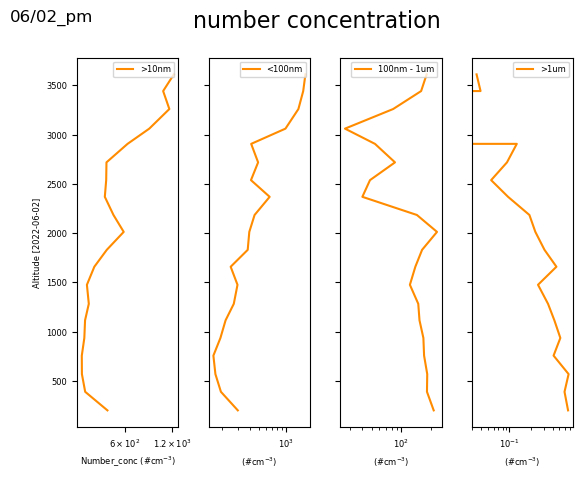

In [14]:
fig, ax = plt.subplots(1, 4, sharey='all')
plt.rcParams['font.size'] = '7'
ax[0].plot(DAY2b_subset_mean['CNgt10nm_ZIEMBA'], DAY2b_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label=">10nm")
ax[1].plot(DAY2b_subset_mean['nSMPS_ZIEMBA'], DAY2b_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label="<100nm")
ax[2].plot(DAY2b_subset_mean['IntegN_100to1000nm_LAS_ZIEMBA'], DAY2b_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label="100nm - 1um")
ax[3].plot(DAY2b_subset_mean['IntegN_gt1000nm_LAS_ZIEMBA'], DAY2b_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label='>1um')
ax[0].set_ylabel('Altitude [2022-06-02]')
ax[0].set_xlabel('Number_conc (#cm$^{-3}$)')
ax[1].set_xlabel('(#cm$^{-3}$)')
ax[2].set_xlabel('(#cm$^{-3}$)')
ax[3].set_xlabel('(#cm$^{-3}$)')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[3].set_xscale('log')
ax[0].legend(loc='upper right', fontsize=6)
ax[1].legend(loc='upper right', fontsize=6)
ax[2].legend(loc='upper right', fontsize=6)
ax[3].legend(loc='upper right', fontsize=6)
# Limit the number of tickers for the second plot
# Reduce the number of x-axis tickers to 2 for ax[0]
ax[0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=2))
ax[0].xaxis.set_minor_locator(ticker.NullLocator())


# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)



fig.text(0.02, 0.98, '06/02_pm', ha='left', va='top', fontsize=12)

# Set the title
fig.suptitle('number concentration', fontsize=16)

plt.show()

Text(0.5, 0.98, 'Volume concentration')

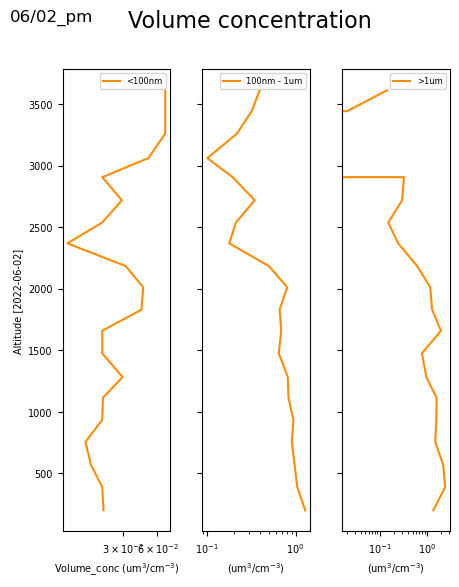

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(5, 6), sharey='all')
plt.rcParams['font.size'] = '6'
ax[0].plot(DAY2b_subset_mean['vSMPS_ZIEMBA'], DAY2b_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label="<100nm")
ax[1].plot(DAY2b_subset_mean['IntegV_100to1000nm_LAS_ZIEMBA'], DAY2b_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label='100nm - 1um')
ax[2].plot(DAY2b_subset_mean['IntegV_gt1000nm_LAS_ZIEMBA'], DAY2b_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label='>1um')
ax[0].set_ylabel('Altitude [2022-06-02]')
ax[0].set_xlabel('Volume_conc (um$^{3}$/cm$^{-3}$)')
ax[1].set_xlabel('(um$^{3}$/cm$^{-3}$)')
ax[2].set_xlabel('(um$^{3}$/cm$^{-3}$)')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[0].legend(loc='upper right', fontsize=6)
ax[1].legend(loc='upper right', fontsize=6)
ax[2].legend(loc='upper right', fontsize=6)
# Adjust the spacing between subplots
# Reduce the number of x-axis tickers to 2 for ax[0]
ax[0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=2))
ax[0].xaxis.set_minor_locator(ticker.NullLocator())

plt.subplots_adjust(wspace=0.3)
fig.text(0.02, 0.98, '06/02_pm', ha='left', va='top', fontsize=12)
# Set the title
fig.suptitle('Volume concentration', fontsize=16)


In [16]:
DAY3 = simple_read('C:/Users/taiwoajayi/Documents/Intvol/activate-mrg1_hu25_20220603_R0_20230625T113221.ict')
start_index = np.where(DAY3["Time_Start"]==pd.to_datetime("2022-06-03 13:30:00"))
stop_index = np.where(DAY3["Time_Start"]==pd.to_datetime("2022-06-03 15:00:00"))
    
DAY3_subset = DAY3[start_index[0][0]:stop_index[0][0]]

# Print the modified subset dataframe
DAY3_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
2467,2022-06-03 13:30:00,2022-06-03 13:30:01,33.872982,-67.052387,2858.90,667.570,483.760,268.835,61.745,7.130,0.410,0.0,0.0,0.0,NaN,NaN,NaN
2468,2022-06-03 13:30:01,2022-06-03 13:30:02,33.872534,-67.053832,2861.55,664.350,480.900,274.010,65.915,8.355,0.530,0.0,0.0,0.0,394.8,3.29,0.04
2469,2022-06-03 13:30:02,2022-06-03 13:30:03,33.872086,-67.055272,2863.82,668.485,480.130,270.200,52.340,5.670,0.270,0.0,0.0,0.0,394.8,3.29,0.04
2470,2022-06-03 13:30:03,2022-06-03 13:30:04,33.871638,-67.056704,2865.57,690.095,479.325,265.675,62.350,5.435,0.175,0.0,0.0,0.0,394.8,3.29,0.04
2471,2022-06-03 13:30:04,2022-06-03 13:30:05,33.871187,-67.058127,2866.59,653.280,477.020,269.410,72.910,7.350,0.335,0.0,0.0,0.0,394.8,3.29,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7862,2022-06-03 14:59:55,2022-06-03 14:59:56,32.712767,-65.244314,2413.61,985.320,639.040,97.300,49.000,5.195,0.255,0.0,0.0,0.0,NaN,NaN,NaN
7863,2022-06-03 14:59:56,2022-06-03 14:59:57,32.712103,-65.243151,2408.15,980.100,648.095,92.760,50.140,5.130,0.255,0.0,0.0,0.0,NaN,NaN,NaN
7864,2022-06-03 14:59:57,2022-06-03 14:59:58,32.711441,-65.241989,2402.02,925.350,655.680,90.215,45.040,4.325,0.165,0.0,0.0,0.0,NaN,NaN,NaN
7865,2022-06-03 14:59:58,2022-06-03 14:59:59,32.710779,-65.240827,2395.43,930.080,665.200,87.335,35.765,4.410,0.290,0.0,0.0,0.0,NaN,NaN,NaN


In [17]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY3_subset.GPS_Altitude_THORNHILL.min(), DAY3_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY3_subset['Bins'] = pd.cut(DAY3_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY3_subset_1000 = DAY3_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY3_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY3_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_3 = DAY3_subset_1000[start_index:stop_index]
DAY1000_subset_3


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
Bins,,,,,,,,,,,,,,,,,
"(94.825, 149.89]",2022-06-03 13:45:28.789007104,2022-06-03 13:45:29.789007104,34.126959,-67.213208,123.892358,443.413723,348.374286,222.672110,227.680004,29.716738,1.301020,0.681427,5.993369,1.973825,196.514612,1.917953,0.021059
"(149.89, 204.956]",2022-06-03 13:48:10.320000000,2022-06-03 13:48:11.319999744,33.927509,-67.395937,181.520500,428.830100,336.405300,217.969600,201.364400,26.530700,1.198600,0.504000,3.558100,1.088000,208.200000,1.935714,0.020000
"(204.956, 260.021]",2022-06-03 13:59:27.145491712,2022-06-03 13:59:28.145491712,34.102741,-67.396328,246.379939,494.200389,384.690963,245.065195,235.967049,30.624160,1.336537,0.648443,5.393945,1.773627,198.240912,1.891180,0.020000
"(260.021, 315.086]",2022-06-03 13:53:11.011236096,2022-06-03 13:53:12.011235840,33.997827,-67.380569,280.595730,460.787247,358.576348,227.703034,233.194157,29.701685,1.272135,0.508090,3.617753,1.014719,196.293043,1.972319,0.020000
"(315.086, 370.151]",2022-06-03 13:54:31.023809536,2022-06-03 13:54:32.023809536,34.037034,-67.328911,340.301310,478.586071,372.943452,235.553095,234.137500,30.795357,1.376071,0.726667,6.176548,2.022857,226.896552,2.102759,0.020000
"(370.151, 425.217]",2022-06-03 13:54:07.136363520,2022-06-03 13:54:08.136363776,34.095859,-67.060673,402.749318,456.671591,349.158864,215.599091,234.905682,29.677955,1.278409,0.909091,7.228409,2.375000,267.120000,2.440000,0.030000
"(425.217, 480.282]",2022-06-03 14:03:16.657894656,2022-06-03 14:03:17.657894656,34.148126,-67.167576,453.531184,652.364211,486.200263,289.610000,176.957105,25.539737,1.318816,0.652368,5.148158,1.658158,421.522059,2.347941,0.026471
"(480.282, 535.347]",2022-06-03 14:09:48.304114432,2022-06-03 14:09:49.304114688,34.166931,-67.301055,500.509848,1073.302388,768.415868,469.062549,79.773059,20.299052,1.617335,1.185277,7.722773,2.207791,555.169300,2.945966,0.030121
"(535.347, 590.412]",2022-06-03 13:56:08.066666752,2022-06-03 13:56:09.066666752,33.903960,-67.359933,562.995667,526.583000,405.156667,255.778667,136.282333,19.794000,1.060333,0.466667,4.494333,1.786000,182.980000,1.507000,0.020000


In [18]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY3_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY3_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3_subset_3000 = DAY3_subset_1000[start_index:stop_index]
DAY3_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
count,45,45,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,44.000000,44.000000,44.000000
mean,2022-06-03 14:17:53.347165952,2022-06-03 14:17:54.347165952,33.699769,-66.823042,2214.439586,1042.328974,693.366405,291.346210,171.515076,17.612228,0.699756,0.257309,2.346553,0.813361,1360.487315,3.779099,0.038398
min,2022-06-03 13:53:27.769230848,2022-06-03 13:53:28.769230592,32.986787,-67.516110,1004.015000,412.799062,314.295313,115.450833,32.036667,3.068043,0.124063,0.000000,0.000000,0.000000,240.892222,1.637778,0.010000
25%,2022-06-03 14:00:02.636363520,2022-06-03 14:00:03.636363520,33.409507,-67.254654,1592.160263,700.380625,478.477083,160.604000,83.202750,8.160250,0.337000,0.108333,0.812692,0.204000,365.885836,1.975000,0.020000
50%,2022-06-03 14:11:07.307692288,2022-06-03 14:11:08.307692288,33.878409,-67.028103,2212.072222,826.709706,575.488462,230.459583,152.023529,17.220000,0.697143,0.237917,1.681818,0.537885,460.108889,3.351759,0.026275
75%,2022-06-03 14:28:57.095238144,2022-06-03 14:28:58.095237888,33.996922,-66.454962,2821.081500,951.419091,670.791000,400.101607,273.391667,26.411667,0.975000,0.390000,3.797917,1.370132,651.205000,5.446250,0.063125
max,2022-06-03 14:54:11.565217536,2022-06-03 14:54:12.565217536,34.194709,-65.729004,3427.270000,7850.188000,4317.614333,609.743333,396.468750,40.017917,1.518182,0.667241,6.468000,2.763750,7036.800000,7.660000,0.090000
std,NaN,NaN,0.354658,0.503728,723.872134,1182.836701,664.468001,153.767842,108.185232,10.723152,0.407287,0.172443,1.835769,0.744543,2288.293697,1.832140,0.025082


In [19]:
nbins = 20
bins3 = np.linspace(DAY3_subset.GPS_Altitude_THORNHILL.min(), DAY3_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY3_subset['Bins'] = pd.cut(DAY3_subset['GPS_Altitude_THORNHILL'], bins3)
DAY3_subset_mean= DAY3_subset.groupby('Bins').mean()
DAY3_subset_mean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
Bins,,,,,,,,,,,,,,,,,
"(94.825, 370.151]",2022-06-03 13:49:56.516416256,2022-06-03 13:49:57.516416256,34.106335,-67.279014,171.578013,458.482279,358.983066,229.172641,229.622282,29.898976,1.308139,0.660006,5.649452,1.848456,197.876279,1.917672,0.020667
"(370.151, 645.478]",2022-06-03 14:08:20.619047680,2022-06-03 14:08:21.619047680,34.151107,-67.290037,499.110760,998.108756,717.629946,438.012680,94.243664,20.950768,1.560092,1.104101,7.340530,2.133233,519.611963,2.814153,0.029298
"(645.478, 920.804]",2022-06-03 14:16:38.435643648,2022-06-03 14:16:39.435643392,34.135261,-67.305691,857.512046,1215.606733,783.317657,411.480363,369.525710,89.817640,6.968086,4.293614,27.131452,7.602624,927.555556,2.248932,0.021838
"(920.804, 1196.13]",2022-06-03 14:15:37.023560192,2022-06-03 14:15:38.023560448,34.050457,-67.474009,971.398259,1137.978246,734.089372,374.703626,475.144385,134.430995,11.116898,7.077134,43.668953,12.208102,611.645769,2.298217,0.020420
"(1196.13, 1471.456]",2022-06-03 14:03:54.296703488,2022-06-03 14:03:55.296703232,34.113940,-67.029434,1318.022857,440.394341,331.182198,160.783901,109.688736,13.387198,0.584725,0.356703,2.538791,0.761648,437.728525,4.481967,0.050492
"(1471.456, 1746.782]",2022-06-03 14:26:10.957356032,2022-06-03 14:26:11.957356032,34.165922,-67.259036,1561.458401,814.011343,602.676588,453.030416,301.248891,29.537164,1.128305,0.401972,3.726503,1.293134,366.555467,4.555852,0.054176
"(1746.782, 2022.109]",2022-06-03 13:59:30.277777664,2022-06-03 13:59:31.277777920,33.900369,-67.253198,1885.965370,881.777222,637.666204,503.097315,323.071759,31.833148,1.187593,0.303056,3.135741,1.177963,366.163333,4.222917,0.048750
"(2022.109, 2297.435]",2022-06-03 13:57:51.660000000,2022-06-03 13:57:52.660000000,33.883285,-67.253390,2152.209000,924.710800,658.581600,530.404500,319.739000,31.920500,1.238300,0.390000,4.017200,1.427300,461.494400,6.289600,0.075800
"(2297.435, 2572.761]",2022-06-03 14:18:06.523255808,2022-06-03 14:18:07.523255808,33.526622,-66.633557,2450.567907,854.532267,598.134419,339.858721,198.741453,19.632267,0.755000,0.198023,2.156163,0.804884,522.616170,4.640213,0.053830


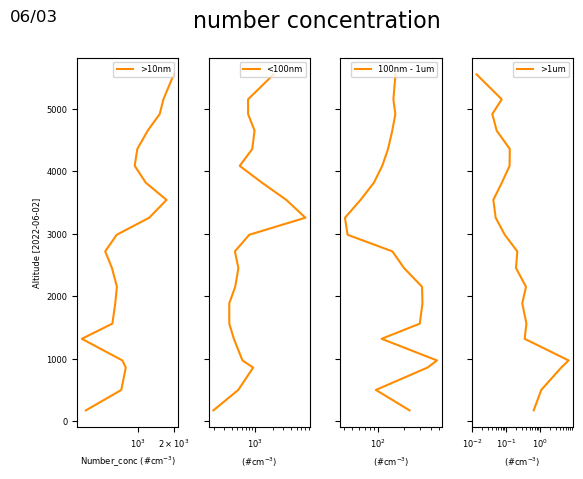

In [20]:
fig, ax = plt.subplots(1, 4, sharey='all')
plt.rcParams['font.size'] = '6'
ax[0].plot(DAY3_subset_mean['CNgt10nm_ZIEMBA'], DAY3_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label=">10nm")
ax[1].plot(DAY3_subset_mean['nSMPS_ZIEMBA'], DAY3_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label="<100nm")
ax[2].plot(DAY3_subset_mean['IntegN_100to1000nm_LAS_ZIEMBA'], DAY3_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label="100nm - 1um")
ax[3].plot(DAY3_subset_mean['IntegN_gt1000nm_LAS_ZIEMBA'], DAY3_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label='>1um')
ax[0].set_ylabel('Altitude [2022-06-02]')
ax[0].set_xlabel('Number_conc (#cm$^{-3}$)')
ax[1].set_xlabel('(#cm$^{-3}$)')
ax[2].set_xlabel('(#cm$^{-3}$)')
ax[3].set_xlabel('(#cm$^{-3}$)')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[3].set_xscale('log')
ax[0].legend(loc='upper right', fontsize=6)
ax[1].legend(loc='upper right', fontsize=6)
ax[2].legend(loc='upper right', fontsize=6)
ax[3].legend(loc='upper right', fontsize=6)
# Reduce the number of x-axis tickers to 2 for ax[0]
ax[0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=2))
ax[0].xaxis.set_minor_locator(ticker.NullLocator())

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)



fig.text(0.02, 0.98, '06/03', ha='left', va='top', fontsize=12)

# Set the title
fig.suptitle('number concentration', fontsize=16)

plt.show()

Text(0.5, 0.98, 'Volume concentration')

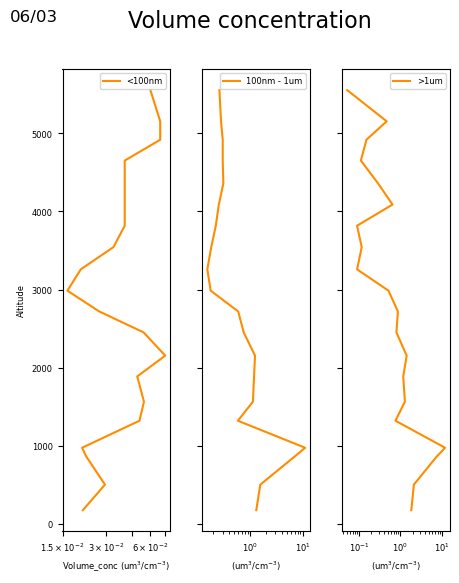

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(5, 6), sharey='all')
plt.rcParams['font.size'] = '6'
ax[0].plot(DAY3_subset_mean['vSMPS_ZIEMBA'], DAY3_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label="<100nm")
ax[1].plot(DAY3_subset_mean['IntegV_100to1000nm_LAS_ZIEMBA'], DAY3_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label='100nm - 1um')
ax[2].plot(DAY3_subset_mean['IntegV_gt1000nm_LAS_ZIEMBA'], DAY3_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label='>1um')
ax[0].set_ylabel('Altitude')
ax[0].set_xlabel('Volume_conc (um$^{3}$/cm$^{-3}$)')
ax[1].set_xlabel('(um$^{3}$/cm$^{-3}$)')
ax[2].set_xlabel('(um$^{3}$/cm$^{-3}$)')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[0].legend(loc='upper right', fontsize=6)
ax[1].legend(loc='upper right', fontsize=6)
ax[2].legend(loc='upper right', fontsize=6)
# Limit the number of tickers for the second plot
ax[0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
ax[0].xaxis.set_minor_locator(ticker.NullLocator())

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)
fig.text(0.02, 0.98, '06/03', ha='left', va='top', fontsize=12)
fig.suptitle('Volume concentration', fontsize=16)

In [22]:
DAY7 = simple_read('C:/Users/taiwoajayi/Documents/Intvol/activate-mrg1_hu25_20220607_R0_L1_20230625T113222.ict')
start_index = np.where(DAY7["Time_Start"]==pd.to_datetime("2022-06-07 14:32:00"))
stop_index = np.where(DAY7["Time_Start"]==pd.to_datetime("2022-06-07 14:47:00"))
    
DAY7_subset =DAY7[start_index[0][0]:stop_index[0][0]]

# Print the modified subset dataframe
DAY7_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
10397,2022-06-07 14:32:00,2022-06-07 14:32:01,32.250498,-64.999220,127.595,1479.020,1130.190,888.840,483.165,46.910,2.060,1.555,10.760,2.700,NaN,NaN,NaN
10398,2022-06-07 14:32:01,2022-06-07 14:32:02,32.249883,-64.998233,126.585,1506.670,1140.410,886.460,455.645,46.970,2.330,1.560,10.785,2.710,NaN,NaN,NaN
10399,2022-06-07 14:32:02,2022-06-07 14:32:03,32.249267,-64.997244,125.870,1477.210,1150.300,900.190,485.655,48.740,2.360,1.040,6.695,1.630,NaN,NaN,NaN
10400,2022-06-07 14:32:03,2022-06-07 14:32:04,32.248648,-64.996254,125.955,1433.030,1149.960,905.725,508.490,47.900,1.950,1.035,10.560,3.235,NaN,NaN,NaN
10401,2022-06-07 14:32:04,2022-06-07 14:32:05,32.248027,-64.995263,126.990,1361.160,1139.110,900.205,510.830,46.175,1.805,1.555,14.675,4.320,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11292,2022-06-07 14:46:55,2022-06-07 14:46:56,32.255021,-64.999573,2800.660,982.565,723.940,527.160,162.340,11.650,0.335,0.520,4.095,1.080,NaN,NaN,NaN
11293,2022-06-07 14:46:56,2022-06-07 14:46:57,32.255098,-64.998248,2805.770,969.990,724.420,537.565,144.225,10.390,0.300,0.000,0.000,0.000,NaN,NaN,NaN
11294,2022-06-07 14:46:57,2022-06-07 14:46:58,32.255152,-64.996919,2810.920,1011.290,723.440,535.745,158.975,11.220,0.315,0.000,0.000,0.000,NaN,NaN,NaN
11295,2022-06-07 14:46:58,2022-06-07 14:46:59,32.255184,-64.995588,2816.140,1049.350,726.135,537.585,161.965,10.870,0.295,0.000,0.000,0.000,NaN,NaN,NaN


In [23]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY7_subset.GPS_Altitude_THORNHILL.min(), DAY7_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY7_subset['Bins'] = pd.cut(DAY7_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY7_subset_1000 = DAY7_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY7_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY7_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_7 = DAY7_subset_1000[start_index:stop_index]
DAY1000_subset_7


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
Bins,,,,,,,,,,,,,,,,,
"(125.87, 152.826]",2022-06-07 14:32:05.300000000,2022-06-07 14:32:06.300,32.247173,-64.994004,134.321500,1435.083000,1136.687000,897.789000,516.202000,49.634000,2.187000,1.244500,11.889500,3.668000,NaN,NaN,NaN
"(152.826, 179.781]",2022-06-07 14:32:13.999999744,2022-06-07 14:32:15.000,32.241209,-64.985889,170.347143,1455.855714,1136.638571,898.635714,565.637857,53.484286,2.360714,2.540714,22.065714,8.170714,725.80,7.90,0.09
"(179.781, 206.737]",2022-06-07 14:32:27.500000000,2022-06-07 14:32:28.500,32.229147,-64.976789,189.676250,1482.236000,1138.632000,902.439500,537.602500,51.013000,2.273000,2.176750,21.313500,7.116750,725.80,7.90,0.09
"(206.737, 233.692]",2022-06-07 14:32:40.000000000,2022-06-07 14:32:41.000,32.216014,-64.972505,219.682000,1441.856000,1138.980000,905.034000,543.262000,48.659000,1.881000,1.583000,10.418000,2.824000,725.80,7.90,0.09
"(233.692, 260.648]",2022-06-07 14:32:48.000000000,2022-06-07 14:32:49.000,32.207258,-64.973206,249.774091,1446.724545,1129.032727,898.421818,570.105000,52.781818,2.187727,2.199545,17.743182,5.620455,725.80,7.90,0.09
"(260.648, 287.604]",2022-06-07 14:33:01.000000000,2022-06-07 14:33:02.000,32.194130,-64.979359,265.369667,1446.005333,1126.573333,897.023667,536.649333,49.485333,2.063333,1.593333,13.899333,4.319000,725.80,7.90,0.09
"(287.604, 314.559]",2022-06-07 14:33:13.500000000,2022-06-07 14:33:14.500,32.184571,-64.990567,303.789500,1429.493000,1125.196000,896.597500,588.128500,55.460500,2.388000,2.416500,19.997500,6.764000,829.79,10.26,0.12
"(314.559, 341.515]",2022-06-07 14:33:26.000000000,2022-06-07 14:33:27.000,32.179710,-65.005119,326.685667,1440.675333,1120.728667,892.268000,547.642333,50.920333,2.172000,1.929000,17.999667,5.928000,829.79,10.26,0.12
"(341.515, 368.47]",2022-06-07 14:33:38.000000000,2022-06-07 14:33:39.000,32.179533,-65.019885,353.990000,1439.664444,1130.942222,896.076111,542.650000,50.651667,2.149444,2.234444,16.087222,4.610000,829.79,10.26,0.12


In [24]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY7_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY7_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY7_subset_3000 = DAY7_subset_1000[start_index:stop_index]
DAY7_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
Bins,,,,,,,,,,,,,,,,,
"(1015.405, 1042.36]",2022-06-07 14:38:12.000,2022-06-07 14:38:13.000,32.229338,-65.062171,1029.744286,1147.548571,856.379286,651.091429,460.962857,41.999286,1.696429,1.390714,16.549286,6.310000,NaN,NaN,NaN
"(1042.36, 1069.316]",2022-06-07 14:38:21.000,2022-06-07 14:38:22.000,32.236954,-65.057676,1056.277273,1041.906364,756.471364,555.483636,423.068636,40.173182,1.722273,1.629091,17.053636,6.571818,NaN,NaN,NaN
"(1069.316, 1096.272]",2022-06-07 14:38:32.000,2022-06-07 14:38:33.000,32.245122,-65.049970,1083.785455,969.461818,723.020000,518.536364,414.625909,39.484091,1.663182,0.520000,2.426364,0.518182,NaN,NaN,NaN
"(1096.272, 1123.227]",2022-06-07 14:38:42.500,2022-06-07 14:38:43.500,32.251109,-65.040405,1108.407000,959.246500,715.916000,514.292000,398.334500,37.522500,1.589500,1.040000,10.096000,3.136000,NaN,NaN,NaN
"(1123.227, 1150.183]",2022-06-07 14:38:52.000,2022-06-07 14:38:53.000,32.254066,-65.030048,1136.586667,937.281111,704.258889,504.713889,402.171111,38.945000,1.683889,1.168333,11.634444,4.322778,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(2659.696, 2686.652]",2022-06-07 14:46:31.000,2022-06-07 14:46:32.000,32.246791,-65.029386,2672.710000,1174.136000,818.506000,508.965000,45.042000,2.553000,0.066000,0.000000,0.000000,0.000000,NaN,NaN,NaN
"(2686.652, 2713.608]",2022-06-07 14:46:36.000,2022-06-07 14:46:37.000,32.249473,-65.023645,2699.616000,1173.456000,846.949000,512.785000,43.869000,2.230000,0.049000,0.000000,0.000000,0.000000,NaN,NaN,NaN
"(2713.608, 2740.563]",2022-06-07 14:46:41.000,2022-06-07 14:46:42.000,32.251655,-65.017598,2726.148000,1070.004000,769.171000,500.690000,100.560000,6.361000,0.166000,0.000000,0.000000,0.000000,NaN,NaN,NaN


In [25]:
nbins = 20
bins = np.linspace(DAY7_subset.GPS_Altitude_THORNHILL.min(), DAY7_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY7_subset['Bins'] = pd.cut(DAY7_subset['GPS_Altitude_THORNHILL'], bins)
DAY7_subset_mean = DAY7_subset.groupby('Bins').mean()
DAY7_subset_mean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
Bins,,,,,,,,,,,,,,,,,
"(125.87, 260.648]",2022-06-07 14:32:26.962264064,2022-06-07 14:32:27.962264320,32.228359,-64.980091,191.982925,1458.675283,1136.042264,900.470566,544.547170,51.224245,2.213679,1.997642,17.865849,5.889717,725.800000,7.900000,0.090000
"(260.648, 395.426]",2022-06-07 14:33:22.500000000,2022-06-07 14:33:23.500000000,32.184684,-65.002125,320.002672,1447.662069,1126.562069,895.791897,551.480086,51.024138,2.149914,1.992069,17.498707,5.646466,815.279767,9.930698,0.115814
"(395.426, 530.204]",2022-06-07 14:34:19.000000256,2022-06-07 14:34:20.000000000,32.207508,-65.045768,461.442818,1471.811636,1132.538909,898.615818,536.766818,50.243455,2.171000,2.176818,19.234364,6.124273,826.126000,10.180000,0.120000
"(530.204, 664.982]",2022-06-07 14:35:16.500000000,2022-06-07 14:35:17.500000000,32.232658,-65.008332,595.978500,1493.533000,1134.662333,898.169000,542.480750,51.598250,2.287417,1.449417,14.643083,5.159500,836.260667,10.316444,0.120000
"(664.982, 799.76]",2022-06-07 14:36:14.500000000,2022-06-07 14:36:15.500000000,32.190803,-64.988014,732.742768,1492.275536,1116.359107,887.298036,560.679911,51.198304,2.061250,2.123036,16.289375,5.019911,731.816341,9.007317,0.106341
"(799.76, 934.538]",2022-06-07 14:37:10.000000000,2022-06-07 14:37:11.000000000,32.178847,-65.039683,867.218273,1415.278545,1058.129727,841.851000,555.687273,50.380545,2.060727,1.236909,9.443091,2.919545,640.863500,7.933000,0.094250
"(934.538, 1069.316]",2022-06-07 14:38:02.000000256,2022-06-07 14:38:03.000000000,32.219780,-65.062597,1000.849694,1195.032041,882.122959,675.657653,460.823265,42.657959,1.760816,1.245510,11.808776,4.275612,611.020000,7.610000,0.090000
"(1069.316, 1204.094]",2022-06-07 14:38:51.000000000,2022-06-07 14:38:52.000000000,32.251072,-65.030295,1134.863673,963.725306,713.872041,512.281429,406.830204,39.170204,1.702347,1.059592,9.879898,3.462143,NaN,NaN,NaN
"(1204.094, 1338.872]",2022-06-07 14:39:37.000000000,2022-06-07 14:39:38.000000000,32.231774,-64.988403,1270.812093,1078.590930,791.186860,594.322093,375.780349,34.719302,1.407093,1.068837,7.880814,2.393837,NaN,NaN,NaN


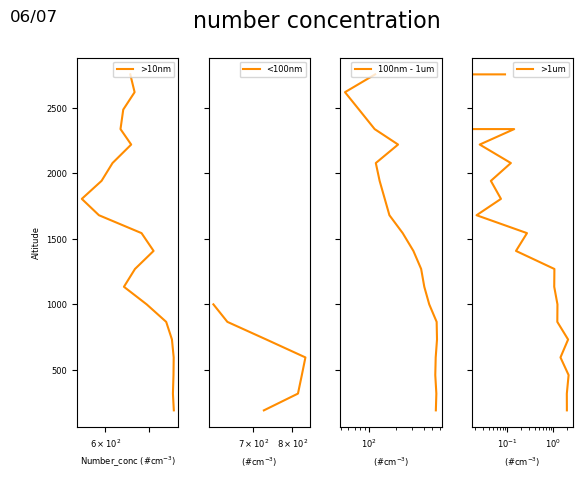

In [26]:
fig, ax = plt.subplots(1, 4, sharey='all')
plt.rcParams['font.size'] = '6'
ax[0].plot(DAY7_subset_mean['CNgt10nm_ZIEMBA'], DAY7_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label=">10nm")
ax[1].plot(DAY7_subset_mean['nSMPS_ZIEMBA'], DAY7_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label="<100nm")
ax[2].plot(DAY7_subset_mean['IntegN_100to1000nm_LAS_ZIEMBA'], DAY7_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label="100nm - 1um")
ax[3].plot(DAY7_subset_mean['IntegN_gt1000nm_LAS_ZIEMBA'], DAY7_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label='>1um')
ax[0].set_ylabel('Altitude')
ax[0].set_xlabel('Number_conc (#cm$^{-3}$)')
ax[1].set_xlabel('(#cm$^{-3}$)')
ax[2].set_xlabel('(#cm$^{-3}$)')
ax[3].set_xlabel('(#cm$^{-3}$)')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[3].set_xscale('log')
ax[0].legend(loc='upper right', fontsize=6)
ax[1].legend(loc='upper right', fontsize=6)
ax[2].legend(loc='upper right', fontsize=6)
ax[3].legend(loc='upper right', fontsize=6)
# Limit the number of tickers for the second plot
ax[0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=2))
ax[0].xaxis.set_minor_locator(ticker.NullLocator())

# Reduce the number of x-axis tickers to 2 for ax[1]
ax[1].xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
ax[1].xaxis.set_minor_locator(ticker.NullLocator())

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)



fig.text(0.02, 0.98, '06/07', ha='left', va='top', fontsize=12)

# Set the title
fig.suptitle('number concentration', fontsize=16)

plt.show()

Text(0.5, 0.98, 'Volume concentration')

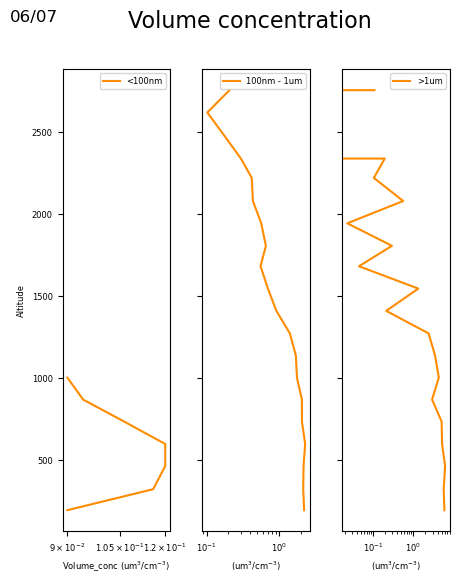

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(5, 6), sharey='all')
plt.rcParams['font.size'] = '6'
ax[0].plot(DAY7_subset_mean['vSMPS_ZIEMBA'], DAY7_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label="<100nm")
ax[1].plot(DAY7_subset_mean['IntegV_100to1000nm_LAS_ZIEMBA'], DAY7_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label='100nm - 1um')
ax[2].plot(DAY7_subset_mean['IntegV_gt1000nm_LAS_ZIEMBA'], DAY7_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label='>1um')
ax[0].set_ylabel('Altitude')
ax[0].set_xlabel('Volume_conc (um$^{3}$/cm$^{-3}$)')
ax[1].set_xlabel('(um$^{3}$/cm$^{-3}$)')
ax[2].set_xlabel('(um$^{3}$/cm$^{-3}$)')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[0].legend(loc='upper right', fontsize=6)
ax[1].legend(loc='upper right', fontsize=6)
ax[2].legend(loc='upper right', fontsize=6)
# Limit the number of tickers for the second plot
ax[0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
ax[0].xaxis.set_minor_locator(ticker.NullLocator())

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)
fig.text(0.02, 0.98, '06/07', ha='left', va='top', fontsize=12)
fig.suptitle('Volume concentration', fontsize=16)

In [28]:
DAY7b = simple_read('C:/Users/taiwoajayi/Documents/Intvol/activate-mrg1_hu25_20220607_R0_L2_20230625T113222.ict')
start_index = np.where(DAY7b["Time_Start"]==pd.to_datetime("2022-06-07 19:08:00"))
stop_index = np.where(DAY7b["Time_Start"]==pd.to_datetime("2022-06-07 19:23:00"))
DAY7b_subset = DAY7b[start_index[0][0]:stop_index[0][0]]

# Print the modified subset dataframe
DAY7b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
10420,2022-06-07 19:08:00,2022-06-07 19:08:01,32.242823,-65.003952,133.320,1661.83,1280.81,624.390,244.365,20.950,0.815,1.560,25.370,11.295,NaN,NaN,NaN
10421,2022-06-07 19:08:01,2022-06-07 19:08:02,32.243085,-65.002775,133.120,1482.43,1137.87,570.225,267.975,24.875,1.170,1.040,18.895,9.140,NaN,NaN,NaN
10422,2022-06-07 19:08:02,2022-06-07 19:08:03,32.243347,-65.001596,132.930,1343.59,1039.63,495.805,264.930,23.455,1.080,0.515,10.255,4.295,NaN,NaN,NaN
10423,2022-06-07 19:08:03,2022-06-07 19:08:04,32.243610,-65.000416,132.720,1879.32,1373.12,496.615,283.615,28.370,1.495,1.165,12.290,4.635,NaN,NaN,NaN
10424,2022-06-07 19:08:04,2022-06-07 19:08:05,32.243873,-64.999235,132.595,2663.03,1890.83,524.845,290.545,32.845,2.020,3.115,12.240,2.440,2521.87,7.29,0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11315,2022-06-07 19:22:55,2022-06-07 19:22:56,32.296480,-65.011792,3518.030,1651.75,1200.27,863.765,263.255,18.155,0.525,0.000,0.000,0.000,NaN,NaN,NaN
11316,2022-06-07 19:22:56,2022-06-07 19:22:57,32.296519,-65.013093,3524.890,1651.04,1225.66,901.115,263.610,18.415,0.535,0.000,0.000,0.000,NaN,NaN,NaN
11317,2022-06-07 19:22:57,2022-06-07 19:22:58,32.296518,-65.014396,3531.840,1730.83,1245.77,915.595,268.715,19.870,0.710,0.000,0.000,0.000,NaN,NaN,NaN
11318,2022-06-07 19:22:58,2022-06-07 19:22:59,32.296479,-65.015699,3538.850,1770.43,1251.20,902.450,269.145,19.350,0.670,0.520,10.280,4.305,NaN,NaN,NaN


In [29]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY7b_subset.GPS_Altitude_THORNHILL.min(), DAY7b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY7b_subset['Bins'] = pd.cut(DAY7b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY7b_subset_1000 = DAY7b_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY7b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY7b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_7b = DAY7b_subset_1000[start_index:stop_index]
DAY1000_subset_7b

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
Bins,,,,,,,,,,,,,,,,,
"(132.595, 166.728]",2022-06-07 19:08:08.764705792,2022-06-07 19:08:09.764706048,32.245613,-64.993812,142.995294,2482.738824,1880.049412,533.319118,257.664706,25.361471,1.291765,1.738529,16.392647,6.099118,2521.87,7.29,0.07
"(166.728, 200.861]",2022-06-07 19:08:21.500000000,2022-06-07 19:08:22.500000000,32.252466,-64.980849,183.907500,3206.191250,2442.037500,579.219375,296.118750,27.065000,1.244375,1.523750,12.903750,3.888750,2521.87,7.29,0.07
"(200.861, 234.994]",2022-06-07 19:08:31.500000000,2022-06-07 19:08:32.500000000,32.261230,-64.974575,218.264583,3499.600000,2635.995000,596.680000,269.933750,25.284583,1.150417,1.999583,18.445417,6.111667,2521.87,7.29,0.07
"(234.994, 269.127]",2022-06-07 19:08:42.500000000,2022-06-07 19:08:43.500000000,32.272442,-64.972311,251.997000,2359.411000,1806.086000,525.913500,255.105000,25.556000,1.321500,1.567500,10.676500,3.448000,2521.87,7.29,0.07
"(269.127, 303.26]",2022-06-07 19:08:51.500000000,2022-06-07 19:08:52.500000000,32.281693,-64.974483,287.190000,1257.476250,983.810000,442.630625,258.732500,24.690625,1.176250,2.043125,24.381875,9.407500,2521.87,7.29,0.07
"(303.26, 337.393]",2022-06-07 19:09:01.500000000,2022-06-07 19:09:02.500000000,32.290806,-64.980798,319.254583,1127.029167,889.526667,443.117917,236.320417,22.327500,1.032917,1.913750,16.245417,5.516250,717.78,5.57,0.06
"(337.393, 371.526]",2022-06-07 19:09:12.000000000,2022-06-07 19:09:13.000000000,32.298242,-64.990766,354.736667,1154.803333,905.156111,443.282222,241.909444,23.610000,1.120000,2.434444,27.720000,11.108889,717.78,5.57,0.06
"(371.526, 405.659]",2022-06-07 19:09:23.500000000,2022-06-07 19:09:24.500000000,32.302454,-65.004622,389.557143,1166.270714,914.272857,455.456786,240.567500,23.728929,1.182500,1.872143,13.507143,3.980357,717.78,5.57,0.06
"(405.659, 439.792]",2022-06-07 19:09:35.000000000,2022-06-07 19:09:36.000000000,32.302506,-65.019551,421.782778,1078.676667,847.356667,445.643889,239.874444,23.700000,1.171667,1.730000,18.705556,6.622222,717.78,5.57,0.06


In [30]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY7b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY7b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY7b_subset_3000 = DAY7b_subset_1000[start_index:stop_index]
DAY7b_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
Bins,,,,,,,,,,,,,,,,,
"(985.921, 1020.054]",2022-06-07 19:12:28.500,2022-06-07 19:12:29.500,32.296148,-64.998385,1003.411000,7889.060000,5840.821000,1514.925000,554.148500,44.375500,1.811500,2.102500,16.658000,5.089500,6875.84,28.80,0.30
"(1020.054, 1054.187]",2022-06-07 19:12:38.500,2022-06-07 19:12:39.500,32.299974,-65.010363,1037.215000,10547.610000,7854.147000,1980.093000,653.492000,49.740000,1.836000,1.727000,20.829500,8.040000,6875.84,28.80,0.30
"(1054.187, 1088.32]",2022-06-07 19:12:48.000,2022-06-07 19:12:49.000,32.300554,-65.022498,1071.926667,12387.433333,9408.652222,2059.863333,694.090556,52.733889,1.891667,1.285556,12.817778,4.620000,6875.84,28.80,0.30
"(1088.32, 1122.453]",2022-06-07 19:12:58.500,2022-06-07 19:12:59.500,32.297572,-65.035423,1104.758333,11659.556667,8586.635000,1831.494167,635.127500,49.018750,1.892917,0.940417,9.561250,3.052500,2339.91,7.58,0.08
"(1122.453, 1156.586]",2022-06-07 19:13:10.500,2022-06-07 19:13:11.500,32.290153,-65.047951,1140.011667,7064.624167,4767.755000,1080.017083,488.175833,41.289167,1.661250,1.977917,19.647917,6.549167,2339.91,7.58,0.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(3306.969, 3341.102]",2022-06-07 19:22:24.000,2022-06-07 19:22:25.000,32.278726,-64.979771,3325.450000,1063.280000,727.991000,457.109000,135.034000,9.041000,0.273000,0.000000,0.000000,0.000000,NaN,NaN,NaN
"(3341.102, 3375.235]",2022-06-07 19:22:29.500,2022-06-07 19:22:30.500,32.283554,-64.983849,3359.553333,1103.030000,769.202500,498.921667,125.381667,8.176667,0.261667,0.000000,0.000000,0.000000,NaN,NaN,NaN
"(3375.235, 3409.368]",2022-06-07 19:22:35.000,2022-06-07 19:22:36.000,32.287882,-64.988668,3393.912000,1180.968000,823.535000,559.276000,148.945000,9.901000,0.301000,0.208000,2.596000,0.864000,NaN,NaN,NaN


In [31]:
nbins = 20
bins = np.linspace(DAY7b_subset.GPS_Altitude_THORNHILL.min(), DAY7b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY7b_subset['Bins'] = pd.cut(DAY7b_subset['GPS_Altitude_THORNHILL'], bins)
DAY7b_subset_mean = DAY7b_subset.groupby('Bins').mean()
DAY7b_subset_mean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
Bins,,,,,,,,,,,,,,,,,
"(132.595, 303.26]",2022-06-07 19:08:27.927272960,2022-06-07 19:08:28.927272704,32.260143,-64.981008,206.160818,2609.185636,1982.916727,539.282182,265.624818,25.530273,1.242636,1.777455,16.455818,5.779545,2521.870000,7.290000,0.070000
"(303.26, 473.926]",2022-06-07 19:09:23.000000000,2022-06-07 19:09:24.000000000,32.298470,-65.005044,387.272273,1142.710545,898.808636,447.474818,240.503636,23.352727,1.128727,1.896455,18.095455,6.377364,717.780000,5.570000,0.060000
"(473.926, 644.591]",2022-06-07 19:10:16.000000000,2022-06-07 19:10:17.000000000,32.270657,-65.049086,556.688137,2100.340196,1589.032843,513.043529,251.027647,25.679706,1.381471,1.470882,11.544706,3.429314,1293.020000,9.720000,0.100000
"(644.591, 815.256]",2022-06-07 19:11:06.000000256,2022-06-07 19:11:07.000000000,32.237592,-65.016470,727.089184,4466.059796,3239.911837,727.279592,304.423469,28.477245,1.395102,1.663265,15.797041,5.396633,2702.292941,10.299706,0.107941
"(815.256, 985.921]",2022-06-07 19:11:57.000000000,2022-06-07 19:11:57.999999744,32.268371,-64.982250,898.412830,5862.989434,4194.925094,960.102547,385.125283,34.152547,1.532453,1.601321,15.427642,5.412075,5071.965263,20.107895,0.210000
"(985.921, 1156.586]",2022-06-07 19:12:50.000000000,2022-06-07 19:12:51.000000000,32.296583,-65.024348,1075.298868,9821.580566,7205.287358,1668.435566,600.053962,47.159528,1.814151,1.601604,15.863113,5.435755,5324.074474,21.540526,0.224737
"(1156.586, 1327.252]",2022-06-07 19:13:46.000000000,2022-06-07 19:13:47.000000000,32.255860,-65.052373,1245.997797,1733.258644,1248.186102,646.635508,281.778051,23.229576,0.872034,0.435763,3.322203,1.013390,1843.920000,7.285455,0.080000
"(1327.252, 1497.917]",2022-06-07 19:14:42.000000256,2022-06-07 19:14:43.000000000,32.238537,-65.002023,1408.511509,886.128113,678.282358,509.411415,197.418113,14.900472,0.493585,0.039245,0.776604,0.325094,500.549737,6.157895,0.074737
"(1497.917, 1668.582]",2022-06-07 19:15:35.500000000,2022-06-07 19:15:36.500000000,32.281293,-64.993517,1580.368519,677.543981,510.960556,361.459537,164.402870,14.117963,0.502130,0.101111,1.089074,0.372037,363.730000,3.900000,0.040000


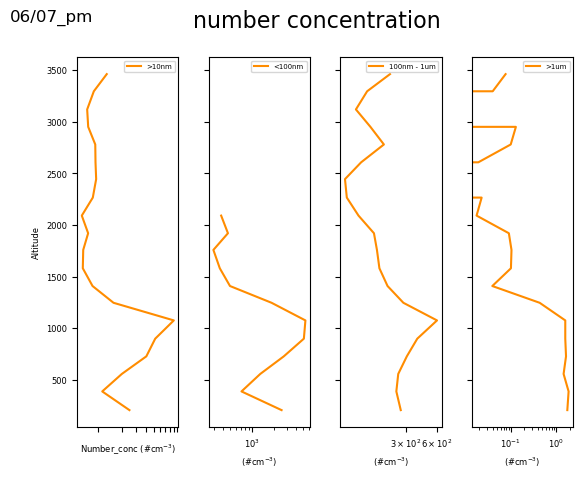

In [32]:
fig, ax = plt.subplots(1, 4, sharey='all')
plt.rcParams['font.size'] = '6'
ax[0].plot(DAY7b_subset_mean['CNgt10nm_ZIEMBA'], DAY7b_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label=">10nm")
ax[1].plot(DAY7b_subset_mean['nSMPS_ZIEMBA'], DAY7b_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label="<100nm")
ax[2].plot(DAY7b_subset_mean['IntegN_100to1000nm_LAS_ZIEMBA'], DAY7b_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label="100nm - 1um")
ax[3].plot(DAY7b_subset_mean['IntegN_gt1000nm_LAS_ZIEMBA'], DAY7b_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label='>1um')
ax[0].set_ylabel('Altitude')
ax[0].set_xlabel('Number_conc (#cm$^{-3}$)')
ax[1].set_xlabel('(#cm$^{-3}$)')
ax[2].set_xlabel('(#cm$^{-3}$)')
ax[3].set_xlabel('(#cm$^{-3}$)')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[3].set_xscale('log')
ax[0].legend(loc='upper right', fontsize=5)
ax[1].legend(loc='upper right', fontsize=5)
ax[2].legend(loc='upper right', fontsize=5)
ax[3].legend(loc='upper right', fontsize=5)
# Limit the number of tickers for the second plot
ax[0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
ax[0].xaxis.set_minor_locator(ticker.NullLocator())


# Reduce the number of x-axis tickers to 2 for ax[2]
ax[2].xaxis.set_major_locator(ticker.MaxNLocator(nbins=2))
ax[2].xaxis.set_minor_locator(ticker.NullLocator())


# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)



fig.text(0.02, 0.98, '06/07_pm', ha='left', va='top', fontsize=12)

# Set the title
fig.suptitle('number concentration', fontsize=16)

plt.show()

Text(0.5, 0.98, 'Volume concentration')

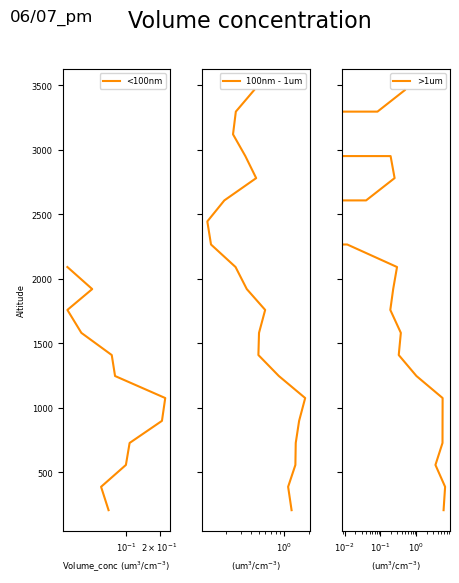

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(5, 6), sharey='all')
plt.rcParams['font.size'] = '6'
ax[0].plot(DAY7b_subset_mean['vSMPS_ZIEMBA'], DAY7b_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label="<100nm")
ax[1].plot(DAY7b_subset_mean['IntegV_100to1000nm_LAS_ZIEMBA'], DAY7b_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label='100nm - 1um')
ax[2].plot(DAY7b_subset_mean['IntegV_gt1000nm_LAS_ZIEMBA'], DAY7b_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label='>1um')
ax[0].set_ylabel('Altitude')
ax[0].set_xlabel('Volume_conc (um$^{3}$/cm$^{-3}$)')
ax[1].set_xlabel('(um$^{3}$/cm$^{-3}$)')
ax[2].set_xlabel('(um$^{3}$/cm$^{-3}$)')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[0].legend(loc='upper right', fontsize=6)
ax[1].legend(loc='upper right', fontsize=6)
ax[2].legend(loc='upper right', fontsize=6)
# Limit the number of tickers for the second plot
ax[0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=2))
ax[0].xaxis.set_minor_locator(ticker.NullLocator())


# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)
fig.text(0.02, 0.98, '06/07_pm', ha='left', va='top', fontsize=12)
fig.suptitle('Volume concentration', fontsize=16)

In [34]:
DAY8 = simple_read('C:/Users/taiwoajayi/Documents/Intvol/activate-mrg1_hu25_20220608_R0_L2_20230625T113223.ict')
start_index = np.where(DAY8["Time_Start"]==pd.to_datetime("2022-06-08 20:30:00"))
stop_index = np.where(DAY8["Time_Start"]==pd.to_datetime("2022-06-08 20:45:00"))
    
DAY8_subset= DAY8[start_index[0][0]:stop_index[0][0]]
DAY8_subsetstart_col2 = 'CNgt3nm_ZIEMBA'

# Print the modified subset dataframe
DAY8_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
10668,2022-06-08 20:30:00,2022-06-08 20:30:01,32.267080,-64.998961,152.725,821.060,705.605,332.080,305.640,30.115,1.380,1.165,8.505,2.490,544.34,4.05,0.04
10669,2022-06-08 20:30:01,2022-06-08 20:30:02,32.268158,-64.999178,153.350,852.060,708.400,330.620,331.195,30.970,1.210,1.170,4.620,0.880,544.34,4.05,0.04
10670,2022-06-08 20:30:02,2022-06-08 20:30:03,32.269234,-64.999434,153.870,880.495,707.050,329.955,350.695,31.040,1.045,1.170,4.620,0.880,544.34,4.05,0.04
10671,2022-06-08 20:30:03,2022-06-08 20:30:04,32.270310,-64.999724,154.255,857.660,698.910,331.855,346.920,31.230,1.065,1.170,4.625,0.880,544.34,4.05,0.04
10672,2022-06-08 20:30:04,2022-06-08 20:30:05,32.271382,-65.000051,154.510,827.165,692.045,334.895,328.180,29.790,1.000,1.820,6.665,1.220,544.34,4.05,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11563,2022-06-08 20:44:55,2022-06-08 20:44:56,32.251172,-65.086081,3838.620,3281.520,2328.360,1602.230,271.575,17.210,0.475,0.000,0.000,0.000,NaN,NaN,NaN
11564,2022-06-08 20:44:56,2022-06-08 20:44:57,32.250122,-65.085465,3847.170,3293.140,2330.700,1611.740,278.340,17.130,0.450,0.000,0.000,0.000,NaN,NaN,NaN
11565,2022-06-08 20:44:57,2022-06-08 20:44:58,32.249088,-65.084808,3855.660,3305.780,2332.940,1613.300,275.080,17.680,0.545,0.000,0.000,0.000,NaN,NaN,NaN
11566,2022-06-08 20:44:58,2022-06-08 20:44:59,32.248074,-65.084107,3864.100,3302.420,2367.110,1615.010,279.285,17.890,0.555,0.000,0.000,0.000,NaN,NaN,NaN


In [35]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY8_subset.GPS_Altitude_THORNHILL.min(), DAY8_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY8_subset['Bins'] = pd.cut(DAY8_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY8_subset_1000 = DAY8_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY8_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY8_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_8 = DAY8_subset_1000[start_index:stop_index]
DAY1000_subset_8


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
Bins,,,,,,,,,,,,,,,,,
"(147.455, 184.705]",2022-06-08 20:30:28.263158016,2022-06-08 20:30:29.263158016,32.290577,-65.021135,156.621053,858.660175,704.467807,334.184912,303.269386,29.252544,1.255263,1.179737,9.176316,3.006579,535.676279,4.038605,0.04
"(184.705, 221.955]",2022-06-08 20:31:07.000000000,2022-06-08 20:31:08.000000000,32.299647,-65.066050,200.296842,854.373684,697.677105,331.928684,291.630000,29.325526,1.347368,0.860789,9.981053,3.704737,491.120000,3.980000,0.04
"(221.955, 259.205]",2022-06-08 20:31:21.500000000,2022-06-08 20:31:22.500000000,32.291629,-65.080346,241.513000,818.649500,669.570000,317.116000,281.062000,28.334000,1.271000,2.126500,18.609000,5.881000,491.120000,3.980000,0.04
"(259.205, 296.455]",2022-06-08 20:31:32.500000000,2022-06-08 20:31:33.500000000,32.282682,-65.087075,277.773750,799.804583,666.716250,319.307917,286.485833,29.412500,1.358750,1.470000,16.477083,6.172500,491.120000,3.980000,0.04
"(296.455, 333.705]",2022-06-08 20:31:44.000000000,2022-06-08 20:31:45.000000000,32.272093,-65.089810,314.530000,818.790455,665.265000,318.348182,274.606818,27.246364,1.163636,1.641364,14.422273,4.848636,NaN,NaN,NaN
"(333.705, 370.955]",2022-06-08 20:31:54.500000000,2022-06-08 20:31:55.500000000,32.262361,-65.088187,352.470000,804.514500,661.676500,313.367000,299.810000,30.578000,1.412000,1.439500,12.510000,4.010000,548.160000,4.460000,0.05
"(370.955, 408.205]",2022-06-08 20:32:04.500000000,2022-06-08 20:32:05.500000000,32.253986,-65.083164,388.985500,810.696000,662.560500,318.842000,292.708000,28.217500,1.109500,0.909000,6.521000,1.824500,548.160000,4.460000,0.05
"(408.205, 445.455]",2022-06-08 20:32:15.500000000,2022-06-08 20:32:16.500000000,32.246732,-65.074310,425.771250,797.773750,657.726667,317.602917,298.759167,29.204583,1.197917,1.555417,15.364583,4.988333,548.160000,4.460000,0.05
"(445.455, 482.705]",2022-06-08 20:32:27.000000000,2022-06-08 20:32:28.000000000,32.242060,-65.062413,462.363182,826.329091,660.065455,321.361364,275.365000,26.999091,1.140000,2.137273,17.858636,6.016364,548.160000,4.460000,0.05


In [36]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY8_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY8_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY8_subset_3000 = DAY8_subset_1000[start_index:stop_index]
DAY8_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
Bins,,,,,,,,,,,,,,,,,
"(1004.206, 1041.456]",2022-06-08 20:35:22.000,2022-06-08 20:35:23.000,32.281197,-65.081842,1020.976364,4276.405455,3041.356364,1823.766364,238.500000,112.944091,11.625455,12.270000,87.446364,26.644091,1366.08,6.87,0.06
"(1041.456, 1078.706]",2022-06-08 20:35:35.000,2022-06-08 20:35:36.000,32.268830,-65.078436,1060.526000,844.469333,659.460667,341.050667,220.699333,29.386333,1.680000,1.584333,13.426000,4.439000,1366.08,6.87,0.06
"(1078.706, 1115.956]",2022-06-08 20:35:48.500,2022-06-08 20:35:49.500,32.257277,-65.070897,1096.747500,1209.927917,936.624167,539.355000,299.203750,36.402917,1.911667,1.848333,19.027917,6.773333,383.50,3.89,0.04
"(1115.956, 1153.206]",2022-06-08 20:36:00.500,2022-06-08 20:36:01.500,32.250081,-65.060047,1134.750833,809.153333,626.871667,325.159167,278.723333,32.446667,1.543333,0.703333,7.558750,2.745417,383.50,3.89,0.04
"(1153.206, 1190.456]",2022-06-08 20:36:12.500,2022-06-08 20:36:13.500,32.247857,-65.046366,1172.759167,744.060000,590.413750,336.163750,234.685417,22.867500,0.874167,0.920000,8.200417,2.570833,383.50,3.89,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(3276.459, 3313.709]",2022-06-08 20:43:51.000,2022-06-08 20:43:52.000,32.296061,-65.043973,3293.812000,1677.870000,1204.520000,783.105000,190.621000,13.135000,0.399000,0.000000,0.000000,0.000000,NaN,NaN,NaN
"(3313.709, 3350.959]",2022-06-08 20:43:55.500,2022-06-08 20:43:56.500,32.297056,-65.049661,3332.055000,1750.265000,1298.712500,891.165000,207.530000,14.540000,0.485000,0.325000,1.020000,0.170000,NaN,NaN,NaN
"(3350.959, 3388.209]",2022-06-08 20:44:00.000,2022-06-08 20:44:01.000,32.297200,-65.055477,3370.516000,2171.364000,1576.502000,952.279000,221.623000,16.021000,0.498000,0.104000,2.057000,0.861000,NaN,NaN,NaN


In [37]:
nbins = 20
bins8 = np.linspace(DAY8_subset.GPS_Altitude_THORNHILL.min(), DAY8_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY8_subset['Bins'] = pd.cut(DAY8_subset['GPS_Altitude_THORNHILL'], bins8)
DAY8_subset_mean = DAY8_subset.groupby('Bins').mean()
DAY8_subset_mean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
Bins,,,,,,,,,,,,,,,,,
"(147.455, 333.705]",2022-06-08 20:30:54.614679040,2022-06-08 20:30:55.614679040,32.289520,-65.048586,201.296193,843.739220,691.970092,328.989633,294.462844,28.996147,1.274908,1.289541,11.515138,3.926422,514.773333,4.011111,0.040000
"(333.705, 519.956]",2022-06-08 20:32:16.500000000,2022-06-08 20:32:17.500000000,32.248849,-65.071069,428.362037,815.486111,663.924444,319.357500,292.988704,28.953333,1.237500,1.696944,14.702222,4.877963,548.160000,4.460000,0.050000
"(519.956, 706.206]",2022-06-08 20:33:13.000000000,2022-06-08 20:33:14.000000000,32.261926,-65.017916,615.028305,871.373305,693.816271,331.368136,285.783136,28.912881,1.278729,1.276271,11.637627,3.959661,544.290000,4.210000,0.040000
"(706.206, 892.456]",2022-06-08 20:34:12.000000000,2022-06-08 20:34:13.000000000,32.313147,-65.031616,794.936356,876.643220,690.976695,332.762966,275.047966,28.137712,1.245678,1.317119,10.658305,3.344407,483.480000,3.560000,0.040000
"(892.456, 1078.706]",2022-06-08 20:35:12.000000000,2022-06-08 20:35:13.000000000,32.290594,-65.077787,988.909590,1759.845738,1296.226967,749.604098,166.929590,41.714918,3.603607,3.760656,27.448361,8.355410,1366.080000,6.870000,0.060000
"(1078.706, 1264.956]",2022-06-08 20:36:12.000000000,2022-06-08 20:36:13.000000000,32.252865,-65.046795,1171.397119,837.736186,644.264746,373.888898,250.775508,27.231441,1.230339,0.930678,8.643475,2.918559,383.500000,3.890000,0.040000
"(1264.956, 1451.207]",2022-06-08 20:37:15.500000000,2022-06-08 20:37:16.500000000,32.291238,-65.023953,1348.237353,587.087574,449.946397,295.215000,155.182279,15.943824,0.640956,0.133824,0.879559,0.236765,387.270000,3.450000,0.040000
"(1451.207, 1637.457]",2022-06-08 20:38:12.500000000,2022-06-08 20:38:13.500000256,32.286974,-65.069342,1539.440000,808.945217,617.450978,449.819891,160.668696,12.465217,0.418804,0.045217,0.565000,0.187826,590.180000,6.940000,0.080000
"(1637.457, 1823.707]",2022-06-08 20:38:57.500000000,2022-06-08 20:38:58.500000000,32.247780,-65.059527,1728.755909,744.747045,557.086364,397.578068,139.032159,9.968864,0.306705,0.023636,0.117500,0.024545,369.300000,3.870000,0.040000


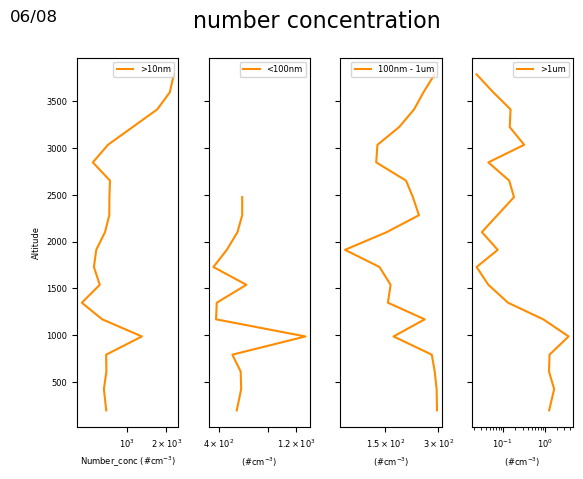

In [38]:
fig, ax = plt.subplots(1, 4, sharey='all')
plt.rcParams['font.size'] = '6'
ax[0].plot(DAY8_subset_mean['CNgt10nm_ZIEMBA'], DAY8_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label=">10nm")
ax[1].plot(DAY8_subset_mean['nSMPS_ZIEMBA'], DAY8_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label="<100nm")
ax[2].plot(DAY8_subset_mean['IntegN_100to1000nm_LAS_ZIEMBA'], DAY8_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label="100nm - 1um")
ax[3].plot(DAY8_subset_mean['IntegN_gt1000nm_LAS_ZIEMBA'], DAY8_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label='>1um')
ax[0].set_ylabel('Altitude')
ax[0].set_xlabel('Number_conc (#cm$^{-3}$)')
ax[1].set_xlabel('(#cm$^{-3}$)')
ax[2].set_xlabel('(#cm$^{-3}$)')
ax[3].set_xlabel('(#cm$^{-3}$)')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[3].set_xscale('log')
ax[0].legend(loc='upper right', fontsize=6)
ax[1].legend(loc='upper right', fontsize=6)
ax[2].legend(loc='upper right', fontsize=6)
ax[3].legend(loc='upper right', fontsize=6)
# Limit the number of tickers for the second plot
ax[0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=2))
ax[0].xaxis.set_minor_locator(ticker.NullLocator())

# Reduce the number of x-axis tickers to 2 for ax[1]
ax[1].xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
ax[1].xaxis.set_minor_locator(ticker.NullLocator())

# Reduce the number of x-axis tickers to 2 for ax[2]
ax[2].xaxis.set_major_locator(ticker.MaxNLocator(nbins=2))
ax[2].xaxis.set_minor_locator(ticker.NullLocator())

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)



fig.text(0.02, 0.98, '06/08', ha='left', va='top', fontsize=12)

# Set the title
fig.suptitle('number concentration', fontsize=16)

plt.show()

Text(0.5, 0.98, 'Volume concentration')

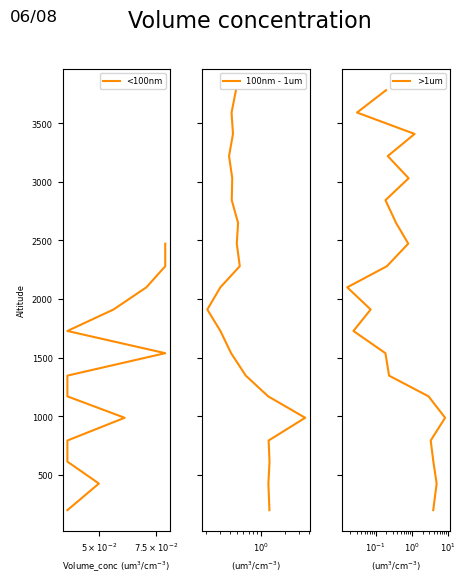

In [39]:
fig, ax = plt.subplots(1, 3, figsize=(5, 6), sharey='all')
plt.rcParams['font.size'] = '6'
ax[0].plot(DAY8_subset_mean['vSMPS_ZIEMBA'], DAY8_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label="<100nm")
ax[1].plot(DAY8_subset_mean['IntegV_100to1000nm_LAS_ZIEMBA'], DAY8_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label='100nm - 1um')
ax[2].plot(DAY8_subset_mean['IntegV_gt1000nm_LAS_ZIEMBA'], DAY8_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label='>1um')
ax[0].set_ylabel('Altitude')
ax[0].set_xlabel('Volume_conc (um$^{3}$/cm$^{-3}$)')
ax[1].set_xlabel('(um$^{3}$/cm$^{-3}$)')
ax[2].set_xlabel('(um$^{3}$/cm$^{-3}$)')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[0].legend(loc='upper right', fontsize=6)
ax[1].legend(loc='upper right', fontsize=6)
ax[2].legend(loc='upper right', fontsize=6)
# Limit the number of tickers for the second plot
ax[0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=2))
ax[0].xaxis.set_minor_locator(ticker.NullLocator())

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)
fig.text(0.02, 0.98, '06/08', ha='left', va='top', fontsize=12)
fig.suptitle('Volume concentration', fontsize=16)

In [40]:
DAY10 = simple_read('C:/Users/taiwoajayi/Documents/Intvol/activate-mrg1_hu25_20220610_R0_L1_20230625T113224.ict')
start_index = np.where(DAY10["Time_Start"]==pd.to_datetime("2022-06-10 15:17:00"))
stop_index = np.where(DAY10["Time_Start"]==pd.to_datetime("2022-06-10 15:25:00"))
    
DAY10_subset = DAY10[start_index[0][0]:stop_index[0][0]]

# Print the modified subset dataframe
DAY10_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
10616,2022-06-10 15:17:00,2022-06-10 15:17:01,32.206691,-64.996969,122.040,409.305,361.145,151.345,155.525,29.045,2.060,1.165,18.325,8.925,266.97,1.91,0.02
10617,2022-06-10 15:17:01,2022-06-10 15:17:02,32.207809,-64.997169,122.105,411.580,359.050,153.430,147.990,27.425,1.790,0.520,4.100,1.085,266.97,1.91,0.02
10618,2022-06-10 15:17:02,2022-06-10 15:17:03,32.208928,-64.997370,122.170,399.215,353.340,150.835,146.185,26.465,1.735,1.690,10.250,2.510,266.97,1.91,0.02
10619,2022-06-10 15:17:03,2022-06-10 15:17:04,32.210048,-64.997569,122.240,398.195,354.425,152.940,132.950,20.625,1.290,3.775,32.405,9.555,266.97,1.91,0.02
10620,2022-06-10 15:17:04,2022-06-10 15:17:05,32.211167,-64.997768,122.315,407.955,366.450,156.080,136.395,22.455,1.535,3.770,34.750,10.620,266.97,1.91,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11091,2022-06-10 15:24:55,2022-06-10 15:24:56,32.207088,-65.031191,3540.260,2180.280,1647.380,618.145,146.510,10.260,0.355,0.000,0.000,0.000,NaN,NaN,NaN
11092,2022-06-10 15:24:56,2022-06-10 15:24:57,32.207061,-65.029663,3546.970,2121.320,1656.120,605.730,139.710,10.580,0.460,0.520,2.590,0.545,NaN,NaN,NaN
11093,2022-06-10 15:24:57,2022-06-10 15:24:58,32.207068,-65.028134,3553.620,2255.900,1672.590,609.245,141.455,10.405,0.425,0.520,2.590,0.545,NaN,NaN,NaN
11094,2022-06-10 15:24:58,2022-06-10 15:24:59,32.207109,-65.026603,3560.200,2365.720,1719.320,630.165,151.390,10.100,0.280,0.000,0.000,0.000,NaN,NaN,NaN


In [41]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY10_subset.GPS_Altitude_THORNHILL.min(), DAY10_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY10_subset['Bins'] = pd.cut(DAY10_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY10_subset_1000 = DAY10_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY10_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY10_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_10 = DAY10_subset_1000[start_index:stop_index]
DAY1000_subset_10

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
Bins,,,,,,,,,,,,,,,,,
"(122.04, 156.487]",2022-06-10 15:17:25.000,2022-06-10 15:17:26.000,32.234724,-65.001980,124.887449,409.857347,365.473878,167.540612,147.760918,25.826224,1.731939,2.213469,18.899694,6.36000,260.043235,1.939118,0.02
"(156.487, 190.934]",2022-06-10 15:17:52.500,2022-06-10 15:17:53.500,32.265712,-65.007683,173.583333,443.133333,391.013333,194.595000,156.047500,27.851667,1.889167,3.135833,26.340000,9.40000,245.560000,2.000000,0.02
"(190.934, 225.381]",2022-06-10 15:17:58.000,2022-06-10 15:17:59.000,32.271642,-65.009690,209.447000,402.188000,361.144000,163.289000,150.420000,26.514000,1.743000,2.772000,21.061000,6.19600,245.560000,2.000000,0.02
"(225.381, 259.828]",2022-06-10 15:18:03.000,2022-06-10 15:18:04.000,32.276778,-65.012305,244.213000,391.097000,343.746000,144.696000,132.424000,22.141000,1.348000,2.390000,16.365000,4.54500,245.560000,2.000000,0.02
"(259.828, 294.274]",2022-06-10 15:18:07.500,2022-06-10 15:18:08.500,32.281179,-65.015229,277.968750,402.511250,341.276250,140.898750,130.075000,23.123750,1.530000,2.950000,26.337500,8.68875,245.560000,2.000000,0.02
"(294.274, 328.721]",2022-06-10 15:18:12.000,2022-06-10 15:18:13.000,32.285265,-65.018732,312.805000,396.566000,349.938000,150.489000,131.478000,22.840000,1.421000,1.660000,13.775000,4.26400,245.560000,2.000000,0.02
"(328.721, 363.168]",2022-06-10 15:18:16.500,2022-06-10 15:18:17.500,32.288972,-65.022764,349.491250,428.630000,353.373750,159.208750,130.078750,21.852500,1.311250,1.526250,11.700000,3.63000,245.560000,2.000000,0.02
"(363.168, 397.615]",2022-06-10 15:18:20.500,2022-06-10 15:18:21.500,32.291902,-65.026748,383.632500,412.666250,355.063750,150.453750,129.445000,20.725000,1.251250,1.427500,9.785000,3.04250,245.560000,2.000000,0.02
"(397.615, 432.062]",2022-06-10 15:18:24.500,2022-06-10 15:18:25.500,32.294477,-65.031042,417.876250,394.001250,359.465000,140.488750,126.665000,19.502500,1.226250,0.845000,5.115000,1.25250,245.560000,2.000000,0.02


In [42]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY10_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY10_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY10_subset_3000 = DAY10_subset_1000[start_index:stop_index]
DAY10_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
Bins,,,,,,,,,,,,,,,,,
"(983.212, 1017.659]",2022-06-10 15:19:33.500000000,2022-06-10 15:19:34.500,32.275739,-65.106964,1001.980000,816.40500,681.297500,439.702500,235.10750,26.92625,1.26125,0.0000,0.000000,0.000000,NaN,NaN,NaN
"(1017.659, 1052.106]",2022-06-10 15:19:37.500000000,2022-06-10 15:19:38.500,32.271564,-65.108831,1036.932500,844.34500,696.487500,477.170000,231.68250,24.47750,1.02625,0.8450,11.340000,4.490000,518.74,4.9,0.05
"(1052.106, 1086.553]",2022-06-10 15:19:41.500000000,2022-06-10 15:19:42.500,32.267226,-65.110161,1072.345000,820.35875,687.312500,467.992500,246.37500,26.39000,1.03875,0.3250,1.022500,0.170000,518.74,4.9,0.05
"(1086.553, 1121.0]",2022-06-10 15:19:45.000000256,2022-06-10 15:19:46.000,32.263340,-65.110896,1103.926667,835.98000,685.116667,467.161667,252.21000,25.42500,0.91000,0.6050,3.516667,0.943333,518.74,4.9,0.05
"(1121.0, 1155.447]",2022-06-10 15:19:48.500000000,2022-06-10 15:19:49.500,32.259400,-65.111207,1135.605000,842.23375,672.272500,457.361250,232.05125,25.07000,0.97875,0.2575,2.261250,0.672500,518.74,4.9,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(3291.155, 3325.602]",2022-06-10 15:24:24.000000000,2022-06-10 15:24:25.000,32.223151,-65.072506,3308.126000,2395.74800,1764.822000,479.321000,95.34600,6.05400,0.16600,0.1040,0.821000,0.217000,NaN,NaN,NaN
"(3325.602, 3360.049]",2022-06-10 15:24:29.000000000,2022-06-10 15:24:30.000,32.218877,-65.067075,3344.326000,2468.00000,1826.082000,492.084000,103.48500,6.52400,0.17400,0.0000,0.000000,0.000000,NaN,NaN,NaN
"(3360.049, 3394.496]",2022-06-10 15:24:33.500000000,2022-06-10 15:24:34.500,32.215503,-65.061678,3377.567500,2509.79250,1836.887500,512.527500,93.87000,6.00250,0.21500,0.0000,0.000000,0.000000,NaN,NaN,NaN


In [43]:
nbins = 30
bins10 = np.linspace(DAY10_subset.GPS_Altitude_THORNHILL.min(), DAY10_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY10_subset['Bins'] = pd.cut(DAY10_subset['GPS_Altitude_THORNHILL'], bins10)
DAY10_subset_mean = DAY10_subset.groupby('Bins').mean()
DAY10_subset_mean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
Bins,,,,,,,,,,,,,,,,,
"(122.04, 236.863]",2022-06-10 15:17:31.000000000,2022-06-10 15:17:32.000000000,32.241455,-65.003324,138.328361,412.241721,367.260492,169.467377,148.561557,26.040000,1.744836,2.330656,19.608197,6.567869,256.265,1.955,0.02
"(236.863, 351.686]",2022-06-10 15:18:09.000000000,2022-06-10 15:18:10.000000000,32.282437,-65.016572,289.956667,398.615000,346.756667,147.755667,129.652667,22.184667,1.375000,2.405333,18.372000,5.538667,245.560,2.000,0.02
"(351.686, 466.509]",2022-06-10 15:18:23.500000000,2022-06-10 15:18:24.500000000,32.293700,-65.030069,409.005000,409.912857,355.305714,144.191071,131.730357,20.885357,1.279286,1.132143,9.455714,3.172500,245.560,2.000,0.02
"(466.509, 581.332]",2022-06-10 15:18:37.500000000,2022-06-10 15:18:38.500000000,32.300058,-65.046645,522.374643,428.058571,362.987500,143.580357,125.295714,18.595714,1.093571,1.631429,15.114286,4.972500,361.560,3.560,0.04
"(581.332, 696.155]",2022-06-10 15:18:51.500000000,2022-06-10 15:18:52.500000000,32.301288,-65.064674,638.021071,460.470000,393.506429,157.553929,127.634286,17.894643,0.975714,0.518571,4.952857,1.636071,361.560,3.560,0.04
"(696.155, 810.978]",2022-06-10 15:19:05.000000000,2022-06-10 15:19:06.000000000,32.297655,-65.081499,751.861923,559.168077,478.805000,210.950000,157.099615,19.846923,0.958846,0.520000,3.840769,1.103077,361.560,3.560,0.04
"(810.978, 925.801]",2022-06-10 15:19:18.000000000,2022-06-10 15:19:19.000000000,32.289623,-65.095296,864.329231,742.328846,609.698077,343.271923,209.070385,24.370769,1.018462,0.399231,3.469231,0.997692,361.560,3.560,0.04
"(925.801, 1040.624]",2022-06-10 15:19:31.000000000,2022-06-10 15:19:31.999999744,32.278159,-65.105354,979.653462,790.978462,664.678846,412.639231,227.692692,25.995769,1.158846,0.499231,4.494231,1.382308,NaN,NaN,NaN
"(1040.624, 1155.447]",2022-06-10 15:19:44.000000000,2022-06-10 15:19:45.000000000,32.264424,-65.110509,1094.993846,832.278077,681.948462,465.171538,243.717692,25.598077,0.984615,0.538846,4.516154,1.525769,518.740,4.900,0.05


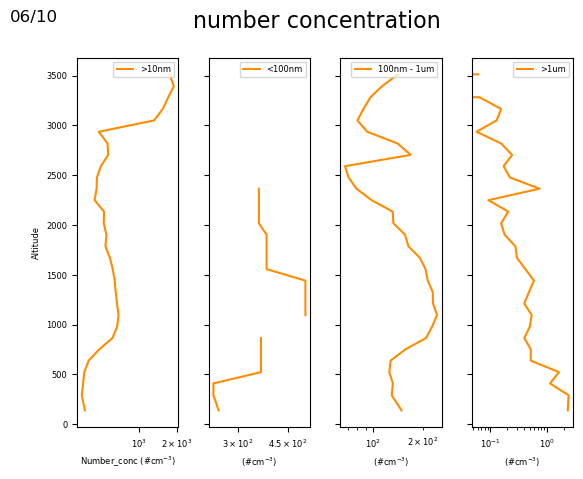

In [44]:
fig, ax = plt.subplots(1, 4, sharey='all')
plt.rcParams['font.size'] = '6'
ax[0].plot(DAY10_subset_mean['CNgt10nm_ZIEMBA'], DAY10_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label=">10nm")
ax[1].plot(DAY10_subset_mean['nSMPS_ZIEMBA'], DAY10_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label="<100nm")
ax[2].plot(DAY10_subset_mean['IntegN_100to1000nm_LAS_ZIEMBA'], DAY10_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label="100nm - 1um")
ax[3].plot(DAY10_subset_mean['IntegN_gt1000nm_LAS_ZIEMBA'], DAY10_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label='>1um')
ax[0].set_ylabel('Altitude')
ax[0].set_xlabel('Number_conc (#cm$^{-3}$)')
ax[1].set_xlabel('(#cm$^{-3}$)')
ax[2].set_xlabel('(#cm$^{-3}$)')
ax[3].set_xlabel('(#cm$^{-3}$)')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[3].set_xscale('log')
ax[0].legend(loc='upper right', fontsize=6)
ax[1].legend(loc='upper right', fontsize=6)
ax[2].legend(loc='upper right', fontsize=6)
ax[3].legend(loc='upper right', fontsize=6)
# Limit the number of tickers for the second plot
ax[0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=2))
ax[0].xaxis.set_minor_locator(ticker.NullLocator())

# Reduce the number of x-axis tickers to 2 for ax[1]
ax[1].xaxis.set_major_locator(ticker.MaxNLocator(nbins=2))
ax[1].xaxis.set_minor_locator(ticker.NullLocator())

# Reduce the number of x-axis tickers to 2 for ax[2]
#ax[2].xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
#ax[2].xaxis.set_minor_locator(ticker.NullLocator())

# Reduce the number of x-axis tickers to 2 for ax[3]
#ax[3].xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
#ax[3].xaxis.set_minor_locator(ticker.NullLocator())

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)



fig.text(0.02, 0.98, '06/10', ha='left', va='top', fontsize=12)

# Set the title
fig.suptitle('number concentration', fontsize=16)

plt.show()

Text(0.5, 0.98, 'Volume concentration')

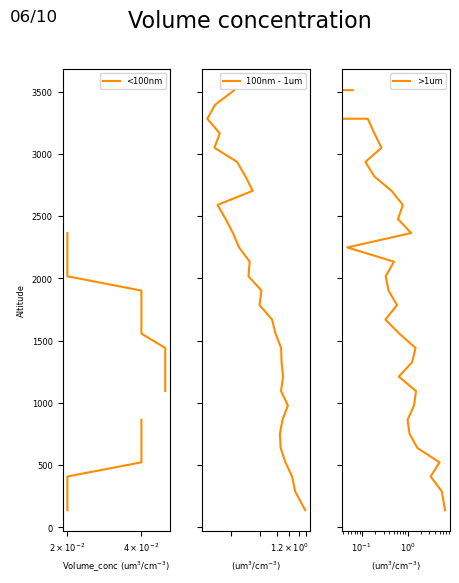

In [45]:
fig, ax = plt.subplots(1, 3, figsize=(5, 6), sharey='all')
plt.rcParams['font.size'] = '6'
ax[0].plot(DAY10_subset_mean['vSMPS_ZIEMBA'], DAY10_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label="<100nm")
ax[1].plot(DAY10_subset_mean['IntegV_100to1000nm_LAS_ZIEMBA'], DAY10_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label='100nm - 1um')
ax[2].plot(DAY10_subset_mean['IntegV_gt1000nm_LAS_ZIEMBA'], DAY10_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label='>1um')
ax[0].set_ylabel('Altitude')
ax[0].set_xlabel('Volume_conc (um$^{3}$/cm$^{-3}$)')
ax[1].set_xlabel('(um$^{3}$/cm$^{-3}$)')
ax[2].set_xlabel('(um$^{3}$/cm$^{-3}$)')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[0].legend(loc='upper right', fontsize=6)
ax[1].legend(loc='upper right', fontsize=6)
ax[2].legend(loc='upper right', fontsize=6)
# Limit the number of tickers for the second plot
ax[0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=2))
ax[0].xaxis.set_minor_locator(ticker.NullLocator())

# Reduce the number of x-axis tickers to 2 for ax[1]
ax[1].xaxis.set_major_locator(ticker.MaxNLocator(nbins=7))
ax[1].xaxis.set_minor_locator(ticker.NullLocator())

# Reduce the number of x-axis tickers to 2 for ax[2]
#ax[2].xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
#ax[2].xaxis.set_minor_locator(ticker.NullLocator())

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)
fig.text(0.02, 0.98, '06/10', ha='left', va='top', fontsize=12)
fig.suptitle('Volume concentration', fontsize=16)

In [46]:
DAY10b = simple_read('C:/Users/taiwoajayi/Documents/Intvol/activate-mrg1_hu25_20220610_R0_L2_20230625T113224.ict')
start_index = np.where(DAY10b["Time_Start"]==pd.to_datetime("2022-06-10 19:30:00"))
stop_index = np.where(DAY10b["Time_Start"]==pd.to_datetime("2022-06-10 20:45:00"))
    
DAY10b_subset = DAY10b[start_index[0][0]:stop_index[0][0]]

# Print the modified subset dataframe
DAY10b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
7182,2022-06-10 19:30:00,2022-06-10 19:30:01,31.639092,-65.606420,113.375,611.565,507.400,230.735,232.585,33.790,1.775,2.075,31.855,13.445,366.61,3.87,0.04
7183,2022-06-10 19:30:01,2022-06-10 19:30:02,31.639446,-65.607515,113.225,597.890,492.800,227.085,227.295,37.080,2.260,1.040,9.090,2.705,366.61,3.87,0.04
7184,2022-06-10 19:30:02,2022-06-10 19:30:03,31.639806,-65.608607,113.065,586.285,484.975,228.130,209.140,33.130,1.955,1.165,4.610,0.880,366.61,3.87,0.04
7185,2022-06-10 19:30:03,2022-06-10 19:30:04,31.640170,-65.609698,112.970,583.995,492.240,232.290,216.600,31.330,1.755,1.815,6.645,1.220,366.61,3.87,0.04
7186,2022-06-10 19:30:04,2022-06-10 19:30:05,31.640539,-65.610788,112.985,586.870,497.460,233.335,230.855,35.850,2.275,0.650,2.035,0.340,366.61,3.87,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11677,2022-06-10 20:44:55,2022-06-10 20:44:56,32.077748,-64.914861,1636.660,640.935,516.525,338.495,228.530,22.280,0.755,0.000,0.000,0.000,397.81,3.09,0.03
11678,2022-06-10 20:44:56,2022-06-10 20:44:57,32.078715,-64.913869,1630.380,628.485,522.420,337.785,218.175,20.665,0.715,0.520,6.490,2.160,397.81,3.09,0.03
11679,2022-06-10 20:44:57,2022-06-10 20:44:58,32.079681,-64.912880,1624.290,665.720,522.805,334.620,212.655,21.410,0.800,0.520,6.490,2.160,397.81,3.09,0.03
11680,2022-06-10 20:44:58,2022-06-10 20:44:59,32.080646,-64.911895,1618.170,656.970,520.830,329.075,236.105,24.755,0.965,0.000,0.000,0.000,397.81,3.09,0.03


In [47]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY10b_subset.GPS_Altitude_THORNHILL.min(), DAY10b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY10b_subset['Bins'] = pd.cut(DAY10b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY10b_subset_1000 = DAY10b_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY10b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY10b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_10b = DAY10b_subset_1000[start_index:stop_index]
DAY1000_subset_10b

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
Bins,,,,,,,,,,,,,,,,,
"(105.665, 154.556]",2022-06-10 19:58:30.078994432,2022-06-10 19:58:31.078994688,31.432104,-65.822952,121.109551,1259.921822,1001.964946,568.573178,251.388662,38.332029,2.295745,3.218824,28.825826,9.771598,1092.610958,7.158845,0.074201
"(154.556, 203.446]",2022-06-10 20:05:57.967741952,2022-06-10 20:05:58.967741952,31.357706,-65.882896,180.078387,672.818871,572.847097,287.117097,230.193710,36.326935,2.228226,2.726129,28.136935,10.065484,430.620323,4.883226,0.054839
"(203.446, 252.337]",2022-06-10 20:07:05.333333248,2022-06-10 20:07:06.333333504,31.358167,-65.882335,226.973333,663.526190,560.983810,281.793333,243.482619,39.370476,2.418571,3.885000,29.563333,8.898571,431.066667,4.869048,0.054762
"(252.337, 301.227]",2022-06-10 20:05:36.318181632,2022-06-10 20:05:37.318181888,31.385854,-65.887268,275.281136,661.129773,569.237500,292.122500,255.686136,41.559091,2.659773,2.990455,29.075682,10.450909,429.917273,4.853636,0.054545
"(301.227, 350.118]",2022-06-10 20:00:42.809523712,2022-06-10 20:00:43.809523712,31.488493,-65.882240,325.297857,676.180714,564.209286,292.778810,248.622143,38.551667,2.275476,3.536190,35.753810,12.636190,418.569412,4.547059,0.051176
"(350.118, 399.008]",2022-06-10 19:59:54.944444416,2022-06-10 19:59:55.944444416,31.522585,-65.877189,375.466944,647.893889,554.432222,288.708333,229.224722,36.584444,2.224722,3.163333,30.207222,10.640000,432.260000,4.260000,0.050000
"(399.008, 447.899]",2022-06-10 20:00:48.157894656,2022-06-10 20:00:49.157894912,31.494981,-65.885690,424.339474,659.267368,560.468158,294.572895,258.395789,41.628947,2.584737,3.605526,37.975789,14.466316,394.614286,3.955714,0.045714
"(447.899, 496.789]",2022-06-10 20:00:51.368421120,2022-06-10 20:00:52.368421120,31.501844,-65.883638,473.128158,685.970263,581.175526,311.374737,259.506842,40.246579,2.456842,3.759474,35.266053,12.383421,1207.984286,4.271429,0.043571
"(496.789, 545.68]",2022-06-10 20:02:18.277777920,2022-06-10 20:02:19.277777920,31.488428,-65.880187,521.287778,675.633611,577.033333,305.846944,263.038333,40.455278,2.428333,3.943056,36.041111,12.297222,1380.697143,4.415714,0.044286


In [48]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY10b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY10b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY10b_subset_3000 = DAY10b_subset_1000[start_index:stop_index]
DAY10b_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
count,50,50,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,2022-06-10 20:07:34.749670400,2022-06-10 20:07:35.749670400,31.508025,-65.767047,2207.934501,1529.465963,1066.190730,543.806347,293.671641,38.199469,2.085364,1.217180,10.674071,3.593706,862.904211,4.610992,0.046556
min,2022-06-10 19:56:57.444444416,2022-06-10 19:56:58.444444672,31.218992,-65.949112,1011.126667,654.251304,502.158333,278.137708,114.245000,7.974524,0.233095,0.049524,0.203750,0.034000,304.795000,2.955714,0.031304
25%,2022-06-10 20:04:50.338949632,2022-06-10 20:04:51.338949632,31.404345,-65.877020,1611.398305,710.531202,562.987854,357.695893,165.208319,17.156498,0.711207,0.185915,1.580897,0.475857,402.128346,3.410841,0.036205
50%,2022-06-10 20:08:06.340952320,2022-06-10 20:08:07.340952576,31.556393,-65.744984,2206.686000,800.910310,654.803643,394.798676,240.885716,24.495114,1.023517,0.613518,5.718568,1.758300,499.640000,3.646147,0.038750
75%,2022-06-10 20:10:48.834542848,2022-06-10 20:10:49.834542848,31.596532,-65.692428,2809.107242,1939.474707,1336.313827,517.448964,265.370521,34.139649,1.883297,1.543773,14.881914,5.314373,1184.461080,4.130758,0.042492
max,2022-06-10 20:15:26.571428608,2022-06-10 20:15:27.571428608,31.716792,-65.539598,3409.206667,4728.704133,3013.296406,1728.543320,1849.998600,378.333800,26.887200,12.418200,95.994800,30.275400,3475.979888,18.571053,0.171316
std,NaN,NaN,0.144690,0.106499,712.474631,1256.534110,761.532057,364.234579,292.753027,56.547157,3.985417,1.933667,15.705160,5.139103,747.903207,2.907917,0.024735


In [49]:
nbins = 30
bins10b = np.linspace(DAY10b_subset.GPS_Altitude_THORNHILL.min(), DAY10b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY10b_subset['Bins'] = pd.cut(DAY10b_subset['GPS_Altitude_THORNHILL'], bins10b)
DAY10b_subset_mean= DAY10b_subset.groupby('Bins').mean()
DAY10b_subset_mean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
Bins,,,,,,,,,,,,,,,,,
"(105.665, 268.634]",2022-06-10 19:59:15.001620736,2022-06-10 19:59:16.001620736,31.425164,-65.828878,129.477715,1202.316167,959.843412,541.091386,250.198120,38.319279,2.302472,3.228063,28.859190,9.768201,1007.573983,6.866231,0.071713
"(268.634, 431.602]",2022-06-10 20:01:46.984848384,2022-06-10 20:01:47.984848640,31.476984,-65.881638,348.163258,660.865606,560.708333,291.593485,245.963788,39.184773,2.391591,3.198636,33.141591,12.099848,425.363590,4.587436,0.052051
"(431.602, 594.57]",2022-06-10 20:08:21.057692160,2022-06-10 20:08:22.057692160,31.374756,-65.897839,544.127115,1728.012740,1311.784231,801.001538,221.046538,33.570000,2.055096,2.903510,26.352067,9.048702,1445.259143,4.447857,0.044571
"(594.57, 757.539]",2022-06-10 20:11:13.524999936,2022-06-10 20:11:14.525000192,31.349422,-65.897509,635.586156,2711.703594,2001.650563,1262.249344,178.668313,25.036844,1.461562,1.299719,12.657406,4.416188,2192.755403,5.786532,0.051452
"(757.539, 920.507]",2022-06-10 20:00:20.028985600,2022-06-10 20:00:21.028985600,31.542150,-65.870960,832.953768,718.912754,602.644130,316.830145,219.120725,33.875435,2.087899,3.576957,36.287101,13.060580,407.795082,3.789180,0.043607
"(920.507, 1083.476]",2022-06-10 19:59:56.844827392,2022-06-10 19:59:57.844827392,31.536779,-65.872991,1005.576897,709.533707,594.780086,307.661724,251.113793,37.033362,2.212328,3.272500,30.123448,10.313448,365.204651,3.589767,0.041395
"(1083.476, 1246.444]",2022-06-10 20:10:27.914285568,2022-06-10 20:10:28.914285568,31.277652,-65.923448,1207.062457,2954.279657,2136.743829,1304.420657,320.123857,44.856600,2.647114,2.358086,21.703857,7.500771,3092.137462,13.133231,0.114846
"(1246.444, 1409.413]",2022-06-10 20:04:34.531249920,2022-06-10 20:04:35.531249920,31.350788,-65.907727,1316.439375,784.194896,645.929531,348.853333,257.314948,34.066302,1.816927,2.280156,22.108854,7.908177,850.570417,4.599722,0.045694
"(1409.413, 1572.382]",2022-06-10 20:01:58.392156672,2022-06-10 20:01:59.392156672,31.464150,-65.872754,1481.577059,817.969706,655.928333,414.416863,266.024510,31.881863,1.522745,1.344020,13.478235,4.704510,546.796000,3.939333,0.041333


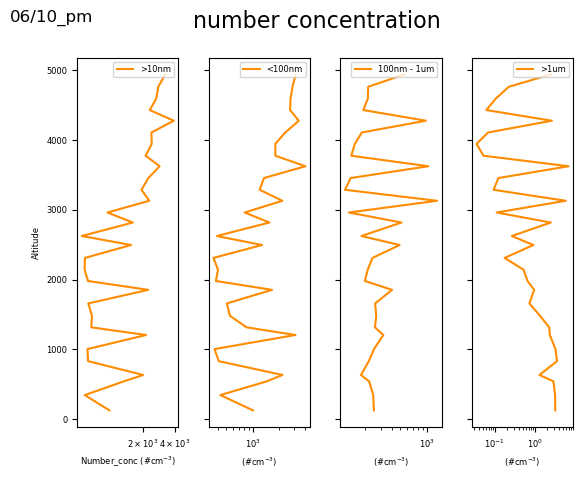

In [50]:
fig, ax = plt.subplots(1, 4, sharey='all')
plt.rcParams['font.size'] = '6'
ax[0].plot(DAY10b_subset_mean['CNgt10nm_ZIEMBA'], DAY10b_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label=">10nm")
ax[1].plot(DAY10b_subset_mean['nSMPS_ZIEMBA'], DAY10b_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label="<100nm")
ax[2].plot(DAY10b_subset_mean['IntegN_100to1000nm_LAS_ZIEMBA'], DAY10b_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label="100nm - 1um")
ax[3].plot(DAY10b_subset_mean['IntegN_gt1000nm_LAS_ZIEMBA'], DAY10b_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label='>1um')
ax[0].set_ylabel('Altitude')
ax[0].set_xlabel('Number_conc (#cm$^{-3}$)')
ax[1].set_xlabel('(#cm$^{-3}$)')
ax[2].set_xlabel('(#cm$^{-3}$)')
ax[3].set_xlabel('(#cm$^{-3}$)')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[3].set_xscale('log')
ax[0].legend(loc='upper right', fontsize=6)
ax[1].legend(loc='upper right', fontsize=6)
ax[2].legend(loc='upper right', fontsize=6)
ax[3].legend(loc='upper right', fontsize=6)
# Limit the number of tickers for the second plot
ax[0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=2))
ax[0].xaxis.set_minor_locator(ticker.NullLocator())

# Reduce the number of x-axis tickers to 2 for ax[1]
#ax[1].xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
#ax[1].xaxis.set_minor_locator(ticker.NullLocator())

# Reduce the number of x-axis tickers to 2 for ax[2]
#ax[2].xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
#ax[2].xaxis.set_minor_locator(ticker.NullLocator())

# Reduce the number of x-axis tickers to 2 for ax[3]
#ax[3].xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
#ax[3].xaxis.set_minor_locator(ticker.NullLocator())

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)



fig.text(0.02, 0.98, '06/10_pm', ha='left', va='top', fontsize=12)

# Set the title
fig.suptitle('number concentration', fontsize=16)

plt.show()

Text(0.5, 0.98, 'Volume concentration')

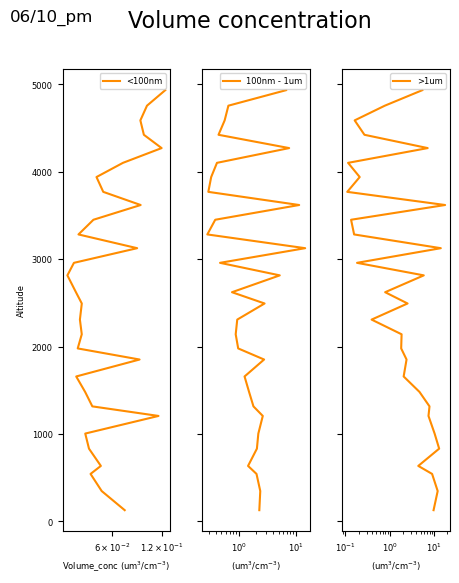

In [51]:
fig, ax = plt.subplots(1, 3, figsize=(5, 6), sharey='all')
plt.rcParams['font.size'] = '6'
ax[0].plot(DAY10b_subset_mean['vSMPS_ZIEMBA'], DAY10b_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label="<100nm")
ax[1].plot(DAY10b_subset_mean['IntegV_100to1000nm_LAS_ZIEMBA'], DAY10b_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label='100nm - 1um')
ax[2].plot(DAY10b_subset_mean['IntegV_gt1000nm_LAS_ZIEMBA'], DAY10b_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label='>1um')
ax[0].set_ylabel('Altitude')
ax[0].set_xlabel('Volume_conc (um$^{3}$/cm$^{-3}$)')
ax[1].set_xlabel('(um$^{3}$/cm$^{-3}$)')
ax[2].set_xlabel('(um$^{3}$/cm$^{-3}$)')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[0].legend(loc='upper right', fontsize=6)
ax[1].legend(loc='upper right', fontsize=6)
ax[2].legend(loc='upper right', fontsize=6)
# Limit the number of tickers for the second plot
ax[0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=2))
ax[0].xaxis.set_minor_locator(ticker.NullLocator())

# Reduce the number of x-axis tickers to 2 for ax[1]
#ax[1].xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
#ax[1].xaxis.set_minor_locator(ticker.NullLocator())

# Reduce the number of x-axis tickers to 2 for ax[2]
#ax[2].xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
#ax[2].xaxis.set_minor_locator(ticker.NullLocator())

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)
fig.text(0.02, 0.98, '06/10_pm', ha='left', va='top', fontsize=12)
fig.suptitle('Volume concentration', fontsize=16)

In [52]:
DAY11 = simple_read('C:/Users/taiwoajayi/Documents/Intvol/activate-mrg1_hu25_20220611_R0_L1_20230625T113225.ict')
start_index = np.where(DAY11["Time_Start"]==pd.to_datetime("2022-06-11 15:24:00"))
stop_index = np.where(DAY11["Time_Start"]==pd.to_datetime("2022-06-11 15:42:00"))
    
DAY11_subset = DAY11[start_index[0][0]:stop_index[0][0]]

# Print the modified subset dataframe
DAY11_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
10800,2022-06-11 15:24:00,2022-06-11 15:24:01,32.234864,-64.977277,137.985,570.305,472.755,280.630,203.280,35.680,2.275,4.795,34.920,10.045,384.25,3.83,0.04
10801,2022-06-11 15:24:01,2022-06-11 15:24:02,32.233969,-64.976649,138.245,571.280,475.925,279.095,213.080,34.770,1.980,4.675,61.550,25.295,384.25,3.83,0.04
10802,2022-06-11 15:24:02,2022-06-11 15:24:03,32.233058,-64.976063,138.485,592.070,471.715,281.675,219.790,33.540,1.795,5.855,81.905,32.680,384.25,3.83,0.04
10803,2022-06-11 15:24:03,2022-06-11 15:24:04,32.232130,-64.975521,138.740,585.790,480.600,285.860,225.220,37.420,2.330,3.780,42.540,14.415,384.25,3.83,0.04
10804,2022-06-11 15:24:04,2022-06-11 15:24:05,32.231186,-64.975026,139.035,596.485,486.965,285.405,211.195,39.365,2.650,1.040,14.395,5.395,384.25,3.83,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11875,2022-06-11 15:41:55,2022-06-11 15:41:56,32.259305,-64.971567,4701.700,6461.360,4147.040,2570.110,295.865,19.370,0.685,0.000,0.000,0.000,4487.02,20.55,0.20
11876,2022-06-11 15:41:56,2022-06-11 15:41:57,32.258543,-64.970428,4708.440,6369.690,4150.430,2563.510,297.635,17.475,0.475,0.000,0.000,0.000,4487.02,20.55,0.20
11877,2022-06-11 15:41:57,2022-06-11 15:41:58,32.257745,-64.969326,4714.800,6517.780,4152.750,2599.840,303.855,18.250,0.485,0.000,0.000,0.000,4487.02,20.55,0.20
11878,2022-06-11 15:41:58,2022-06-11 15:41:59,32.256913,-64.968261,4720.960,6580.560,4119.770,2644.700,290.060,17.065,0.440,0.000,0.000,0.000,4487.02,20.55,0.20


In [53]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY11_subset.GPS_Altitude_THORNHILL.min(), DAY11_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY11_subset['Bins'] = pd.cut(DAY11_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY11_subset_1000 = DAY11_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY11_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY11_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_11 = DAY11_subset_1000[start_index:stop_index]
DAY1000_subset_11


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
Bins,,,,,,,,,,,,,,,,,
"(137.295, 183.191]",2022-06-11 15:24:38.129870080,2022-06-11 15:24:39.129870080,32.204798,-64.988412,141.553312,574.065260,450.720974,263.330649,199.423247,33.260779,2.000779,2.652208,26.909740,9.667792,292.268361,3.014918,0.032787
"(183.191, 229.087]",2022-06-11 15:25:26.500000000,2022-06-11 15:25:27.500000000,32.202954,-65.032135,206.207778,419.913333,327.365278,183.220278,173.133889,29.300556,1.861111,3.026944,29.176111,9.782500,173.590000,1.570000,0.020000
"(229.087, 274.983]",2022-06-11 15:25:52.000000000,2022-06-11 15:25:53.000000000,32.228031,-65.036850,245.256061,408.797576,316.172879,176.476667,170.294545,29.720455,1.931818,2.730909,30.343182,11.129242,173.590000,1.570000,0.020000
"(274.983, 320.88]",2022-06-11 15:26:15.000000000,2022-06-11 15:26:16.000000000,32.246544,-65.020245,296.365000,365.216154,289.541923,151.219615,152.460769,24.534231,1.469615,1.886154,17.676154,6.060769,173.590000,1.570000,0.020000
"(320.88, 366.776]",2022-06-11 15:26:29.000000000,2022-06-11 15:26:30.000000000,32.249193,-65.003673,343.615333,344.269000,269.662333,141.894000,149.266667,23.037333,1.342333,1.730333,16.007333,5.855000,160.940000,1.820000,0.020000
"(366.776, 412.672]",2022-06-11 15:26:42.500000000,2022-06-11 15:26:43.500000000,32.245849,-64.988606,392.922917,388.340000,295.117500,146.172917,157.787500,22.972500,1.182083,2.898750,27.386667,9.417083,160.940000,1.820000,0.020000
"(412.672, 458.568]",2022-06-11 15:26:58.000000000,2022-06-11 15:26:59.000000000,32.235916,-64.976487,435.027105,367.778158,283.237632,156.537105,156.216053,26.702895,1.823947,3.426842,39.999474,15.366842,160.940000,1.820000,0.020000
"(458.568, 504.464]",2022-06-11 15:27:15.500000000,2022-06-11 15:27:16.500000000,32.220892,-64.971716,479.601875,351.486875,274.016563,158.279687,155.621875,27.475938,1.951250,4.163125,46.838437,18.074375,160.940000,1.820000,0.020000
"(504.464, 550.36]",2022-06-11 15:27:29.500000000,2022-06-11 15:27:30.500000000,32.208667,-64.976034,527.068750,356.187917,275.795000,160.309583,151.367500,27.718333,2.065417,3.265000,33.352083,12.069583,155.530000,1.910000,0.020000


In [54]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY11_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY11_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY11_subset_3000 = DAY11_subset_1000[start_index:stop_index]
DAY11_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
Bins,,,,,,,,,,,,,,,,,
"(1009.322, 1055.218]",2022-06-11 15:29:30.500000000,2022-06-11 15:29:31.500000000,32.257405,-64.988247,1035.389286,367.613214,279.336786,166.983571,144.021071,28.241429,2.208214,5.650714,57.685000,20.987143,126.75,1.46,0.02
"(1055.218, 1101.114]",2022-06-11 15:29:43.500000000,2022-06-11 15:29:44.500000000,32.250209,-64.974320,1074.022500,354.517917,270.005000,157.373750,132.068333,22.047500,1.535833,3.275833,36.317083,13.796667,126.75,1.46,0.02
"(1101.114, 1147.01]",2022-06-11 15:29:57.500000000,2022-06-11 15:29:58.500000000,32.237558,-64.966375,1125.470625,345.634375,257.279375,137.340313,124.429375,19.794375,1.365938,2.310625,20.451250,6.712500,126.75,1.46,0.02
"(1147.01, 1192.906]",2022-06-11 15:30:12.500000000,2022-06-11 15:30:13.500000000,32.222628,-64.967036,1170.586429,360.263214,270.163214,152.562857,128.416071,23.138214,1.756786,2.049643,23.603571,8.975357,126.75,1.46,0.02
"(1192.906, 1238.803]",2022-06-11 15:30:26.000000000,2022-06-11 15:30:27.000000000,32.211306,-64.975437,1213.892308,390.967308,289.081538,162.637308,124.655769,21.118462,1.552308,2.995000,31.803846,11.576154,208.14,2.62,0.03
"(1238.803, 1284.699]",2022-06-11 15:30:37.500000000,2022-06-11 15:30:38.500000000,32.205044,-64.986735,1261.504000,377.297000,282.138500,163.627000,131.307000,22.712500,1.722500,2.388000,29.328000,11.150500,208.14,2.62,0.03
"(1284.699, 1330.595]",2022-06-11 15:30:48.000000000,2022-06-11 15:30:49.000000000,32.203083,-64.998878,1309.650000,401.052727,300.179091,179.272273,144.170909,25.889091,1.987727,4.652727,50.138182,18.810909,208.14,2.62,0.03
"(1330.595, 1376.491]",2022-06-11 15:30:59.999999744,2022-06-11 15:31:01.000000000,32.205292,-65.012958,1354.406154,444.717308,328.567308,212.666923,163.432308,33.518846,2.788846,6.798462,73.394615,27.690769,208.14,2.62,0.03
"(1376.491, 1422.387]",2022-06-11 15:31:12.500000000,2022-06-11 15:31:13.500000000,32.212001,-65.026047,1397.715000,531.932500,389.431667,253.218333,173.637083,29.888750,2.202500,6.033333,63.385833,23.023333,208.14,2.62,0.03


In [55]:
nbins = 30
bins11 = np.linspace(DAY11_subset.GPS_Altitude_THORNHILL.min(), DAY11_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY11_subset['Bins'] = pd.cut(DAY11_subset['GPS_Altitude_THORNHILL'], bins11)
DAY11_subset_mean = DAY11_subset.groupby('Bins').mean()
DAY11_subset_mean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
Bins,,,,,,,,,,,,,,,,,
"(137.295, 290.282]",2022-06-11 15:25:06.496240640,2022-06-11 15:25:07.496240640,32.211814,-65.007714,181.377594,505.058684,395.014135,227.240263,186.630714,31.542143,1.948459,2.695940,27.654699,9.874850,243.875243,2.425728,0.027573
"(290.282, 443.269]",2022-06-11 15:26:37.500000000,2022-06-11 15:26:38.500000000,32.245155,-64.995268,372.151771,362.853542,282.522500,146.754792,153.567917,23.753333,1.390521,2.433333,25.267188,9.324792,162.090000,1.797273,0.020000
"(443.269, 596.256]",2022-06-11 15:27:23.500000000,2022-06-11 15:27:24.500000000,32.214431,-64.975954,510.426818,358.262159,276.617727,160.161023,154.948636,27.869773,2.029659,3.798068,43.010455,16.369432,158.328276,1.863448,0.020000
"(596.256, 749.244]",2022-06-11 15:28:00.500000000,2022-06-11 15:28:01.500000000,32.198700,-65.006314,663.759667,362.213000,277.974667,158.809167,143.125333,26.273833,1.952833,3.511667,34.598000,12.263833,155.530000,1.910000,0.020000
"(749.244, 902.231]",2022-06-11 15:28:34.500000000,2022-06-11 15:28:35.500000000,32.222391,-65.031718,836.737895,347.766974,262.013026,144.769342,138.063289,23.285395,1.632237,3.433816,34.283684,12.431184,143.305652,1.785652,0.020000
"(902.231, 1055.218]",2022-06-11 15:29:15.500000000,2022-06-11 15:29:16.500000000,32.254845,-65.006887,976.859773,350.429318,267.207955,150.710000,129.402273,22.685000,1.652500,3.718977,38.867614,14.086364,139.439655,1.713793,0.020000
"(1055.218, 1208.205]",2022-06-11 15:30:01.000000256,2022-06-11 15:30:02.000000000,32.233851,-64.969209,1133.821702,355.814681,267.428723,149.697447,127.925532,21.756702,1.579468,2.462660,25.173298,9.138936,126.750000,1.460000,0.020000
"(1208.205, 1361.192]",2022-06-11 15:30:43.000000000,2022-06-11 15:30:44.000000000,32.205279,-64.993412,1285.365405,400.892027,297.585811,176.969595,139.946081,24.998649,1.915000,4.077027,45.404730,17.020405,208.140000,2.620000,0.030000
"(1361.192, 1514.18]",2022-06-11 15:31:19.500000000,2022-06-11 15:31:20.500000000,32.218507,-65.030435,1431.766944,610.517083,452.562917,272.122222,187.850972,32.460833,2.409583,6.174028,68.180694,25.625694,224.574286,2.600000,0.030000


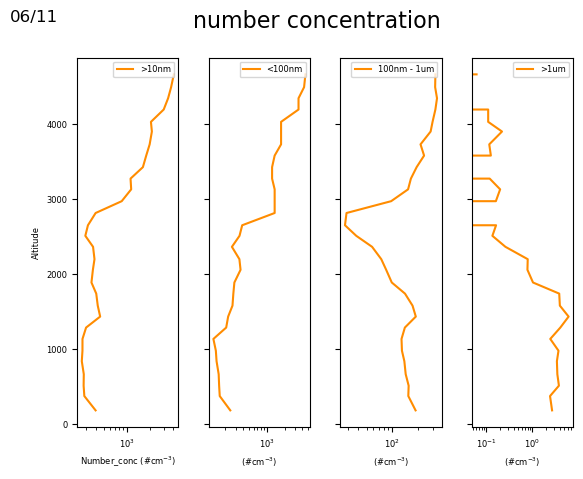

In [56]:
fig, ax = plt.subplots(1, 4, sharey='all')
plt.rcParams['font.size'] = '6'
ax[0].plot(DAY11_subset_mean['CNgt10nm_ZIEMBA'], DAY11_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label=">10nm")
ax[1].plot(DAY11_subset_mean['nSMPS_ZIEMBA'], DAY11_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label="<100nm")
ax[2].plot(DAY11_subset_mean['IntegN_100to1000nm_LAS_ZIEMBA'], DAY11_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label="100nm - 1um")
ax[3].plot(DAY11_subset_mean['IntegN_gt1000nm_LAS_ZIEMBA'], DAY11_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label='>1um')
ax[0].set_ylabel('Altitude')
ax[0].set_xlabel('Number_conc (#cm$^{-3}$)')
ax[1].set_xlabel('(#cm$^{-3}$)')
ax[2].set_xlabel('(#cm$^{-3}$)')
ax[3].set_xlabel('(#cm$^{-3}$)')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[3].set_xscale('log')
ax[0].legend(loc='upper right', fontsize=6)
ax[1].legend(loc='upper right', fontsize=6)
ax[2].legend(loc='upper right', fontsize=6)
ax[3].legend(loc='upper right', fontsize=6)
# Limit the number of tickers for the second plot
#ax[0].set_xlim([300, 500])
#ax[2].set_xlim([100, 300])
#ax[3].set_xlim([0, 2])

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)



fig.text(0.02, 0.98, '06/11', ha='left', va='top', fontsize=12)

# Set the title
fig.suptitle('number concentration', fontsize=16)

plt.show()

Text(0.5, 0.98, 'Volume_concentration')

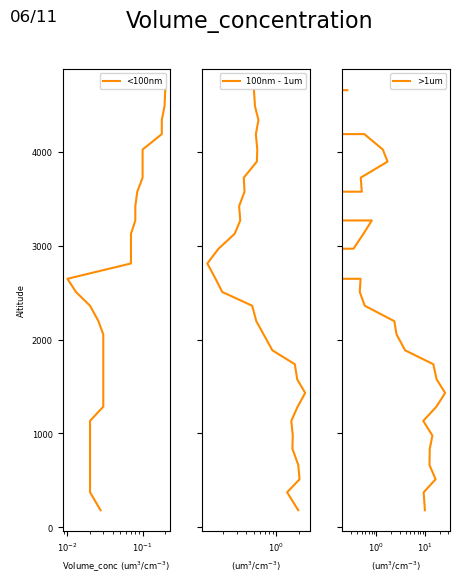

In [57]:
fig, ax = plt.subplots(1, 3, figsize=(5, 6), sharey='all')
plt.rcParams['font.size'] = '6'
ax[0].plot(DAY11_subset_mean['vSMPS_ZIEMBA'], DAY11_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label="<100nm")
ax[1].plot(DAY11_subset_mean['IntegV_100to1000nm_LAS_ZIEMBA'], DAY11_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label='100nm - 1um')
ax[2].plot(DAY11_subset_mean['IntegV_gt1000nm_LAS_ZIEMBA'], DAY11_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label='>1um')
ax[0].set_ylabel('Altitude')
ax[0].set_xlabel('Volume_conc (um$^{3}$/cm$^{-3}$)')
ax[1].set_xlabel('(um$^{3}$/cm$^{-3}$)')
ax[2].set_xlabel('(um$^{3}$/cm$^{-3}$)')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[0].legend(loc='upper right', fontsize=6)
ax[1].legend(loc='upper right', fontsize=6)
ax[2].legend(loc='upper right', fontsize=6)
# Limit the number of tickers for the second plot

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)
fig.text(0.02, 0.98, '06/11', ha='left', va='top', fontsize=12)
fig.suptitle('Volume_concentration', fontsize=16)

In [58]:
DAY11b = simple_read('C:/Users/taiwoajayi/Documents/Intvol/activate-mrg1_hu25_20220611_R0_L2_20230625T113225.ict')
start_index = np.where(DAY11b["Time_Start"]==pd.to_datetime("2022-06-11 20:00:00"))
stop_index = np.where(DAY11b["Time_Start"]==pd.to_datetime("2022-06-11 20:30:00"))
    
DAY11b_subset = DAY11b[start_index[0][0]:stop_index[0][0]]
start_col2 = 'CNgt3nm_ZIEMBA'

# Print the modified subset dataframe
DAY11b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
9350,2022-06-11 20:00:00,2022-06-11 20:00:01,30.851085,-64.222657,132.360,580.765,417.505,197.360,227.390,29.645,1.410,1.035,6.67,1.620,268.27,3.17,0.04
9351,2022-06-11 20:00:01,2022-06-11 20:00:02,30.851840,-64.221712,132.715,564.505,418.620,194.805,232.230,28.595,1.300,1.555,10.78,2.705,268.27,3.17,0.04
9352,2022-06-11 20:00:02,2022-06-11 20:00:03,30.852625,-64.220800,133.040,528.245,412.510,191.230,243.930,31.500,1.580,2.725,18.44,4.670,268.27,3.17,0.04
9353,2022-06-11 20:00:03,2022-06-11 20:00:04,30.853437,-64.219921,133.300,530.795,410.455,197.455,236.310,29.410,1.290,3.770,27.56,7.385,268.27,3.17,0.04
9354,2022-06-11 20:00:04,2022-06-11 20:00:05,30.854278,-64.219077,133.540,558.825,411.490,202.115,226.195,28.600,1.430,1.565,13.23,3.800,268.27,3.17,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11145,2022-06-11 20:29:55,2022-06-11 20:29:56,31.260152,-64.521769,3323.730,951.830,644.390,351.680,110.150,7.585,0.240,0.520,10.27,4.300,656.31,4.37,0.04
11146,2022-06-11 20:29:56,2022-06-11 20:29:57,31.261412,-64.522059,3325.020,911.515,641.825,340.945,112.660,6.780,0.175,0.000,0.00,0.000,656.31,4.37,0.04
11147,2022-06-11 20:29:57,2022-06-11 20:29:58,31.262673,-64.522348,3326.270,938.275,633.115,338.780,113.810,8.010,0.340,0.000,0.00,0.000,656.31,4.37,0.04
11148,2022-06-11 20:29:58,2022-06-11 20:29:59,31.263934,-64.522638,3327.430,892.660,610.575,332.975,129.485,8.975,0.365,0.000,0.00,0.000,656.31,4.37,0.04


In [59]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY11b_subset.GPS_Altitude_THORNHILL.min(), DAY11b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY11b_subset['Bins'] = pd.cut(DAY11b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY11b_subset_1000 = DAY11b_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY11b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY11b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_11b = DAY11b_subset_1000[start_index:stop_index]
DAY1000_subset_11b


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
Bins,,,,,,,,,,,,,,,,,
"(108.925, 141.12]",2022-06-11 20:04:07.512096768,2022-06-11 20:04:08.512096768,31.035566,-64.424176,123.488034,601.471240,469.945131,246.942994,210.593115,29.393438,1.606129,1.846562,16.081220,5.354163,338.827846,3.792207,0.043564
"(141.12, 173.315]",2022-06-11 20:08:18.500000000,2022-06-11 20:08:19.500000000,31.221775,-64.662991,155.437500,529.282500,414.702500,174.451250,118.333750,20.571250,1.402500,1.947500,15.333750,4.921250,167.920000,1.720000,0.020000
"(173.315, 205.51]",2022-06-11 20:08:22.500000000,2022-06-11 20:08:23.500000000,31.222161,-64.667873,188.907500,529.883750,400.030000,170.216250,107.126250,17.366250,1.086250,1.201250,12.325000,3.872500,167.920000,1.720000,0.020000
"(205.51, 237.706]",2022-06-11 20:08:26.500000000,2022-06-11 20:08:27.500000000,31.222612,-64.672638,223.777500,522.167500,388.778750,173.712500,136.412500,24.015000,1.538750,1.687500,20.352500,7.012500,167.920000,1.720000,0.020000
"(237.706, 269.901]",2022-06-11 20:08:30.000000000,2022-06-11 20:08:30.999999744,31.223105,-64.676702,256.585000,389.333333,288.705000,159.528333,155.790000,25.486667,1.638333,2.470000,16.995000,4.888333,167.920000,1.720000,0.020000
"(269.901, 302.096]",2022-06-11 20:08:33.500000000,2022-06-11 20:08:34.500000000,31.223615,-64.680669,288.658750,349.618750,282.858750,154.822500,133.141250,23.970000,1.573750,3.793750,40.955000,15.691250,167.920000,1.720000,0.020000
"(302.096, 334.291]",2022-06-11 20:08:38.500000000,2022-06-11 20:08:39.500000000,31.224804,-64.686121,320.795833,353.338333,272.165833,151.844167,138.798333,22.755833,1.510833,3.684167,40.714167,14.283333,167.920000,1.720000,0.020000
"(334.291, 366.486]",2022-06-11 20:08:43.500000000,2022-06-11 20:08:44.500000000,31.226848,-64.691161,351.048750,363.646250,274.748750,152.593750,158.388750,24.666250,1.516250,3.467500,28.938750,9.090000,NaN,NaN,NaN
"(366.486, 398.681]",2022-06-11 20:08:46.999999744,2022-06-11 20:08:48.000000000,31.228959,-64.694189,384.708333,357.885000,281.210000,155.101667,174.613333,30.993333,2.183333,4.326667,40.526667,13.666667,NaN,NaN,NaN


In [60]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY11b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY11b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY11b_subset_3000 = DAY11b_subset_1000[start_index:stop_index]
DAY11b_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
Bins,,,,,,,,,,,,,,,,,
"(1010.389, 1042.584]",2022-06-11 20:10:22.999999744,2022-06-11 20:10:24.000000000,31.228788,-64.661029,1025.980000,567.956667,442.405000,221.200000,177.373333,24.928333,1.678333,3.073333,34.210000,11.843333,299.900,3.300,0.040
"(1042.584, 1074.779]",2022-06-11 20:10:26.500000000,2022-06-11 20:10:27.500000000,31.226313,-64.664300,1058.642500,579.762500,437.156250,217.142500,152.767500,23.208750,1.596250,1.203750,9.168750,2.525000,299.900,3.300,0.040
"(1074.779, 1106.975]",2022-06-11 20:10:30.000000000,2022-06-11 20:10:30.999999744,31.224284,-64.667959,1091.333333,596.286667,452.388333,231.000000,156.460000,21.103333,1.158333,3.203333,31.448333,9.940000,299.900,3.300,0.040
"(1106.975, 1139.17]",2022-06-11 20:10:33.500000000,2022-06-11 20:10:34.500000000,31.222815,-64.671970,1121.872500,605.617500,461.275000,241.633750,157.903750,22.603750,1.372500,2.171250,23.997500,8.863750,299.900,3.300,0.040
"(1139.17, 1171.365]",2022-06-11 20:10:37.000000256,2022-06-11 20:10:38.000000000,31.221921,-64.676211,1153.480000,594.520000,458.148333,243.791667,176.243333,24.485000,1.508333,3.160000,25.521667,8.476667,299.900,3.300,0.040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(3135.269, 3167.464]",2022-06-11 20:18:06.769230848,2022-06-11 20:18:07.769230848,31.241240,-64.609057,3150.196154,1691.131154,1043.613846,659.138846,200.814615,13.125000,0.434615,0.439231,4.391538,1.757692,645.165,3.495,0.035
"(3167.464, 3199.659]",2022-06-11 20:29:04.500000000,2022-06-11 20:29:05.500000000,31.198084,-64.505758,3184.927500,899.553750,607.042500,310.650000,103.693750,7.815000,0.318750,0.000000,0.000000,0.000000,658.930,4.690,0.050
"(3199.659, 3231.855]",2022-06-11 20:29:08.500000000,2022-06-11 20:29:09.500000000,31.202882,-64.507282,3218.335000,897.776250,615.031250,327.437500,109.068750,7.733750,0.237500,0.000000,0.000000,0.000000,658.930,4.690,0.050


In [61]:
nbins = 30
bins11b = np.linspace(DAY11b_subset.GPS_Altitude_THORNHILL.min(), DAY11b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY11b_subset['Bins'] = pd.cut(DAY11b_subset['GPS_Altitude_THORNHILL'], bins11b)
DAY11b_subset_mean = DAY11b_subset.groupby('Bins').mean()
DAY11b_subset_mean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
Bins,,,,,,,,,,,,,,,,,
"(108.925, 216.242]",2022-06-11 20:04:12.029702912,2022-06-11 20:04:13.029702912,31.038888,-64.428486,124.431406,600.133109,468.770921,245.617752,208.860663,29.206267,1.599198,1.840653,16.042188,5.339069,334.832597,3.743766,0.043013
"(216.242, 323.559]",2022-06-11 20:08:32.500000000,2022-06-11 20:08:33.500000000,31.223552,-64.679480,276.677500,397.135714,305.282500,158.962500,139.951786,24.188929,1.595357,3.097857,32.533929,11.599643,167.920000,1.720000,0.020000
"(323.559, 430.876]",2022-06-11 20:08:46.000000000,2022-06-11 20:08:47.000000000,31.228553,-64.693123,376.119231,361.898846,274.733846,154.515000,162.835385,26.762692,1.759231,4.304615,37.721923,12.163462,NaN,NaN,NaN
"(430.876, 538.194]",2022-06-11 20:09:02.500000000,2022-06-11 20:09:03.500000000,31.242406,-64.701219,478.705750,381.834250,282.074000,154.408250,151.468000,26.793000,1.900750,3.131250,32.910500,11.994500,228.240000,2.620000,0.030000
"(538.194, 645.511]",2022-06-11 20:09:20.000000000,2022-06-11 20:09:21.000000000,31.258439,-64.695567,599.767333,434.153333,331.770333,167.124667,162.693667,26.702333,1.757000,2.966667,24.916667,8.302000,228.240000,2.620000,0.030000
"(645.511, 752.828]",2022-06-11 20:09:35.500000000,2022-06-11 20:09:36.500000000,31.264692,-64.679068,692.189375,495.537500,384.384062,182.117500,159.836250,25.394687,1.622500,1.955625,21.117812,7.539688,228.240000,2.620000,0.030000
"(752.828, 860.145]",2022-06-11 20:09:51.500000000,2022-06-11 20:09:52.500000000,31.258596,-64.661677,813.828125,580.887187,443.296250,228.010625,176.830625,26.526563,1.650313,2.415312,20.328750,6.391563,299.900000,3.300000,0.040000
"(860.145, 967.462]",2022-06-11 20:10:06.500000000,2022-06-11 20:10:07.500000000,31.244740,-64.654466,919.573214,678.639643,509.910000,288.310357,203.600357,28.862143,1.741071,2.030000,20.526786,7.270714,299.900000,3.300000,0.040000
"(967.462, 1074.78]",2022-06-11 20:10:21.000000000,2022-06-11 20:10:22.000000000,31.230685,-64.659814,1015.313333,631.555667,482.353000,263.897000,182.954333,25.938667,1.611667,2.017000,20.331333,7.054667,299.900000,3.300000,0.040000


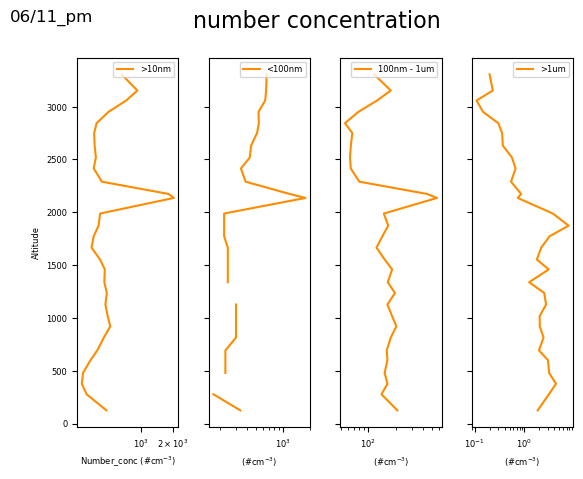

In [62]:
fig, ax = plt.subplots(1, 4, sharey='all')
plt.rcParams['font.size'] = '6'
ax[0].plot(DAY11b_subset_mean['CNgt10nm_ZIEMBA'], DAY11b_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label=">10nm")
ax[1].plot(DAY11b_subset_mean['nSMPS_ZIEMBA'], DAY11b_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label="<100nm")
ax[2].plot(DAY11b_subset_mean['IntegN_100to1000nm_LAS_ZIEMBA'], DAY11b_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label="100nm - 1um")
ax[3].plot(DAY11b_subset_mean['IntegN_gt1000nm_LAS_ZIEMBA'], DAY11b_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label='>1um')
ax[0].set_ylabel('Altitude')
ax[0].set_xlabel('Number_conc (#cm$^{-3}$)')
ax[1].set_xlabel('(#cm$^{-3}$)')
ax[2].set_xlabel('(#cm$^{-3}$)')
ax[3].set_xlabel('(#cm$^{-3}$)')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[3].set_xscale('log')
ax[0].legend(loc='upper right', fontsize=6)
ax[1].legend(loc='upper right', fontsize=6)
ax[2].legend(loc='upper right', fontsize=6)
ax[3].legend(loc='upper right', fontsize=6)
# Limit the number of tickers for the second plot
ax[0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=2))
ax[0].xaxis.set_minor_locator(ticker.NullLocator())


# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)



fig.text(0.02, 0.98, '06/11_pm', ha='left', va='top', fontsize=12)

# Set the title
fig.suptitle('number concentration', fontsize=16)

plt.show()

Text(0.5, 0.98, 'Volume concentration')

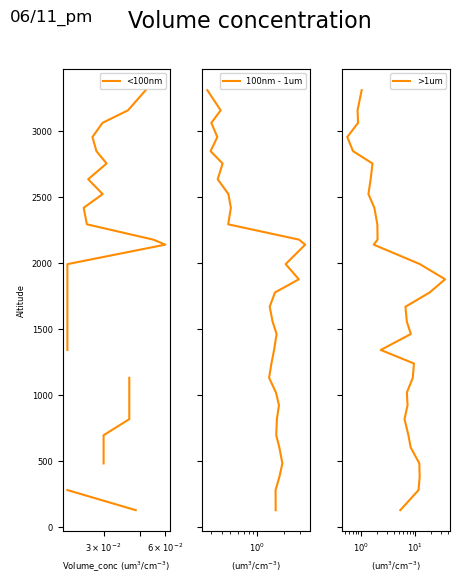

In [63]:
fig, ax = plt.subplots(1, 3, figsize=(5, 6), sharey='all')
plt.rcParams['font.size'] = '6'
ax[0].plot(DAY11b_subset_mean['vSMPS_ZIEMBA'], DAY11b_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label="<100nm")
ax[1].plot(DAY11b_subset_mean['IntegV_100to1000nm_LAS_ZIEMBA'], DAY11b_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label='100nm - 1um')
ax[2].plot(DAY11b_subset_mean['IntegV_gt1000nm_LAS_ZIEMBA'], DAY11b_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label='>1um')
ax[0].set_ylabel('Altitude')
ax[0].set_xlabel('Volume_conc (um$^{3}$/cm$^{-3}$)')
ax[1].set_xlabel('(um$^{3}$/cm$^{-3}$)')
ax[2].set_xlabel('(um$^{3}$/cm$^{-3}$)')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[0].legend(loc='upper right', fontsize=6)
ax[1].legend(loc='upper right', fontsize=6)
ax[2].legend(loc='upper right', fontsize=6)
# Limit the number of tickers for the second plot
ax[0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
ax[0].xaxis.set_minor_locator(ticker.NullLocator())

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)
fig.text(0.02, 0.98, '06/11_pm', ha='left', va='top', fontsize=12)
fig.suptitle('Volume concentration', fontsize=16)

In [64]:
DAY13 = simple_read('C:/Users/taiwoajayi/Documents/Intvol/activate-mrg1_hu25_20220613_R0_L1_20230625T113226.ict')
start_index = np.where(DAY13["Time_Start"]==pd.to_datetime("2022-06-13 14:30:00"))
stop_index = np.where(DAY13["Time_Start"]==pd.to_datetime("2022-06-13 14:46:00"))
    
DAY13_subset = DAY13[start_index[0][0]:stop_index[0][0]]

# Print the modified subset dataframe
DAY13_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
10015,2022-06-13 14:30:00,2022-06-13 14:30:01,32.210354,-65.054053,141.795,263.520,201.960,97.575,93.930,11.990,0.550,0.00,0.000,0.00,147.5,1.37,0.01
10016,2022-06-13 14:30:01,2022-06-13 14:30:02,32.209934,-65.052981,141.725,267.385,204.055,100.195,107.530,16.675,0.990,0.00,0.000,0.00,147.5,1.37,0.01
10017,2022-06-13 14:30:02,2022-06-13 14:30:03,32.209541,-65.051894,141.615,271.070,211.370,105.685,104.455,16.725,1.005,0.52,4.095,1.08,147.5,1.37,0.01
10018,2022-06-13 14:30:03,2022-06-13 14:30:04,32.209173,-65.050793,141.460,279.555,212.950,108.305,106.735,15.240,0.730,0.52,4.095,1.08,147.5,1.37,0.01
10019,2022-06-13 14:30:04,2022-06-13 14:30:05,32.208832,-65.049680,141.275,265.880,209.795,105.940,113.245,17.415,0.960,0.52,4.095,1.08,147.5,1.37,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10970,2022-06-13 14:45:55,2022-06-13 14:45:56,32.197220,-65.046274,4504.770,4422.310,2998.500,2199.460,282.350,17.015,0.465,0.00,0.000,0.00,NaN,NaN,NaN
10971,2022-06-13 14:45:56,2022-06-13 14:45:57,32.196954,-65.044914,4514.670,4615.320,2976.930,2185.390,298.270,17.740,0.460,0.00,0.000,0.00,NaN,NaN,NaN
10972,2022-06-13 14:45:57,2022-06-13 14:45:58,32.196726,-65.043543,4523.980,4819.800,3041.020,2205.360,275.470,16.395,0.420,0.00,0.000,0.00,NaN,NaN,NaN
10973,2022-06-13 14:45:58,2022-06-13 14:45:59,32.196539,-65.042160,4532.940,4678.200,3018.770,2182.170,258.585,15.110,0.380,0.00,0.000,0.00,NaN,NaN,NaN


In [65]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY13_subset.GPS_Altitude_THORNHILL.min(), DAY13_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY13_subset['Bins'] = pd.cut(DAY13_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY13_subset_1000 = DAY13_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY13_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY13_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_13 = DAY13_subset_1000[start_index:stop_index]
DAY1000_subset_13


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
Bins,,,,,,,,,,,,,,,,,
"(138.195, 182.23]",2022-06-13 14:30:32.200000000,2022-06-13 14:30:33.200,32.215823,-65.019495,142.037308,278.899692,219.906615,111.840769,104.058308,14.918692,0.786615,0.780923,7.787308,3.006154,145.662353,1.37,0.01
"(182.23, 226.264]",2022-06-13 14:31:11.500000000,2022-06-13 14:31:12.500,32.245854,-64.994298,201.121250,286.304583,222.915000,109.706250,109.090000,15.663750,0.844167,1.050833,11.102083,4.056667,139.690000,1.37,0.01
"(226.264, 270.299]",2022-06-13 14:31:24.000000256,2022-06-13 14:31:25.000,32.259352,-64.997848,250.047308,277.659231,212.565000,95.603462,104.316538,15.302308,0.787692,0.780000,9.966923,4.134615,139.690000,1.37,0.01
"(270.299, 314.334]",2022-06-13 14:31:36.500000000,2022-06-13 14:31:37.500,32.271439,-65.006302,292.679167,258.546667,202.767917,88.465833,95.232500,14.479167,0.825000,0.509167,4.191250,1.256667,139.690000,1.37,0.01
"(314.334, 358.368]",2022-06-13 14:31:48.000000000,2022-06-13 14:31:49.000,32.279961,-65.017932,338.120000,256.746364,197.979091,80.887273,94.722727,13.557273,0.702273,0.496364,3.233636,0.848182,NaN,NaN,NaN
"(358.368, 402.403]",2022-06-13 14:32:01.000000000,2022-06-13 14:32:02.000,32.285610,-65.034070,380.360667,273.531667,213.805667,96.263333,90.873333,13.918333,0.732333,0.864000,9.796000,3.892000,141.170000,1.35,0.01
"(402.403, 446.438]",2022-06-13 14:32:13.000000000,2022-06-13 14:32:14.000,32.287260,-65.050147,423.533333,266.648333,206.048889,81.239444,78.470556,10.464444,0.474444,0.953333,9.029444,3.110000,141.170000,1.35,0.01
"(446.438, 490.472]",2022-06-13 14:32:22.000000000,2022-06-13 14:32:23.000,32.285677,-65.062083,469.225556,283.504444,216.122222,89.607778,89.575556,12.294444,0.619444,0.317778,1.749444,0.435556,141.170000,1.35,0.01
"(490.472, 534.507]",2022-06-13 14:32:33.000000000,2022-06-13 14:32:34.000,32.280467,-65.075342,512.890385,277.011154,214.148846,83.378846,76.090769,10.976154,0.611538,0.638462,8.114231,3.284615,141.170000,1.35,0.01


In [66]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY13_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY13_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY13_subset_3000 = DAY13_subset_1000[start_index:stop_index]
DAY13_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
Bins,,,,,,,,,,,,,,,,,
"(1018.888, 1062.923]",2022-06-13 14:34:55.500,2022-06-13 14:34:56.500000000,32.220498,-64.995521,1042.884167,392.092917,289.024583,145.983750,118.923333,21.969583,1.690417,3.758750,43.399583,16.412083,177.79,2.09,0.02
"(1062.923, 1106.957]",2022-06-13 14:35:07.500,2022-06-13 14:35:08.500000000,32.233581,-64.989205,1085.528333,375.923750,285.009583,140.317083,108.760000,18.812917,1.370833,4.132083,38.261250,14.426250,177.79,2.09,0.02
"(1106.957, 1150.992]",2022-06-13 14:35:20.000,2022-06-13 14:35:21.000000000,32.248197,-64.987717,1131.330000,397.252308,304.170385,144.090769,116.191923,21.551538,1.636538,4.153846,52.461538,20.735769,177.79,2.09,0.02
"(1150.992, 1195.027]",2022-06-13 14:35:35.000,2022-06-13 14:35:36.000000000,32.265068,-64.993100,1172.945882,364.705882,272.708824,144.707059,104.427059,19.893529,1.595000,4.067941,49.180000,19.914412,177.79,2.09,0.02
"(1195.027, 1239.061]",2022-06-13 14:35:49.500,2022-06-13 14:35:50.500000000,32.278863,-65.004578,1216.515000,391.742917,299.620000,181.945833,133.126250,31.242083,2.860000,7.789583,74.777500,26.626667,180.68,1.90,0.02
"(1239.061, 1283.096]",2022-06-13 14:36:04.000,2022-06-13 14:36:05.000000000,32.288351,-65.020848,1261.682353,404.322941,300.626471,187.948529,138.607647,32.794118,3.020000,8.738529,92.466471,34.124706,180.68,1.90,0.02
"(1283.096, 1327.131]",2022-06-13 14:36:18.000,2022-06-13 14:36:19.000000000,32.292196,-65.039287,1304.431818,416.435455,314.814545,199.085909,158.287727,39.382273,3.720455,8.002273,103.395000,41.250909,180.68,1.90,0.02
"(1327.131, 1371.165]",2022-06-13 14:36:32.000,2022-06-13 14:36:33.000000000,32.290319,-65.058117,1351.644118,409.925588,310.275000,202.125882,154.792059,33.279412,2.937941,7.916471,95.722647,37.901176,180.68,1.90,0.02
"(1371.165, 1415.2]",2022-06-13 14:36:48.500,2022-06-13 14:36:49.500000000,32.280732,-65.077275,1389.921875,363.597500,280.209687,184.301562,136.244375,31.209063,2.839375,4.800000,53.211250,19.539687,215.70,2.78,0.03


In [67]:
nbins = 20
bins13 = np.linspace(DAY13_subset.GPS_Altitude_THORNHILL.min(), DAY13_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY13_subset['Bins'] = pd.cut(DAY13_subset['GPS_Altitude_THORNHILL'], bins13)
DAY13_subset_mean = DAY13_subset.groupby('Bins').mean()
DAY13_subset_mean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
Bins,,,,,,,,,,,,,,,,,
"(138.195, 358.368]",2022-06-13 14:30:56.539823104,2022-06-13 14:30:57.539823104,32.236169,-65.012776,195.822699,275.225442,215.426903,104.250619,102.776327,14.862743,0.788717,0.752920,7.564912,2.851681,143.316071,1.370000,0.010000
"(358.368, 578.542]",2022-06-13 14:32:22.500000000,2022-06-13 14:32:23.500000000,32.281669,-65.061194,467.023879,275.954569,213.532414,88.513534,82.773276,11.832500,0.625690,0.758362,7.955517,2.933190,141.170000,1.350000,0.010000
"(578.542, 798.715]",2022-06-13 14:33:21.500000000,2022-06-13 14:33:22.500000000,32.232911,-65.091581,689.368917,487.224583,368.861833,219.968000,155.580417,20.016333,1.068333,1.475667,15.077333,5.389583,263.640000,2.820000,0.030000
"(798.715, 1018.888]",2022-06-13 14:34:20.500000000,2022-06-13 14:34:21.500000000,32.201632,-65.035167,912.744914,424.223879,320.580776,155.855345,133.975776,21.797500,1.486034,2.681638,26.892414,10.091034,201.680000,2.150000,0.020000
"(1018.888, 1239.061]",2022-06-13 14:35:22.500000000,2022-06-13 14:35:23.500000000,32.250425,-64.993859,1133.128788,383.051439,289.001742,150.790303,115.385909,22.464470,1.809773,4.716970,51.444242,19.661970,177.912979,2.081915,0.020000
"(1239.061, 1459.234]",2022-06-13 14:36:32.000000000,2022-06-13 14:36:33.000000000,32.284290,-65.055790,1346.567123,393.620342,297.140822,193.100137,144.360205,33.261986,3.038425,7.164384,81.074932,31.035000,189.736897,2.127586,0.022586
"(1459.234, 1679.408]",2022-06-13 14:37:45.500000000,2022-06-13 14:37:46.500000000,32.222328,-65.078515,1565.221757,405.743851,300.947297,195.254257,131.294459,24.727770,2.067905,4.725068,47.241351,17.309122,218.595085,2.716102,0.030000
"(1679.408, 1899.581]",2022-06-13 14:38:58.500000000,2022-06-13 14:38:59.500000000,32.215370,-65.000897,1785.496389,441.387708,323.372222,197.674514,129.834167,24.602292,2.060000,4.392014,45.821944,16.920625,217.748947,2.693158,0.030000
"(1899.581, 2119.754]",2022-06-13 14:40:12.000000000,2022-06-13 14:40:13.000000000,32.281408,-65.006446,2005.465600,461.225533,334.702267,160.602667,93.107800,17.571667,1.490733,3.653067,36.145333,13.007733,249.981633,2.581429,0.030000


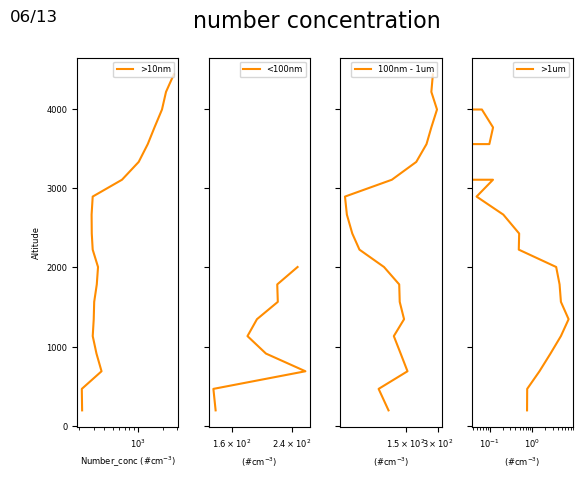

In [68]:
fig, ax = plt.subplots(1, 4, sharey='all')
plt.rcParams['font.size'] = '6'
ax[0].plot(DAY13_subset_mean['CNgt10nm_ZIEMBA'], DAY13_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label=">10nm")
ax[1].plot(DAY13_subset_mean['nSMPS_ZIEMBA'], DAY13_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label="<100nm")
ax[2].plot(DAY13_subset_mean['IntegN_100to1000nm_LAS_ZIEMBA'], DAY13_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label="100nm - 1um")
ax[3].plot(DAY13_subset_mean['IntegN_gt1000nm_LAS_ZIEMBA'], DAY13_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label='>1um')
ax[0].set_ylabel('Altitude')
ax[0].set_xlabel('Number_conc (#cm$^{-3}$)')
ax[1].set_xlabel('(#cm$^{-3}$)')
ax[2].set_xlabel('(#cm$^{-3}$)')
ax[3].set_xlabel('(#cm$^{-3}$)')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[3].set_xscale('log')
ax[0].legend(loc='upper right', fontsize=6)
ax[1].legend(loc='upper right', fontsize=6)
ax[2].legend(loc='upper right', fontsize=6)
ax[3].legend(loc='upper right', fontsize=6)
# Limit the number of tickers for the second plot
# Reduce the number of x-axis tickers to 2 for ax[1]
ax[1].xaxis.set_major_locator(ticker.MaxNLocator(nbins=2))
ax[1].xaxis.set_minor_locator(ticker.NullLocator())

# Reduce the number of x-axis tickers to 2 for ax[2]
ax[2].xaxis.set_major_locator(ticker.MaxNLocator(nbins=2))
ax[2].xaxis.set_minor_locator(ticker.NullLocator())


# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)

fig.text(0.02, 0.98, '06/13', ha='left', va='top', fontsize=12)

# Set the title
fig.suptitle('number concentration', fontsize=16)

plt.show()

Text(0.5, 0.98, 'Volume concentration')

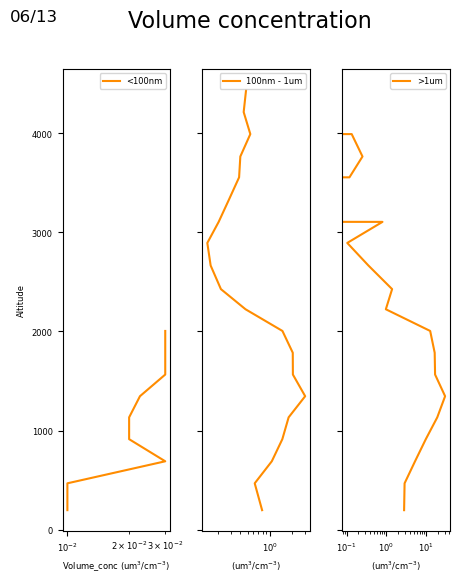

In [69]:
fig, ax = plt.subplots(1, 3, figsize=(5, 6), sharey='all')
plt.rcParams['font.size'] = '6'
ax[0].plot(DAY13_subset_mean['vSMPS_ZIEMBA'], DAY13_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label="<100nm")
ax[1].plot(DAY13_subset_mean['IntegV_100to1000nm_LAS_ZIEMBA'], DAY13_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label='100nm - 1um')
ax[2].plot(DAY13_subset_mean['IntegV_gt1000nm_LAS_ZIEMBA'], DAY13_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label='>1um')
ax[0].set_ylabel('Altitude')
ax[0].set_xlabel('Volume_conc (um$^{3}$/cm$^{-3}$)')
ax[1].set_xlabel('(um$^{3}$/cm$^{-3}$)')
ax[2].set_xlabel('(um$^{3}$/cm$^{-3}$)')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[0].legend(loc='upper right', fontsize=6)
ax[1].legend(loc='upper right', fontsize=6)
ax[2].legend(loc='upper right', fontsize=6)
# Limit the number of tickers for the second plot

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)
fig.text(0.02, 0.98, '06/13', ha='left', va='top', fontsize=12)
fig.suptitle('Volume concentration', fontsize=16)

In [70]:
DAY13b = simple_read('C:/Users/taiwoajayi/Documents/Intvol/activate-mrg1_hu25_20220613_R0_L2_20230625T113226.ict')
start_index = np.where(DAY13b["Time_Start"]==pd.to_datetime("2022-06-13 19:46:00"))
stop_index = np.where(DAY13b["Time_Start"]==pd.to_datetime("2022-06-13 20:09:00"))
    
DAY13b_subset = DAY13b[start_index[0][0]:stop_index[0][0]]

# Print the modified subset dataframe
DAY13b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
10610,2022-06-13 19:46:00,2022-06-13 19:46:01,32.251226,-65.007304,106.13,248.720,199.575,74.955,96.245,16.920,1.075,0.52,6.490,2.160,NaN,NaN,NaN
10611,2022-06-13 19:46:01,2022-06-13 19:46:02,32.250414,-65.006555,105.59,245.050,192.875,77.615,89.315,15.265,0.865,0.52,6.490,2.160,134.12,1.24,0.01
10612,2022-06-13 19:46:02,2022-06-13 19:46:03,32.249605,-65.005808,106.45,244.575,192.450,78.325,88.850,15.050,0.855,0.52,6.485,2.155,134.12,1.24,0.01
10613,2022-06-13 19:46:03,2022-06-13 19:46:04,32.248799,-65.005062,108.91,237.025,194.690,76.215,92.050,16.360,1.025,0.52,6.485,2.155,134.12,1.24,0.01
10614,2022-06-13 19:46:04,2022-06-13 19:46:05,32.247996,-65.004323,112.60,233.855,199.060,77.235,93.730,15.245,0.855,0.00,0.000,0.000,134.12,1.24,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11985,2022-06-13 20:08:55,2022-06-13 20:08:56,32.290180,-64.996666,4558.09,4284.720,2691.220,1867.720,312.560,19.675,0.540,0.00,0.000,0.000,NaN,NaN,NaN
11986,2022-06-13 20:08:56,2022-06-13 20:08:57,32.289203,-64.997413,4565.53,4059.930,2591.210,1835.100,312.175,18.895,0.490,0.00,0.000,0.000,NaN,NaN,NaN
11987,2022-06-13 20:08:57,2022-06-13 20:08:58,32.288204,-64.998124,4572.98,4020.480,2627.360,1870.590,323.175,20.150,0.565,0.00,0.000,0.000,NaN,NaN,NaN
11988,2022-06-13 20:08:58,2022-06-13 20:08:59,32.287185,-64.998799,4580.36,4055.780,2646.360,1863.520,317.435,20.950,0.610,0.00,0.000,0.000,NaN,NaN,NaN


In [71]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY13b_subset.GPS_Altitude_THORNHILL.min(), DAY13b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY13b_subset['Bins'] = pd.cut(DAY13b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY13b_subset_1000 = DAY13b_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY13b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY13b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_13b = DAY13b_subset_1000[start_index:stop_index]
DAY1000_subset_13b


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
Bins,,,,,,,,,,,,,,,,,
"(105.59, 150.409]",2022-06-13 19:46:21.476190464,2022-06-13 19:46:22.476190464,32.235045,-64.990851,121.140833,258.557857,201.094405,89.105357,86.096190,12.787619,0.635952,0.475476,3.592143,1.139286,134.12,1.24,0.01
"(150.409, 195.228]",2022-06-13 19:46:50.000000000,2022-06-13 19:46:51.000000000,32.223206,-64.962163,172.722000,276.149333,220.381000,105.081333,71.839000,10.640000,0.522667,0.294667,1.708667,0.406667,134.12,1.24,0.01
"(195.228, 240.047]",2022-06-13 19:47:03.500000000,2022-06-13 19:47:04.500000000,32.226886,-64.946746,218.451667,230.897917,178.323333,70.000833,74.786250,10.296250,0.459583,0.085833,1.078333,0.358333,135.23,1.08,0.01
"(240.047, 284.866]",2022-06-13 19:47:16.500000000,2022-06-13 19:47:17.500000000,32.235473,-64.934988,261.591786,220.152857,175.679286,66.443571,69.415357,10.089286,0.450000,0.240714,2.988571,1.352857,135.23,1.08,0.01
"(284.866, 329.686]",2022-06-13 19:47:33.000000000,2022-06-13 19:47:34.000000000,32.250778,-64.927901,307.752895,202.823158,158.602895,48.986053,60.138684,9.023158,0.409737,0.204737,1.212105,0.292368,135.23,1.08,0.01
"(329.686, 374.505]",2022-06-13 19:47:48.000000000,2022-06-13 19:47:49.000000000,32.265570,-64.930424,352.170000,196.807727,151.878636,43.514091,59.415455,8.636364,0.397727,0.141818,0.979091,0.245909,135.23,1.08,0.01
"(374.505, 419.324]",2022-06-13 19:48:00.500000000,2022-06-13 19:48:01.500000000,32.275624,-64.938790,397.117857,197.590000,152.085714,42.453929,55.070714,7.977500,0.364643,0.167143,1.220714,0.357143,125.96,1.08,0.01
"(419.324, 464.143]",2022-06-13 19:48:11.500000000,2022-06-13 19:48:12.500000000,32.281952,-64.948895,442.846250,186.882500,149.781875,41.575000,60.948750,8.900625,0.425000,0.162500,0.508750,0.085000,125.96,1.08,0.01
"(464.143, 508.962]",2022-06-13 19:48:21.500000000,2022-06-13 19:48:22.500000000,32.284827,-64.959460,489.259167,193.537917,151.995417,41.144583,55.027917,7.958750,0.383333,0.303333,2.140417,0.542083,125.96,1.08,0.01


In [72]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY13b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY13b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY13b_subset_3000 = DAY13b_subset_1000[start_index:stop_index]
DAY13b_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
Bins,,,,,,,,,,,,,,,,,
"(1001.972, 1046.791]",2022-06-13 19:51:08.500000000,2022-06-13 19:51:09.500000000,32.277795,-64.944534,1023.430000,460.769500,348.037500,205.441500,128.864000,15.378000,0.771000,1.426500,16.662500,6.236500,229.960000,2.300000,0.03
"(1046.791, 1091.61]",2022-06-13 19:51:18.500000000,2022-06-13 19:51:19.500000000,32.285446,-64.953669,1069.449000,533.181000,396.285000,246.235000,153.031000,18.741000,0.961500,1.051000,6.173000,1.600500,229.960000,2.300000,0.03
"(1091.61, 1136.429]",2022-06-13 19:51:28.500000000,2022-06-13 19:51:29.500000000,32.290798,-64.964661,1113.492000,431.022000,321.526000,150.434500,114.481000,17.670500,1.208000,2.182000,24.225500,8.784000,229.960000,2.300000,0.03
"(1136.429, 1181.248]",2022-06-13 19:51:38.500000000,2022-06-13 19:51:39.500000000,32.293438,-64.976744,1163.157000,436.630000,313.555000,142.044000,114.278500,20.203000,1.509500,2.826500,31.292500,11.986500,229.960000,2.300000,0.03
"(1181.248, 1226.067]",2022-06-13 19:51:52.000000000,2022-06-13 19:51:53.000000000,32.292299,-64.993297,1203.252353,381.850882,288.110000,140.862353,119.658235,21.181471,1.595000,3.837353,40.127941,15.076765,229.960000,2.300000,0.03
"(1226.067, 1270.887]",2022-06-13 19:52:08.500000000,2022-06-13 19:52:09.500000000,32.284282,-65.011196,1245.613750,394.469688,287.371875,145.938125,120.374063,25.548437,2.193125,4.711250,50.690938,18.931875,203.460000,2.170000,0.02
"(1270.887, 1315.706]",2022-06-13 19:52:25.000000000,2022-06-13 19:52:26.000000000,32.270083,-65.022916,1291.343529,408.883529,308.895882,158.176176,123.918235,26.024706,2.220294,5.796471,62.401471,23.357059,203.460000,2.170000,0.02
"(1315.706, 1360.525]",2022-06-13 19:52:41.000000000,2022-06-13 19:52:42.000000000,32.253286,-65.026168,1340.182667,385.259333,289.866333,165.052667,123.177000,25.822000,2.211333,6.288667,67.624000,25.355667,203.460000,2.170000,0.02
"(1360.525, 1405.344]",2022-06-13 19:52:54.500000000,2022-06-13 19:52:55.500000000,32.239093,-65.022448,1385.006667,373.687083,282.440417,169.153333,130.644583,30.125000,2.752500,7.176667,75.990833,27.860833,NaN,NaN,NaN


In [73]:
nbins = 30
bins13b = np.linspace(DAY13b_subset.GPS_Altitude_THORNHILL.min(), DAY13b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY13b_subset['Bins'] = pd.cut(DAY13b_subset['GPS_Altitude_THORNHILL'], bins13b)
DAY13b_subset_mean = DAY13b_subset.groupby('Bins').mean()
DAY13b_subset_mean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
Bins,,,,,,,,,,,,,,,,,
"(105.59, 254.987]",2022-06-13 19:46:37.486486528,2022-06-13 19:46:38.486486272,32.231111,-64.974342,155.893514,256.000203,199.755203,87.875743,80.293919,11.795608,0.575878,0.343514,2.560000,0.787162,134.387931,1.201379,0.010000
"(254.987, 404.384]",2022-06-13 19:47:39.000000000,2022-06-13 19:47:40.000000000,32.256446,-64.931294,327.717959,202.386327,158.613367,49.368878,60.326429,8.812959,0.392449,0.227755,1.892449,0.657143,134.412059,1.080000,0.010000
"(404.384, 553.781]",2022-06-13 19:48:25.000000000,2022-06-13 19:48:26.000000000,32.283472,-64.963381,493.271744,190.500581,151.201860,40.782442,55.425465,8.113488,0.382209,0.181395,1.002558,0.233256,125.960000,1.080000,0.010000
"(553.781, 703.178]",2022-06-13 19:49:10.000000256,2022-06-13 19:49:11.000000000,32.262713,-64.998132,623.513830,204.921702,156.676489,40.434894,48.437979,6.410745,0.280319,0.259574,2.744681,0.958298,133.410000,1.050000,0.010000
"(703.178, 852.575]",2022-06-13 19:49:55.000000000,2022-06-13 19:49:56.000000000,32.229218,-64.977353,783.578372,267.327326,204.822791,68.886860,59.864186,8.036977,0.442558,0.591860,6.996744,2.545698,173.107143,1.490000,0.015714
"(852.575, 1001.972]",2022-06-13 19:50:40.000000256,2022-06-13 19:50:41.000000000,32.248741,-64.939051,915.960106,319.976915,242.285532,105.831383,74.222021,9.949468,0.593404,1.280957,12.786596,4.431809,205.418750,1.865000,0.020938
"(1001.972, 1151.369]",2022-06-13 19:51:19.500000000,2022-06-13 19:51:20.500000000,32.285189,-64.955383,1073.425625,473.426250,352.789531,196.890156,130.725469,17.415781,1.009688,1.682656,17.932813,6.611562,229.960000,2.300000,0.030000
"(1151.369, 1300.766]",2022-06-13 19:52:03.000000000,2022-06-13 19:52:04.000000000,32.284887,-65.003659,1232.018182,399.159909,296.674727,147.321273,120.217909,23.579545,1.923455,4.478091,46.253545,17.040909,210.085000,2.202500,0.022500
"(1300.766, 1450.163]",2022-06-13 19:52:56.000000000,2022-06-13 19:52:57.000000000,32.238747,-65.018660,1384.676275,382.390196,286.555490,171.335980,128.432647,27.882255,2.436961,6.217255,64.431471,23.603529,176.626667,1.995000,0.020000


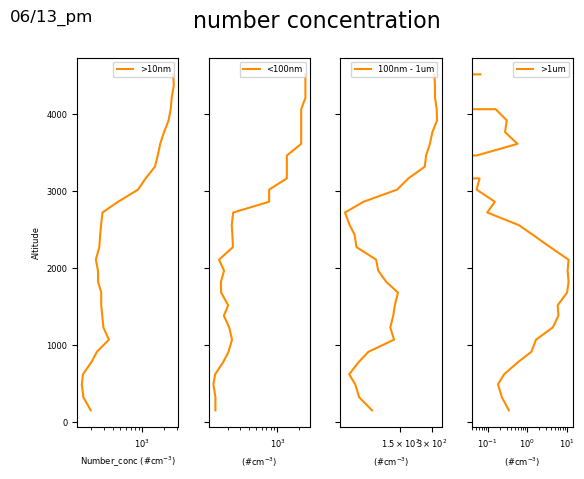

In [74]:
fig, ax = plt.subplots(1, 4, sharey='all')
plt.rcParams['font.size'] = '6'
ax[0].plot(DAY13b_subset_mean['CNgt10nm_ZIEMBA'], DAY13b_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label=">10nm")
ax[1].plot(DAY13b_subset_mean['nSMPS_ZIEMBA'], DAY13b_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label="<100nm")
ax[2].plot(DAY13b_subset_mean['IntegN_100to1000nm_LAS_ZIEMBA'], DAY13b_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label="100nm - 1um")
ax[3].plot(DAY13b_subset_mean['IntegN_gt1000nm_LAS_ZIEMBA'], DAY13b_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label='>1um')
ax[0].set_ylabel('Altitude')
ax[0].set_xlabel('Number_conc (#cm$^{-3}$)')
ax[1].set_xlabel('(#cm$^{-3}$)')
ax[2].set_xlabel('(#cm$^{-3}$)')
ax[3].set_xlabel('(#cm$^{-3}$)')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[3].set_xscale('log')
ax[0].legend(loc='upper right', fontsize=6)
ax[1].legend(loc='upper right', fontsize=6)
ax[2].legend(loc='upper right', fontsize=6)
ax[3].legend(loc='upper right', fontsize=6)

# Reduce the number of x-axis tickers to 2 for ax[2]
ax[2].xaxis.set_major_locator(ticker.MaxNLocator(nbins=1))
ax[2].xaxis.set_minor_locator(ticker.NullLocator())


# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)



fig.text(0.02, 0.98, '06/13_pm', ha='left', va='top', fontsize=12)

# Set the title
fig.suptitle('number concentration', fontsize=16)

plt.show()

Text(0.5, 0.98, 'Volume concentration')

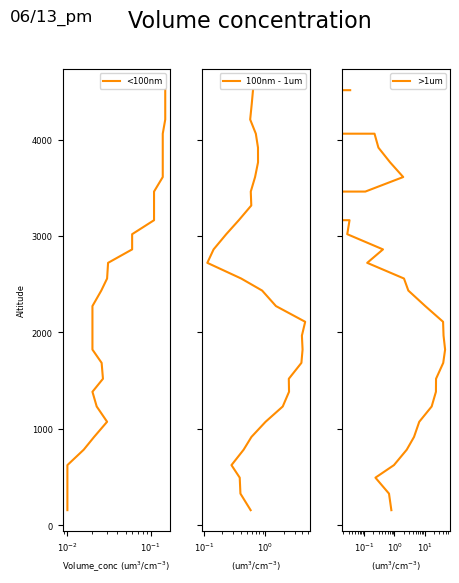

In [75]:
fig, ax = plt.subplots(1, 3, figsize=(5, 6), sharey='all')
plt.rcParams['font.size'] = '6'
ax[0].plot(DAY13b_subset_mean['vSMPS_ZIEMBA'], DAY13b_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label="<100nm")
ax[1].plot(DAY13b_subset_mean['IntegV_100to1000nm_LAS_ZIEMBA'], DAY13b_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label='100nm - 1um')
ax[2].plot(DAY13b_subset_mean['IntegV_gt1000nm_LAS_ZIEMBA'], DAY13b_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label='>1um')
ax[0].set_ylabel('Altitude')
ax[0].set_xlabel('Volume_conc (um$^{3}$/cm$^{-3}$)')
ax[1].set_xlabel('(um$^{3}$/cm$^{-3}$)')
ax[2].set_xlabel('(um$^{3}$/cm$^{-3}$)')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[0].legend(loc='upper right', fontsize=6)
ax[1].legend(loc='upper right', fontsize=6)
ax[2].legend(loc='upper right', fontsize=6)
# Limit the number of tickers for the second plot
#ax[1].set_xlim([0, 2])
#ax[2].set_xlim([100, 300])
#ax[2].set_xlim([0, 3])
# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)
fig.text(0.02, 0.98, '06/13_pm', ha='left', va='top', fontsize=12)
fig.suptitle('Volume concentration', fontsize=16)

In [76]:
DAY14 = simple_read('C:/Users/taiwoajayi/Documents/Intvol/activate-mrg1_hu25_20220614_R0_20230625T113226.ict')
start_index = np.where(DAY14["Time_Start"]==pd.to_datetime("2022-06-14 16:05:00"))
stop_index = np.where(DAY14["Time_Start"]==pd.to_datetime("2022-06-14 16:25:00"))
    
DAY14_subset = DAY14[start_index[0][0]:stop_index[0][0]]
start_col2 = 'CNgt3nm_ZIEMBA'

# Print the modified subset dataframe
DAY14_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
9363,2022-06-14 16:05:00,2022-06-14 16:05:01,30.642555,-64.394685,117.000,368.485,272.875,132.525,138.135,15.450,0.665,3.635,28.575,11.045,NaN,NaN,NaN
9364,2022-06-14 16:05:01,2022-06-14 16:05:02,30.641725,-64.395343,117.085,360.310,278.665,134.115,139.695,17.310,0.770,2.855,33.340,13.585,NaN,NaN,NaN
9365,2022-06-14 16:05:02,2022-06-14 16:05:03,30.640923,-64.396042,117.190,359.020,270.810,131.490,132.730,17.975,0.975,2.210,25.305,8.965,NaN,NaN,NaN
9366,2022-06-14 16:05:03,2022-06-14 16:05:04,30.640148,-64.396780,117.295,376.865,267.685,128.360,120.805,16.505,1.010,2.210,19.040,6.285,NaN,NaN,NaN
9367,2022-06-14 16:05:04,2022-06-14 16:05:05,30.639403,-64.397555,117.380,351.565,272.455,130.485,129.920,17.180,0.910,1.555,10.780,2.705,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10558,2022-06-14 16:24:55,2022-06-14 16:24:56,30.850057,-64.439182,8454.590,5022.140,2835.380,1861.140,178.615,16.575,0.715,0.000,0.000,0.000,NaN,NaN,NaN
10559,2022-06-14 16:24:56,2022-06-14 16:24:57,30.851471,-64.439393,8461.000,5002.010,2811.630,1857.830,180.615,15.460,0.525,0.650,2.040,0.340,NaN,NaN,NaN
10560,2022-06-14 16:24:57,2022-06-14 16:24:58,30.852885,-64.439595,8467.420,4967.890,2815.640,1845.640,179.010,15.115,0.500,0.650,2.040,0.340,NaN,NaN,NaN
10561,2022-06-14 16:24:58,2022-06-14 16:24:59,30.854300,-64.439786,8473.860,4999.500,2846.200,1848.020,191.850,16.480,0.635,0.000,0.000,0.000,NaN,NaN,NaN


In [77]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY14_subset.GPS_Altitude_THORNHILL.min(), DAY14_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY14_subset['Bins'] = pd.cut(DAY14_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY14_subset_1000 = DAY14_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY14_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY14_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_14 = DAY14_subset_1000[start_index:stop_index]
DAY1000_subset_14.describe()


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
count,10,10,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0000,10.000000
mean,2022-06-14 16:06:20.549999872,2022-06-14 16:06:21.549999872,30.665996,-64.421215,532.612161,387.523375,299.972100,152.851300,100.889164,14.444532,0.887524,1.395199,13.475923,4.729807,223.538000,1.4990,0.016000
min,2022-06-14 16:05:20,2022-06-14 16:05:21,30.635158,-64.443667,129.846923,296.723000,230.320500,100.062000,92.143500,12.835455,0.676364,0.572000,2.970000,0.677000,110.270000,0.8000,0.010000
25%,2022-06-14 16:05:57.624999936,2022-06-14 16:05:58.624999936,30.654523,-64.438572,347.133625,306.106125,233.093875,104.161104,95.599125,13.800479,0.793250,1.056740,9.998477,3.134682,124.260000,0.8100,0.010000
50%,2022-06-14 16:06:21.750000128,2022-06-14 16:06:22.750000128,30.670587,-64.423276,535.254470,308.495409,237.381292,106.907500,99.491875,14.535841,0.859824,1.205409,10.617731,3.604831,124.260000,0.8100,0.010000
75%,2022-06-14 16:06:46,2022-06-14 16:06:47,30.679871,-64.407655,723.516250,329.233625,258.818523,121.627045,102.169864,15.130625,0.950170,1.543000,17.966646,7.164167,375.952500,2.5350,0.025000
max,2022-06-14 16:07:10.500000,2022-06-14 16:07:11.500000,30.684512,-64.387230,913.690000,998.117500,779.118000,504.806500,114.539487,16.117000,1.167000,2.388000,24.731500,8.834000,459.850000,3.1100,0.030000
std,NaN,NaN,0.017557,0.020702,258.194532,216.548559,169.955960,124.938830,7.332227,1.048402,0.151525,0.586961,6.904091,2.776708,163.127916,1.1117,0.009661


In [78]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY14_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY14_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY14_subset_3000 = DAY14_subset_1000[start_index:stop_index]
DAY14_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
count,28,28,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,27.000000,27.000000,27.00
mean,2022-06-14 16:09:40.571428352,2022-06-14 16:09:41.571428864,30.665512,-64.406044,2207.918130,390.041135,273.418648,91.034169,47.838517,8.918194,0.757538,1.411262,15.092219,5.629082,239.288889,1.073333,0.01
min,2022-06-14 16:07:29.500000,2022-06-14 16:07:30.500000,30.637684,-64.436561,1077.070000,296.046500,225.251000,58.803333,16.479500,0.988000,0.025000,0.000000,0.000000,0.000000,110.270000,0.800000,0.01
25%,2022-06-14 16:08:34.124999936,2022-06-14 16:08:35.124999936,30.644458,-64.425179,1642.586361,333.819375,239.335792,70.101212,26.192222,2.982333,0.151944,0.178750,0.678875,0.127000,154.050000,0.870000,0.01
50%,2022-06-14 16:09:38.750000128,2022-06-14 16:09:39.750000128,30.661879,-64.407742,2206.432056,374.097795,256.778977,79.153819,38.808389,6.169417,0.524278,1.007500,10.675250,3.764500,194.300000,0.950000,0.01
75%,2022-06-14 16:10:45.624999936,2022-06-14 16:10:46.624999936,30.684682,-64.388273,2773.432083,425.715750,291.619792,110.696875,71.708875,15.410125,1.358792,2.645250,27.923250,10.349306,259.270000,1.340000,0.01
max,2022-06-14 16:11:56,2022-06-14 16:11:57,30.699582,-64.368152,3338.431111,708.308333,467.033889,200.686667,95.114000,20.182500,1.984444,3.590556,47.007000,20.078000,474.800000,1.360000,0.01
std,NaN,NaN,0.021283,0.022013,688.131611,83.188896,50.413773,29.678436,25.903591,6.873673,0.658417,1.338859,14.948812,5.847517,124.351300,0.239133,0.00


In [79]:
nbins = 30
bins14 = np.linspace(DAY14_subset.GPS_Altitude_THORNHILL.min(), DAY14_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY14_subset['Bins'] = pd.cut(DAY14_subset['GPS_Altitude_THORNHILL'], bins14)
DAY14_subset_mean = DAY14_subset.groupby('Bins').mean()
DAY14_subset_mean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
Bins,,,,,,,,,,,,,,,,,
"(117.0, 395.778]",2022-06-14 16:05:32.000000000,2022-06-14 16:05:33.000000000,30.640382,-64.424557,194.151508,478.659286,370.747778,206.231508,111.354683,14.718492,0.806349,0.985000,9.361905,3.239048,459.850000,3.110000,0.030000
"(395.778, 674.555]",2022-06-14 16:06:21.500000000,2022-06-14 16:06:22.500000000,30.675263,-64.433260,532.951389,304.379167,239.380972,107.246944,100.044028,14.312222,0.879306,1.283472,11.039722,3.662639,124.260000,0.810000,0.010000
"(674.555, 953.333]",2022-06-14 16:06:57.500000000,2022-06-14 16:06:58.500000000,30.677968,-64.397646,812.095417,306.697222,232.418611,103.777639,93.971806,14.845694,1.001111,2.012500,21.277361,7.844722,120.262857,0.807143,0.010000
"(953.333, 1232.111]",2022-06-14 16:07:31.000000000,2022-06-14 16:07:32.000000000,30.650820,-64.390098,1091.634032,311.814032,233.845968,118.217258,92.634677,18.955484,1.596290,3.046129,34.426935,13.449032,110.270000,0.800000,0.010000
"(1232.111, 1510.888]",2022-06-14 16:08:02.500000000,2022-06-14 16:08:03.500000000,30.642636,-64.418613,1367.062187,321.340781,237.430937,113.661875,80.548125,16.327656,1.431406,2.997187,31.379062,11.242344,133.447647,0.879412,0.010000
"(1510.888, 1789.666]",2022-06-14 16:08:35.000000000,2022-06-14 16:08:36.000000000,30.668578,-64.434492,1650.077273,331.853636,241.129242,109.770455,71.807576,17.500758,1.652727,3.080909,31.413485,11.657727,154.050000,0.950000,0.010000
"(1789.666, 2068.444]",2022-06-14 16:09:07.500000000,2022-06-14 16:09:08.500000000,30.691265,-64.407755,1931.983125,362.574531,252.637344,85.495781,54.883594,12.126875,1.086406,1.859063,19.510156,7.458750,187.197059,0.884118,0.010000
"(2068.444, 2347.221]",2022-06-14 16:09:39.000000000,2022-06-14 16:09:40.000000000,30.677811,-64.374367,2209.057097,411.986290,291.974839,64.994032,29.991452,4.298226,0.322419,0.570000,7.712419,3.179032,194.300000,0.870000,0.010000
"(2347.221, 2625.999]",2022-06-14 16:10:11.500000000,2022-06-14 16:10:12.500000000,30.647018,-64.378103,2485.770588,358.913529,245.925588,74.138382,35.199118,5.576324,0.450882,0.986471,9.870147,3.313235,474.800000,1.340000,0.010000


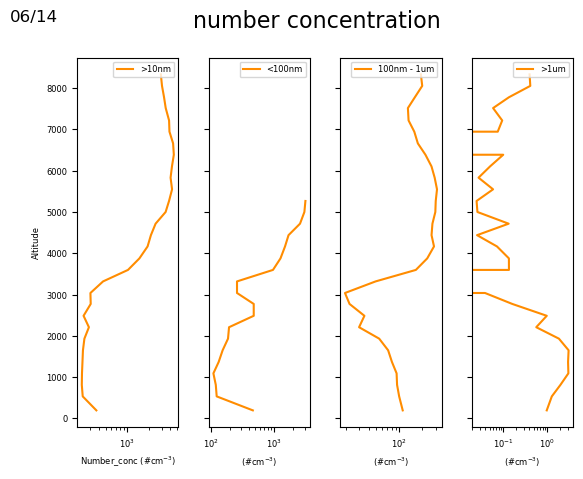

In [80]:
fig, ax = plt.subplots(1, 4, sharey='all')
plt.rcParams['font.size'] = '6'
ax[0].plot(DAY14_subset_mean['CNgt10nm_ZIEMBA'], DAY14_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label=">10nm")
ax[1].plot(DAY14_subset_mean['nSMPS_ZIEMBA'], DAY14_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label="<100nm")
ax[2].plot(DAY14_subset_mean['IntegN_100to1000nm_LAS_ZIEMBA'], DAY14_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label="100nm - 1um")
ax[3].plot(DAY14_subset_mean['IntegN_gt1000nm_LAS_ZIEMBA'], DAY14_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label='>1um')
ax[0].set_ylabel('Altitude')
ax[0].set_xlabel('Number_conc (#cm$^{-3}$)')
ax[1].set_xlabel('(#cm$^{-3}$)')
ax[2].set_xlabel('(#cm$^{-3}$)')
ax[3].set_xlabel('(#cm$^{-3}$)')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[3].set_xscale('log')
ax[0].legend(loc='upper right', fontsize=6)
ax[1].legend(loc='upper right', fontsize=6)
ax[2].legend(loc='upper right', fontsize=6)
ax[3].legend(loc='upper right', fontsize=6)
# Limit the number of tickers for the second plot
#ax[0].set_xlim([300, 500])
#ax[2].set_xlim([100, 300])
#ax[3].set_xlim([0, 2])

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)



fig.text(0.02, 0.98, '06/14', ha='left', va='top', fontsize=12)

# Set the title
fig.suptitle('number concentration', fontsize=16)

plt.show()

Text(0.5, 0.98, 'Volume concentration')

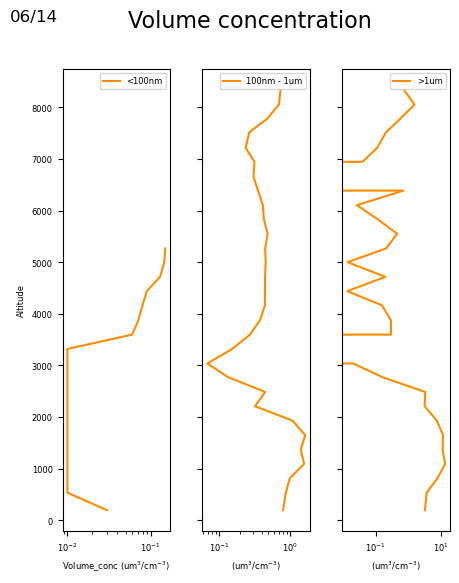

In [81]:
fig, ax = plt.subplots(1, 3, figsize=(5, 6), sharey='all')
plt.rcParams['font.size'] = '9'
ax[0].plot(DAY14_subset_mean['vSMPS_ZIEMBA'], DAY14_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label="<100nm")
ax[1].plot(DAY14_subset_mean['IntegV_100to1000nm_LAS_ZIEMBA'], DAY14_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label='100nm - 1um')
ax[2].plot(DAY14_subset_mean['IntegV_gt1000nm_LAS_ZIEMBA'], DAY14_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label='>1um')
ax[0].set_ylabel('Altitude')
ax[0].set_xlabel('Volume_conc (um$^{3}$/cm$^{-3}$)')
ax[1].set_xlabel('(um$^{3}$/cm$^{-3}$)')
ax[2].set_xlabel('(um$^{3}$/cm$^{-3}$)')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[0].legend(loc='upper right', fontsize=6)
ax[1].legend(loc='upper right', fontsize=6)
ax[2].legend(loc='upper right', fontsize=6)
# Limit the number of tickers for the second plot

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)
fig.text(0.02, 0.98, '06/14', ha='left', va='top', fontsize=12)
fig.suptitle('Volume concentration', fontsize=16)

In [82]:
DAY17 = simple_read('C:/Users/taiwoajayi/Documents/Intvol/activate-mrg1_hu25_20220617_R0_20230625T113227.ict')
start_index = np.where(DAY17["Time_Start"]==pd.to_datetime("2022-06-17 16:20:00"))
stop_index = np.where(DAY17["Time_Start"]==pd.to_datetime("2022-06-17 16:47:00"))
    
DAY17_subset = DAY17[start_index[0][0]:stop_index[0][0]]

# Print the modified subset dataframe
DAY17_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
10469,2022-06-17 16:20:00,2022-06-17 16:20:01,32.206574,-65.006772,134.100,617.170,470.960,143.015,116.435,16.630,1.100,1.170,6.140,1.425,365.51,1.52,0.01
10470,2022-06-17 16:20:01,2022-06-17 16:20:02,32.206131,-65.005761,133.795,618.175,468.275,144.045,130.345,18.055,1.150,0.000,0.000,0.000,365.51,1.52,0.01
10471,2022-06-17 16:20:02,2022-06-17 16:20:03,32.205725,-65.004728,133.485,608.370,465.530,145.055,137.940,17.645,1.035,0.520,6.505,2.165,365.51,1.52,0.01
10472,2022-06-17 16:20:03,2022-06-17 16:20:04,32.205357,-65.003676,133.170,605.080,466.515,143.990,128.180,16.665,1.010,1.555,17.080,5.405,365.51,1.52,0.01
10473,2022-06-17 16:20:04,2022-06-17 16:20:05,32.205027,-65.002606,132.825,629.505,469.700,144.000,125.065,19.015,1.405,1.555,17.105,5.410,365.51,1.52,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12084,2022-06-17 16:46:55,2022-06-17 16:46:56,32.158601,-65.020304,7639.050,15553.500,9582.830,5479.430,227.450,13.735,0.355,0.000,0.000,0.000,8482.97,39.00,0.37
12085,2022-06-17 16:46:56,2022-06-17 16:46:57,32.157293,-65.019563,7645.810,16205.300,9688.650,5483.210,234.945,15.275,0.465,0.000,0.000,0.000,8482.97,39.00,0.37
12086,2022-06-17 16:46:57,2022-06-17 16:46:58,32.156002,-65.018778,7652.610,16195.000,9721.260,5487.590,215.570,14.505,0.475,0.000,0.000,0.000,8482.97,39.00,0.37
12087,2022-06-17 16:46:58,2022-06-17 16:46:59,32.154729,-65.017953,7659.440,16309.400,9739.670,5490.990,210.535,13.815,0.420,0.000,0.000,0.000,8482.97,39.00,0.37


In [83]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY17_subset.GPS_Altitude_THORNHILL.min(), DAY17_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY17_subset['Bins'] = pd.cut(DAY17_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY17_subset_1000 = DAY17_subset.groupby('Bins').mean()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY17_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY17_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_17 = DAY17_subset_1000[start_index:stop_index]
DAY1000_subset_17


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
Bins,,,,,,,,,,,,,,,,,
"(124.73, 200.146]",2022-06-17 16:20:35.295774720,2022-06-17 16:20:36.295774720,32.218829,-64.978554,138.339507,602.159507,467.216690,149.376479,116.721690,15.874014,1.012394,1.142183,8.871479,2.790211,337.949107,1.466964,0.01
"(200.146, 275.561]",2022-06-17 16:21:24.500000256,2022-06-17 16:21:25.500000000,32.250650,-64.989881,236.188462,703.424423,542.958462,157.848846,117.906346,15.663462,0.964615,1.022115,6.560769,1.719038,318.740000,1.430000,0.01
"(275.561, 350.977]",2022-06-17 16:21:50.000000000,2022-06-17 16:21:51.000000000,32.242129,-65.012285,309.913800,1477.499200,1105.973200,231.994400,137.932800,16.956200,0.990600,1.011800,9.348600,3.305400,810.700000,2.280000,0.02
"(350.977, 426.392]",2022-06-17 16:22:13.000000000,2022-06-17 16:22:14.000000000,32.223573,-65.013314,393.872857,716.306429,547.438095,169.179762,125.977381,16.342381,0.987143,0.953095,10.128095,3.563571,810.700000,2.280000,0.02
"(426.392, 501.808]",2022-06-17 16:22:35.000000000,2022-06-17 16:22:36.000000000,32.213844,-64.995274,463.940435,639.345217,488.163913,153.623696,122.019783,15.433478,0.914348,1.387174,9.941087,2.860000,974.390000,5.450000,0.05
"(501.808, 577.223]",2022-06-17 16:22:57.000000000,2022-06-17 16:22:58.000000000,32.221232,-64.974504,541.829286,743.578571,569.195952,162.512143,127.129524,16.008095,0.911905,1.396667,10.410476,3.040000,974.390000,5.450000,0.05
"(577.223, 652.638]",2022-06-17 16:23:17.000000000,2022-06-17 16:23:18.000000000,32.239178,-64.968086,615.008684,15610.775263,10643.648947,615.192368,232.557105,26.101842,1.425789,1.021842,11.125263,4.319737,974.390000,5.450000,0.05
"(652.638, 728.054]",2022-06-17 16:23:38.000000000,2022-06-17 16:23:39.000000000,32.257136,-64.980597,686.849130,19154.086957,13200.356522,645.633696,232.908261,25.844565,1.426087,1.354783,9.708043,2.783261,16136.700000,16.620000,0.08
"(728.054, 803.47]",2022-06-17 16:23:59.000000000,2022-06-17 16:24:00.000000000,32.263103,-65.005527,763.259474,19573.547368,14033.252632,708.179211,251.371316,25.795789,1.318684,1.597105,10.494737,2.864211,16136.700000,16.620000,0.08


In [84]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY17_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY17_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY17_subset_3000 = DAY17_subset_1000[start_index:stop_index]
DAY17_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
Bins,,,,,,,,,,,,,,,,,
"(1029.716, 1105.132]",2022-06-17 16:25:25.000000000,2022-06-17 16:25:26.000000000,32.198372,-65.013058,1069.572000,16371.280000,12146.430000,911.307200,323.290400,30.454600,1.250000,1.204000,7.497600,1.999200,16157.900000,20.690000,0.110000
"(1105.132, 1180.547]",2022-06-17 16:25:50.500000000,2022-06-17 16:25:51.500000000,32.205940,-64.983412,1143.704231,9582.850769,7035.631923,737.474423,312.265000,31.535385,1.399038,1.117692,10.417692,3.432692,6070.010000,6.030000,0.030000
"(1180.547, 1255.962]",2022-06-17 16:27:55.000000000,2022-06-17 16:27:56.000000256,32.227871,-65.006612,1209.486996,7669.570135,5530.099529,563.523677,132.247915,16.690785,0.871816,0.703094,5.063184,1.527399,7894.133313,9.734908,0.049877
"(1255.962, 1331.378]",2022-06-17 16:29:59.500000000,2022-06-17 16:30:00.500000000,32.252481,-65.015879,1291.048462,10198.927308,7315.803846,944.428462,111.838846,20.983462,1.602308,1.137692,5.974231,1.383462,8405.410000,9.430000,0.040000
"(1331.378, 1406.794]",2022-06-17 16:30:25.000000000,2022-06-17 16:30:26.000000000,32.239553,-65.045051,1370.451200,5188.788800,3766.756400,334.882200,7.702600,1.384800,0.100000,0.124400,2.149200,0.946400,8405.410000,9.430000,0.040000
"(1406.794, 1482.209]",2022-06-17 16:30:52.000000000,2022-06-17 16:30:53.000000000,32.210442,-65.051537,1445.753448,3988.040000,2896.217931,371.246034,12.320862,2.315345,0.149483,0.161379,0.742069,0.158966,2612.900000,3.260000,0.020000
"(1482.209, 1557.625]",2022-06-17 16:31:19.999999744,2022-06-17 16:31:21.000000000,32.188000,-65.027798,1519.431852,1301.727407,980.963333,159.102778,60.850741,7.643148,0.412037,0.298148,2.124074,0.634815,2612.900000,3.260000,0.020000
"(1557.625, 1633.04]",2022-06-17 16:31:47.000000000,2022-06-17 16:31:48.000000000,32.191553,-64.994280,1593.622963,2464.568333,1730.047778,269.173889,178.707778,22.236111,0.998704,1.019630,8.903889,2.958889,2296.900000,3.580000,0.020000
"(1633.04, 1708.456]",2022-06-17 16:32:14.000000000,2022-06-17 16:32:15.000000256,32.215972,-64.975734,1668.389259,3394.307778,2434.670741,345.231111,231.187222,29.564815,1.351481,1.106111,9.018889,2.737037,2296.900000,3.580000,0.020000


In [85]:
nbins = 20
bins17 = np.linspace(DAY17_subset.GPS_Altitude_THORNHILL.min(), DAY17_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY17_subset['Bins'] = pd.cut(DAY17_subset['GPS_Altitude_THORNHILL'], bins17)
DAY17_subset_mean= DAY17_subset.groupby('Bins').mean()
DAY17_subset_mean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
Bins,,,,,,,,,,,,,,,,,
"(124.73, 501.808]",2022-06-17 16:21:23.198795264,2022-06-17 16:21:24.198795264,32.227232,-64.992122,256.944639,769.441054,588.328946,166.239639,122.006657,16.002229,0.984849,1.113765,8.888584,2.807530,559.357851,2.062231,0.016694
"(501.808, 878.885]",2022-06-17 16:23:39.000000000,2022-06-17 16:23:39.999999744,32.247007,-64.992511,692.312667,15397.410286,10886.121381,583.978048,223.867238,24.048429,1.267286,1.307190,10.451000,3.306190,9397.895556,11.655556,0.066667
"(878.885, 1255.962]",2022-06-17 16:27:09.000000000,2022-06-17 16:27:10.000000000,32.222955,-65.009632,1160.110651,10219.573841,7452.286587,649.764603,185.088429,20.607810,1.000460,0.859492,6.480127,2.005651,9280.638846,11.430000,0.059231
"(1255.962, 1633.04]",2022-06-17 16:30:53.500000000,2022-06-17 16:30:54.500000000,32.215702,-65.027088,1446.327388,4568.917724,3295.279328,412.364179,74.072836,10.851306,0.646157,0.544403,3.942799,1.203507,4548.115000,5.466538,0.026923
"(1633.04, 2010.117]",2022-06-17 16:33:06.000000000,2022-06-17 16:33:07.000000000,32.231479,-65.014656,1820.987023,2566.997863,1822.196298,441.870458,146.628321,21.500191,1.271641,0.887137,6.395573,1.892252,1736.618020,3.101584,0.020000
"(2010.117, 2387.195]",2022-06-17 16:34:57.500000000,2022-06-17 16:34:58.500000000,32.203537,-64.997769,2159.984457,611.376685,434.675870,274.584837,89.919565,9.278696,0.401196,0.100272,0.712935,0.262500,369.615645,2.457258,0.020968
"(2387.195, 2764.272]",2022-06-17 16:36:12.000000000,2022-06-17 16:36:13.000000000,32.240838,-65.022292,2570.645965,807.825614,565.767807,323.079386,95.423596,9.195439,0.392456,0.155088,0.873070,0.218509,390.852857,2.997857,0.031429
"(2764.272, 3141.35]",2022-06-17 16:37:07.000000000,2022-06-17 16:37:08.000000000,32.195109,-65.037473,2956.473019,1861.377925,1281.047453,643.383302,177.267170,13.621509,0.545283,0.294340,3.742830,1.533585,1401.120000,6.220000,0.050000
"(3141.35, 3518.428]",2022-06-17 16:37:58.000000000,2022-06-17 16:37:59.000000256,32.191293,-64.983290,3327.104082,2415.335918,1637.054490,1090.135918,273.553571,18.580204,0.601633,0.185714,1.471633,0.460000,1403.520000,8.650000,0.080000


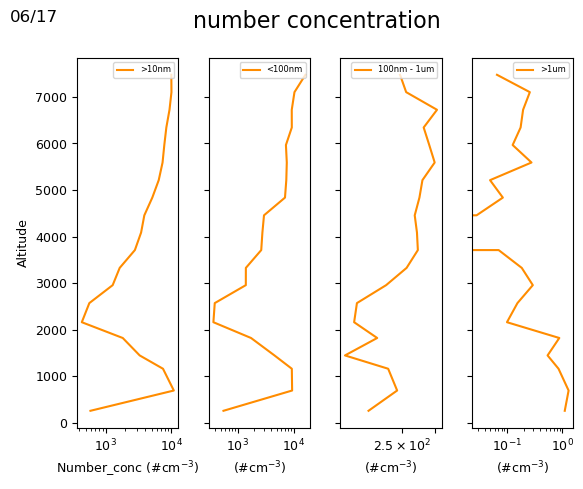

In [86]:
fig, ax = plt.subplots(1, 4, sharey='all')
plt.rcParams['font.size'] = '6'
ax[0].plot(DAY17_subset_mean['CNgt10nm_ZIEMBA'], DAY17_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label=">10nm")
ax[1].plot(DAY17_subset_mean['nSMPS_ZIEMBA'], DAY17_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label="<100nm")
ax[2].plot(DAY17_subset_mean['IntegN_100to1000nm_LAS_ZIEMBA'], DAY17_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label="100nm - 1um")
ax[3].plot(DAY17_subset_mean['IntegN_gt1000nm_LAS_ZIEMBA'], DAY17_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label='>1um')
ax[0].set_ylabel('Altitude')
ax[0].set_xlabel('Number_conc (#cm$^{-3}$)')
ax[1].set_xlabel('(#cm$^{-3}$)')
ax[2].set_xlabel('(#cm$^{-3}$)')
ax[3].set_xlabel('(#cm$^{-3}$)')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[3].set_xscale('log')
ax[0].legend(loc='upper right', fontsize=6)
ax[1].legend(loc='upper right', fontsize=6)
ax[2].legend(loc='upper right', fontsize=6)
ax[3].legend(loc='upper right', fontsize=6)

# Reduce the number of x-axis tickers to 2 for ax[2]
ax[2].xaxis.set_major_locator(ticker.MaxNLocator(nbins=2))
ax[2].xaxis.set_minor_locator(ticker.NullLocator())

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)



fig.text(0.02, 0.98, '06/17', ha='left', va='top', fontsize=12)

# Set the title
fig.suptitle('number concentration', fontsize=16)

plt.show()

Text(0.5, 0.98, 'Volume concentration')

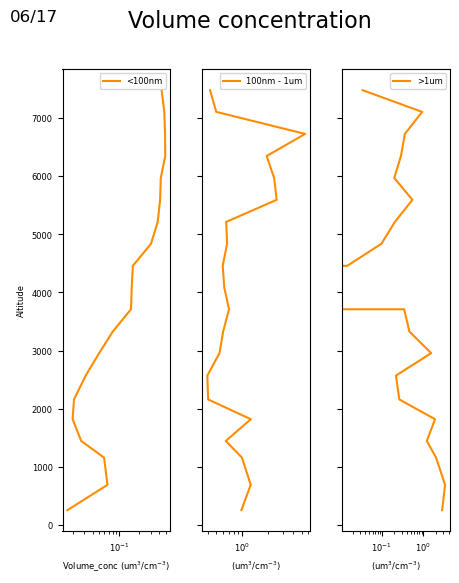

In [87]:
fig, ax = plt.subplots(1, 3, figsize=(5, 6), sharey='all')
plt.rcParams['font.size'] = '9'
ax[0].plot(DAY17_subset_mean['vSMPS_ZIEMBA'], DAY17_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label="<100nm")
ax[1].plot(DAY17_subset_mean['IntegV_100to1000nm_LAS_ZIEMBA'], DAY17_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label='100nm - 1um')
ax[2].plot(DAY17_subset_mean['IntegV_gt1000nm_LAS_ZIEMBA'], DAY17_subset_mean['GPS_Altitude_THORNHILL'], color="darkorange", label='>1um')
ax[0].set_ylabel('Altitude')
ax[0].set_xlabel('Volume_conc (um$^{3}$/cm$^{-3}$)')
ax[1].set_xlabel('(um$^{3}$/cm$^{-3}$)')
ax[2].set_xlabel('(um$^{3}$/cm$^{-3}$)')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[0].legend(loc='upper right', fontsize=6)
ax[1].legend(loc='upper right', fontsize=6)
ax[2].legend(loc='upper right', fontsize=6)
# Limit the number of tickers for the second plot
#ax[1].set_xlim([0, 2])
#ax[2].set_xlim([100, 300])
#ax[2].set_xlim([0, 3])
# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)
fig.text(0.02, 0.98, '06/17', ha='left', va='top', fontsize=12)
fig.suptitle('Volume concentration', fontsize=16)

In [88]:

# Concatenate the dataframes vertically (along rows)
ocean = pd.concat([DAY1000_subset_1000, DAY1000_subset_1000b], axis=0)

# Reset the index of the merged dataframe
ocean.reset_index(drop=True, inplace=True)
ocean.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
count,54,54,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,52.000000,52.000000,52.000000
mean,2022-06-02 15:57:34.006548480,2022-06-02 15:57:35.006548480,32.260783,-65.086951,539.226840,446.714991,344.576863,204.471725,195.487422,26.016921,1.145610,0.633267,5.493143,1.883006,182.611558,1.554607,0.017243
min,2022-06-02 13:54:46.487500032,2022-06-02 13:54:47.487500032,32.208589,-65.305158,121.847785,410.220769,318.374000,177.302500,156.948889,19.847778,0.788750,0.000000,0.000000,0.000000,112.170000,1.130000,0.010000
25%,2022-06-02 13:58:04.475000064,2022-06-02 13:58:05.475000064,32.245279,-65.170465,333.169000,424.224125,327.930238,191.453478,179.683109,23.360769,0.972010,0.454512,3.725000,1.041307,163.911039,1.382143,0.014135
50%,2022-06-02 13:58:43.794871808,2022-06-02 13:58:44.794871808,32.259518,-65.050124,542.367759,432.802582,332.831720,201.606028,197.016974,26.484877,1.178667,0.612372,5.445292,1.858899,182.022500,1.551250,0.020000
75%,2022-06-02 18:38:26.124999936,2022-06-02 18:38:27.124999936,32.279729,-65.013358,748.823929,445.266161,338.786950,205.915457,209.925549,28.606793,1.301027,0.834356,7.369308,2.617212,185.260000,1.700833,0.020000
max,2022-06-02 18:41:01.500000,2022-06-02 18:41:02.500000,32.302282,-64.962424,951.478333,624.135833,483.077692,276.733200,232.645000,31.949600,1.461111,1.251364,12.400909,4.915000,328.690000,2.664000,0.023000
std,NaN,NaN,0.022520,0.096509,245.995329,49.416567,39.169873,23.637848,18.745864,3.131747,0.178105,0.270299,2.863922,1.166749,41.388313,0.306095,0.004044


In [89]:
# Concatenate the dataframes vertically (along rows)
ocean2 = pd.concat([DAY3000_subset_3000, DAY3000_subset_3000b], axis=0)

# Reset the index of the merged dataframe
ocean2.reset_index(drop=True, inplace=True)
ocean2.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
count,136,136,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,124.000000,124.000000,124.000000
mean,2022-06-02 16:27:31.669278976,2022-06-02 16:27:32.669278976,32.280743,-65.038310,2074.413541,690.017821,482.418129,246.983503,134.876612,14.688784,0.608728,0.242980,2.322780,0.813944,414.962007,2.863532,0.030875
min,2022-06-02 13:50:07.969465600,2022-06-02 13:50:08.969465600,32.218661,-65.750983,1005.609375,428.075714,322.956250,80.988889,20.790000,1.985000,0.082000,0.000000,0.000000,0.000000,211.960000,1.270000,0.010000
25%,2022-06-02 14:05:01.409091072,2022-06-02 14:05:02.409091072,32.259912,-65.052320,1527.248239,488.035398,356.611339,178.718878,115.458885,10.342917,0.402500,0.063194,0.242250,0.040375,266.948029,1.930000,0.020000
50%,2022-06-02 18:41:27.249999872,2022-06-02 18:41:28.249999872,32.277253,-65.004105,2052.482500,618.259625,432.556220,211.071181,145.583750,16.475625,0.675909,0.211989,1.857298,0.524896,299.540000,2.171667,0.026515
75%,2022-06-02 18:47:16,2022-06-02 18:47:17,32.300794,-64.961800,2582.140000,716.015750,498.153437,299.481661,161.328988,19.227481,0.805926,0.375985,3.596562,1.278750,414.540000,3.670000,0.040000
max,2022-06-02 18:52:12,2022-06-02 18:52:13,32.365645,-64.908365,3434.677778,1835.130000,1224.591667,619.948889,271.472500,26.542500,1.219375,1.071250,10.837143,5.378571,1361.610000,7.210000,0.070000
std,NaN,NaN,0.031836,0.125763,651.241184,314.357759,197.878372,109.922378,52.867670,6.077751,0.266272,0.215338,2.308787,0.941577,298.750496,1.546524,0.015661


In [90]:
# Concatenate the dataframes vertically (along rows)
North_America = pd.concat([DAY1000_subset_7, DAY1000_subset_7b, DAY1000_subset_17], axis=0)

# Reset the index of the merged dataframe
North_America.reset_index(drop=True, inplace=True)
North_America.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
count,67,67,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,61.000000,61.000000,61.000000
mean,2022-06-09 07:55:27.363589120,2022-06-09 07:55:28.363588864,32.231992,-65.009280,548.337133,3342.426193,2447.563774,711.466078,392.642488,37.260516,1.680491,1.651132,14.576626,4.841469,2235.911297,9.041754,0.092459
min,2022-06-07 14:32:05.300000,2022-06-07 14:32:06.300000,32.170582,-65.065238,134.321500,602.159507,467.216690,149.376479,116.721690,15.433478,0.911905,0.769231,6.560769,1.719038,318.740000,1.430000,0.010000
25%,2022-06-07 14:35:12,2022-06-07 14:35:13,32.204178,-65.035459,340.337833,1420.201955,1060.818182,529.616309,247.860885,25.323027,1.251970,1.252071,10.456368,3.340200,717.780000,7.290000,0.070000
50%,2022-06-07 19:08:21.500000,2022-06-07 19:08:22.500000,32.234441,-65.004622,544.358929,1477.499200,1132.727273,807.207273,417.679000,35.749444,1.594000,1.597105,13.388636,4.310000,829.790000,8.370000,0.100000
75%,2022-06-07 19:11:12,2022-06-07 19:11:13,32.255360,-64.980962,761.335779,2844.465037,2112.402888,897.685182,547.105939,50.470606,2.173045,1.944500,17.871424,6.105392,1293.020000,10.260000,0.110000
max,2022-06-17 16:24:41.500000,2022-06-17 16:24:42.500000,32.302506,-64.968086,975.912308,22291.355000,16394.035000,1132.727222,588.128500,55.460500,2.480000,2.937273,27.720000,11.170500,16157.900000,28.800000,0.300000
std,NaN,NaN,0.036142,0.028948,245.678658,4897.569285,3485.850578,243.790035,157.031234,13.409353,0.474420,0.502029,5.173062,2.064954,3862.781613,4.226988,0.039567


In [111]:
# Concatenate the dataframes vertically (along rows)
North_America2 = pd.concat([DAY7_subset_3000, DAY7b_subset_3000, DAY17_subset_3000], axis=0)

# Reset the index of the merged dataframe
North_America2.reset_index(drop=True, inplace=True)
North_America2.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
count,171,171,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,60.000000,60.000000,60.000000
mean,2022-06-09 13:56:08.766082304,2022-06-09 13:56:09.766081792,32.233562,-65.015713,2106.253110,1616.569575,1164.789316,505.758133,178.956724,15.238779,0.587834,0.268465,2.344509,0.787882,1996.160193,6.407444,0.058165
min,2022-06-07 14:38:12,2022-06-07 14:38:13,32.162806,-65.062171,1003.411000,544.236111,393.318889,159.102778,7.702600,1.384800,0.049000,0.000000,0.000000,0.000000,297.530000,2.000000,0.020000
25%,2022-06-07 14:44:39.249999872,2022-06-07 14:44:40.249999872,32.210141,-65.045180,1545.078333,811.053944,589.383500,334.429350,95.870909,8.244006,0.274417,0.000000,0.000000,0.000000,363.730000,3.210000,0.030000
50%,2022-06-07 19:15:57.500000,2022-06-07 19:15:58.500000,32.236307,-65.016066,2079.076250,986.919000,715.916000,456.012000,147.137917,13.025000,0.448889,0.104000,0.453333,0.075556,521.280000,4.335000,0.040000
75%,2022-06-07 19:21:51.500000,2022-06-07 19:21:52.500000,32.253539,-64.988696,2612.969500,1168.305500,851.362417,569.767146,208.173164,17.094708,0.642639,0.260000,2.330932,0.848636,2339.910000,7.580000,0.080000
max,2022-06-17 16:38:08.500000,2022-06-17 16:38:09.500000,32.300554,-64.960247,3459.904000,16371.280000,12146.430000,2059.863333,694.090556,52.733889,2.417400,2.102500,20.829500,8.040000,16157.900000,28.800000,0.300000
std,NaN,NaN,0.034153,0.030088,664.456867,2273.723716,1674.761074,279.536900,120.477423,10.718637,0.482314,0.453782,4.197660,1.497275,2889.000087,5.973793,0.060492


In [92]:
# Concatenate the dataframes vertically (along rows)
Caribbean = pd.concat([DAY1000_subset_3, DAY1000_subset_8, DAY1000_subset_10, DAY1000_subset_10b, DAY1000_subset_11, DAY1000_subset_11b], axis=0)

# Reset the index of the merged dataframe
Caribbean.reset_index(drop=True, inplace=True)
Caribbean.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
count,123,123,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,112.000000,112.000000,112.000000
mean,2022-06-09 21:31:55.508952320,2022-06-09 21:31:56.508952064,32.144896,-65.350799,537.555141,637.583551,503.553507,264.261505,193.592783,27.997547,1.651712,2.149096,19.864806,6.795074,404.286562,3.065524,0.033288
min,2022-06-03 13:45:28.789007104,2022-06-03 13:45:29.789007104,31.035566,-67.436618,121.109551,340.870667,257.039118,117.781250,79.773059,15.543750,0.723750,0.000000,0.000000,0.000000,142.750000,1.503529,0.020000
25%,2022-06-08 20:33:55.500000,2022-06-08 20:33:56.500000,31.372011,-65.838736,332.799583,404.901250,324.696048,158.319616,146.166417,23.542652,1.223958,1.104167,9.232773,2.905907,196.459220,1.915965,0.020000
50%,2022-06-10 19:58:13.842105088,2022-06-10 19:58:14.842105088,32.243637,-65.035595,538.712500,522.167500,400.030000,220.088333,173.133889,26.667000,1.438333,1.950000,17.858636,6.060769,299.900000,3.078173,0.033536
75%,2022-06-11 15:28:22.249999872,2022-06-11 15:28:23.249999872,32.297915,-64.986404,745.678750,753.177500,626.655000,319.074958,235.436365,29.589240,1.894643,3.008699,29.222341,9.777049,483.480000,3.825694,0.040000
max,2022-06-11 20:10:12.500000,2022-06-11 20:10:13.500000,34.214933,-64.424176,961.682500,3477.824730,2527.575991,1608.476441,404.409395,103.477396,8.405069,5.520000,50.008889,18.781500,2681.927732,7.158845,0.074201
std,NaN,NaN,0.834868,0.817590,242.594382,404.807011,295.677638,184.881602,62.525356,10.671443,0.914205,1.257566,12.403149,4.563322,360.082012,1.248640,0.012396


In [93]:
# Concatenate the dataframes vertically (along rows)
Caribbean2 = pd.concat([DAY3_subset_3000, DAY8_subset_3000, DAY10_subset_3000, DAY10b_subset_3000, DAY11_subset_3000, DAY11b_subset_3000, DAY13_subset_3000, DAY1000_subset_13b], axis=0)

# Reset the index of the merged dataframe
Caribbean2.reset_index(drop=True, inplace=True)
Caribbean2.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
count,431,431,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,319.000000,319.000000,319.000000
mean,2022-06-10 11:56:14.973697280,2022-06-10 11:56:15.973697792,32.145916,-65.235505,2137.176787,909.588390,644.284235,339.521355,153.234985,17.808707,0.954402,1.048809,10.515237,3.793668,616.685193,3.584823,0.037109
min,2022-06-03 13:53:27.769230848,2022-06-03 13:53:28.769230592,31.036776,-67.516110,121.140833,186.882500,145.040000,34.792647,25.820625,2.466000,0.063000,0.000000,0.000000,0.000000,125.960000,1.050000,0.010000
25%,2022-06-08 20:43:57.750000128,2022-06-08 20:43:58.750000128,31.594612,-65.095014,1520.495568,512.697847,363.533702,162.542821,83.418542,8.191792,0.324250,0.104000,0.510000,0.110800,259.850000,2.348333,0.020000
50%,2022-06-10 20:09:28.380952320,2022-06-10 20:09:29.380952320,32.237935,-65.027415,2152.079803,676.885000,521.943750,302.658500,134.085000,13.135000,0.540000,0.319231,2.692353,0.861000,383.500000,2.968333,0.030000
75%,2022-06-11 20:17:06.958333440,2022-06-11 20:17:07.958333440,32.279986,-64.979378,2784.418750,912.166944,679.762708,444.573750,190.703882,23.050982,1.182728,0.849500,8.065757,2.730625,520.110000,4.270000,0.041488
max,2022-06-13 19:50:47,2022-06-13 19:50:48,34.194709,-64.393900,3448.995000,7850.188000,4317.614333,1823.766364,1849.998600,378.333800,26.887200,12.418200,106.906000,43.805000,7036.800000,18.571053,0.171316
std,NaN,NaN,0.684266,0.641941,769.502910,799.888346,501.646557,244.356316,130.530555,22.732202,1.635268,1.810733,18.886525,7.084107,985.627970,2.037702,0.021434


In [94]:
Africa = pd.concat([DAY1000_subset_13, DAY1000_subset_13b, DAY1000_subset_14])
# Reset the index of the merged dataframe
Africa.reset_index(drop=True, inplace=True)
Africa.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
count,48,48,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,45.000000,45.000000,45.000000
mean,2022-06-13 21:57:17.503670528,2022-06-13 21:57:18.503670784,31.918298,-64.885146,541.348157,317.712575,244.442210,112.188372,92.496180,13.121893,0.733393,0.971394,9.531067,3.400390,178.169830,1.542222,0.014889
min,2022-06-13 14:30:32.200000,2022-06-13 14:30:33.200000,30.635158,-65.097735,121.140833,186.882500,145.040000,34.792647,43.906176,5.681471,0.235294,0.085833,0.508750,0.085000,110.270000,0.800000,0.010000
25%,2022-06-13 14:33:19.249999872,2022-06-13 14:33:20.249999872,32.200276,-65.034858,335.132500,250.938811,193.200913,66.311116,66.875521,9.077380,0.445313,0.318868,2.983929,0.929118,133.410000,1.050000,0.010000
50%,2022-06-13 19:47:40.500000,2022-06-13 19:47:41.500000,32.235259,-64.988673,545.363575,281.330139,220.143808,98.162667,91.508417,12.911227,0.709470,0.802128,8.767044,3.076955,139.690000,1.350000,0.010000
75%,2022-06-13 19:50:19,2022-06-13 19:50:20,32.266888,-64.933701,747.631396,326.794432,251.012841,115.103872,105.349108,15.319423,0.899687,1.314750,12.916563,4.521667,201.680000,1.820000,0.020000
max,2022-06-14 16:07:10.500000,2022-06-14 16:07:11.500000,32.287260,-64.387230,954.156429,998.117500,779.118000,504.806500,185.431500,23.675000,1.626071,2.585417,27.415417,10.039167,459.850000,3.110000,0.030000
std,NaN,NaN,0.649748,0.245438,247.564084,137.318906,105.195202,80.407265,34.146094,4.827858,0.341899,0.753515,7.698344,2.906151,87.529812,0.720296,0.007575


In [95]:
North_America_transport = pd.concat([North_America, North_America2], axis=0)
North_America_transport.reset_index(drop=True, inplace=True)
North_America_transport
nbins = 10
bins = np.linspace(North_America_transport.GPS_Altitude_THORNHILL.min(), North_America_transport.GPS_Altitude_THORNHILL.max(), nbins+1)
North_America_transport['Bins'] = pd.cut(North_America_transport['GPS_Altitude_THORNHILL'], bins)
North_America_transport_plot = North_America_transport.groupby('Bins').mean()
North_America_transport_plot

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
Bins,,,,,,,,,,,,,,,,,
"(134.322, 466.88]",2022-06-09 13:02:08.557795584,2022-06-09 13:02:09.557795584,32.235685,-64.999388,308.924614,1485.596583,1146.440247,613.095562,361.747181,34.706069,1.571849,1.824072,16.221135,5.441332,1078.995735,6.852576,0.074231
"(466.88, 799.438]",2022-06-09 05:33:22.288461568,2022-06-09 05:33:23.288461568,32.233932,-65.012345,642.629880,4082.586240,2937.561314,734.441312,392.284155,37.698423,1.746034,1.659650,14.390746,4.669982,2548.406957,10.068696,0.102174
"(799.438, 1131.996]",2022-06-09 01:15:49.249999872,2022-06-09 01:15:50.250000128,32.236622,-65.027877,960.000996,6328.282966,4654.912585,984.475912,471.882894,41.595432,1.723753,1.309991,12.095626,4.168733,5226.392353,15.086471,0.144118
"(1131.996, 1464.554]",2022-06-09 11:28:39.232142848,2022-06-09 11:28:40.232142848,32.233448,-65.015428,1295.389357,2542.354913,1835.218319,629.210601,284.086420,25.544583,1.040094,0.628418,5.203161,1.697585,3448.663332,7.246531,0.063067
"(1464.554, 1797.113]",2022-06-09 05:39:29.461538560,2022-06-09 05:39:30.461538560,32.240680,-65.024770,1634.387595,1197.298986,862.911809,430.144003,177.580687,17.199229,0.701993,0.256897,2.257991,0.767534,981.062308,3.527692,0.030769
"(1797.113, 2129.671]",2022-06-09 13:12:15.500000000,2022-06-09 13:12:16.500000000,32.223923,-64.997531,1967.386595,825.581284,590.723961,307.895366,125.194468,12.227455,0.500622,0.129900,1.025423,0.331753,622.345250,3.477058,0.032308
"(2129.671, 2462.229]",2022-06-09 05:32:33.711538432,2022-06-09 05:32:34.711538432,32.222644,-65.021703,2299.311732,944.150950,671.234760,406.705717,109.213149,8.118942,0.266739,0.060770,0.523272,0.187128,352.065000,2.640000,0.025000
"(2462.229, 2794.788]",2022-06-09 05:44:10.096153856,2022-06-09 05:44:11.096153856,32.238182,-65.036803,2626.167004,1024.895437,728.697397,462.609240,101.467381,7.191355,0.230630,0.053091,0.356673,0.095864,585.135000,3.617500,0.035000
"(2794.788, 3127.346]",2022-06-11 02:26:42.600000000,2022-06-11 02:26:43.600000000,32.217425,-65.007035,2960.931075,1196.644142,836.683274,483.124928,146.591915,11.081722,0.406467,0.140242,1.487624,0.564618,1401.120000,6.220000,0.050000


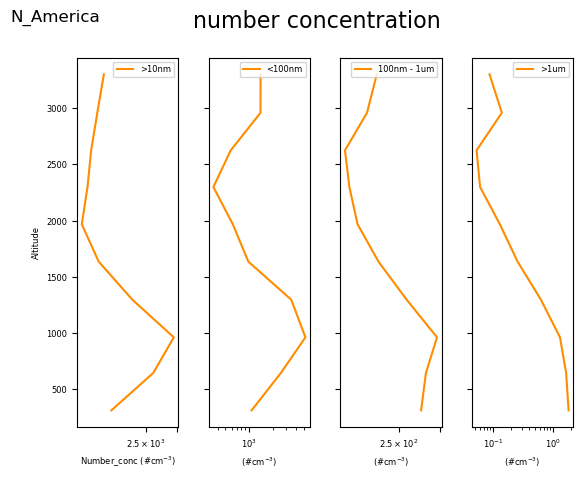

In [109]:
fig, ax = plt.subplots(1, 4, sharey='all')
plt.rcParams['font.size'] = '6'
ax[0].plot(North_America_transport_plot['CNgt10nm_ZIEMBA'], North_America_transport_plot['GPS_Altitude_THORNHILL'], color="darkorange", label=">10nm")
ax[1].plot(North_America_transport_plot['nSMPS_ZIEMBA'], North_America_transport_plot['GPS_Altitude_THORNHILL'], color="darkorange", label="<100nm")
ax[2].plot(North_America_transport_plot['IntegN_100to1000nm_LAS_ZIEMBA'], North_America_transport_plot['GPS_Altitude_THORNHILL'], color="darkorange", label="100nm - 1um")
ax[3].plot(North_America_transport_plot['IntegN_gt1000nm_LAS_ZIEMBA'], North_America_transport_plot['GPS_Altitude_THORNHILL'], color="darkorange", label='>1um')
ax[0].set_ylabel('Altitude')
ax[0].set_xlabel('Number_conc (#cm$^{-3}$)')
ax[1].set_xlabel('(#cm$^{-3}$)')
ax[2].set_xlabel('(#cm$^{-3}$)')
ax[3].set_xlabel('(#cm$^{-3}$)')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[3].set_xscale('log')
ax[0].legend(loc='upper right', fontsize=6)
ax[1].legend(loc='upper right', fontsize=6)
ax[2].legend(loc='upper right', fontsize=6)
ax[3].legend(loc='upper right', fontsize=6)
# Reduce the number of x-axis tickers to 2 for ax[2]
ax[0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=2))
ax[0].xaxis.set_minor_locator(ticker.NullLocator())
ax[2].xaxis.set_major_locator(ticker.MaxNLocator(nbins=2))
ax[2].xaxis.set_minor_locator(ticker.NullLocator())

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)



fig.text(0.02, 0.98, 'N_America', ha='left', va='top', fontsize=12)

# Set the title
fig.suptitle('number concentration', fontsize=16)

plt.show()

Text(0.5, 0.98, 'Volume concentration')

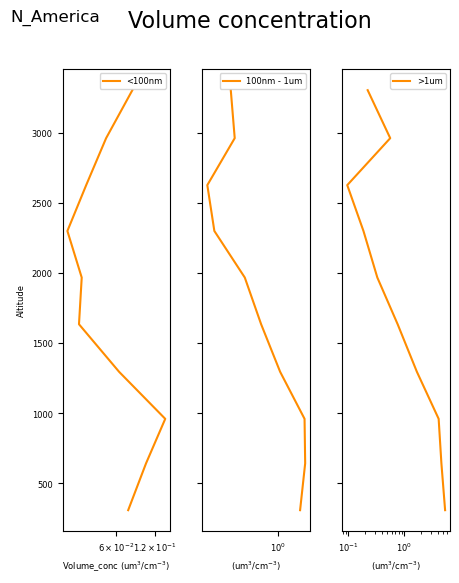

In [97]:
fig, ax = plt.subplots(1, 3, figsize=(5, 6), sharey='all')
plt.rcParams['font.size'] = '6'
ax[0].plot(North_America_transport_plot['vSMPS_ZIEMBA'], North_America_transport_plot['GPS_Altitude_THORNHILL'], color="darkorange", label="<100nm")
ax[1].plot(North_America_transport_plot['IntegV_100to1000nm_LAS_ZIEMBA'], North_America_transport_plot['GPS_Altitude_THORNHILL'], color="darkorange", label='100nm - 1um')
ax[2].plot(North_America_transport_plot['IntegV_gt1000nm_LAS_ZIEMBA'], North_America_transport_plot['GPS_Altitude_THORNHILL'], color="darkorange", label='>1um')
ax[0].set_ylabel('Altitude')
ax[0].set_xlabel('Volume_conc (um$^{3}$/cm$^{-3}$)')
ax[1].set_xlabel('(um$^{3}$/cm$^{-3}$)')
ax[2].set_xlabel('(um$^{3}$/cm$^{-3}$)')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[0].legend(loc='upper right', fontsize=6)
ax[1].legend(loc='upper right', fontsize=6)
ax[2].legend(loc='upper right', fontsize=6)
# Reduce the number of x-axis tickers to 2 for ax[0]
ax[0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=2))
ax[0].xaxis.set_minor_locator(ticker.NullLocator())
# Reduce the number of x-axis tickers to 2 for ax[1]
#ax[1].xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
ax[1].xaxis.set_minor_locator(ticker.NullLocator())
plt.subplots_adjust(wspace=0.3)
fig.text(0.02, 0.98, 'N_America', ha='left', va='top', fontsize=12)
fig.suptitle('Volume concentration', fontsize=16)

In [98]:
Caribbean_transport = pd.concat([Caribbean, Caribbean2], axis=0)
Caribbean_transport.reset_index(drop=True, inplace=True)
nbins = 10
bins = np.linspace(Caribbean_transport.GPS_Altitude_THORNHILL.min(), Caribbean_transport.GPS_Altitude_THORNHILL.max(), nbins+1)
Caribbean_transport['Bins'] = pd.cut(Caribbean_transport['GPS_Altitude_THORNHILL'], bins)
Caribbean_transport_plot = Caribbean_transport.groupby('Bins').mean()
Caribbean_transport_plot

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
Bins,,,,,,,,,,,,,,,,,
"(121.11, 453.898]",2022-06-10 08:15:30.052565760,2022-06-10 08:15:31.052565760,32.191856,-65.313912,291.786754,481.123584,389.830309,194.448897,176.534742,25.289785,1.428448,1.907652,17.564802,6.003802,270.411555,2.464450,0.026633
"(453.898, 786.687]",2022-06-10 08:30:17.298771456,2022-06-10 08:30:18.298771712,32.160400,-65.325908,622.232260,612.491308,481.574235,249.216629,164.562025,23.049421,1.343964,1.788994,17.244652,6.005295,408.045867,2.843394,0.030479
"(786.687, 1119.475]",2022-06-10 09:04:27.546124032,2022-06-10 09:04:28.546124032,32.173842,-65.317143,946.773407,751.387002,577.273582,318.957299,194.960356,30.104678,1.914946,2.341023,20.980376,7.089048,439.246565,3.328079,0.035674
"(1119.475, 1452.264]",2022-06-10 10:28:56.329047808,2022-06-10 10:28:57.329047808,32.141455,-65.283488,1289.891052,687.698200,527.404437,314.723003,185.753515,25.462409,1.509459,2.290793,23.729239,8.663233,455.148991,3.851444,0.040006
"(1452.264, 1785.052]",2022-06-10 07:41:02.820278016,2022-06-10 07:41:03.820277760,32.190103,-65.301808,1622.972449,642.669654,489.059451,311.866599,175.812285,21.678820,1.214921,1.733864,18.080193,6.620025,354.216217,3.415636,0.037628
"(1785.052, 2117.841]",2022-06-10 09:25:12.416479232,2022-06-10 09:25:13.416479488,32.156321,-65.276586,1948.988665,748.153684,554.408689,341.465841,163.834621,20.586747,1.197179,1.669653,17.740840,6.662613,388.706880,3.588033,0.039449
"(2117.841, 2450.629]",2022-06-10 10:03:42.093322496,2022-06-10 10:03:43.093322752,32.121154,-65.230782,2286.766603,747.415167,533.240024,313.998887,150.484623,14.930278,0.650700,0.376849,3.116658,0.980485,451.498627,3.831738,0.041320
"(2450.629, 2783.418]",2022-06-10 08:33:24.509021696,2022-06-10 08:33:25.509021696,32.093921,-65.206337,2622.173256,719.005967,506.476986,274.318630,119.464823,11.560475,0.492935,0.260757,2.476252,0.857507,513.606112,2.551002,0.026741
"(2783.418, 3116.206]",2022-06-10 09:21:11.269108992,2022-06-10 09:21:12.269108992,32.093062,-65.140272,2951.706673,1002.567954,676.876149,315.776991,102.785581,9.363775,0.410992,0.188470,1.702445,0.591400,868.789277,3.862111,0.036475


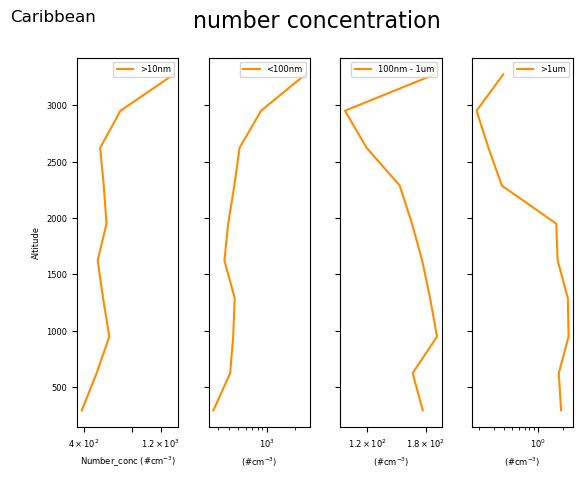

In [99]:
fig, ax = plt.subplots(1, 4, sharey='all')
plt.rcParams['font.size'] = '6'
ax[0].plot(Caribbean_transport_plot['CNgt10nm_ZIEMBA'], Caribbean_transport_plot['GPS_Altitude_THORNHILL'], color="darkorange", label=">10nm")
ax[1].plot(Caribbean_transport_plot['nSMPS_ZIEMBA'], Caribbean_transport_plot['GPS_Altitude_THORNHILL'], color="darkorange", label="<100nm")
ax[2].plot(Caribbean_transport_plot['IntegN_100to1000nm_LAS_ZIEMBA'], Caribbean_transport_plot['GPS_Altitude_THORNHILL'], color="darkorange", label="100nm - 1um")
ax[3].plot(Caribbean_transport_plot['IntegN_gt1000nm_LAS_ZIEMBA'], Caribbean_transport_plot['GPS_Altitude_THORNHILL'], color="darkorange", label='>1um')
ax[0].set_ylabel('Altitude')
ax[0].set_xlabel('Number_conc (#cm$^{-3}$)')
ax[1].set_xlabel('(#cm$^{-3}$)')
ax[2].set_xlabel('(#cm$^{-3}$)')
ax[3].set_xlabel('(#cm$^{-3}$)')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[3].set_xscale('log')
ax[0].legend(loc='upper right', fontsize=6)
ax[1].legend(loc='upper right', fontsize=6)
ax[2].legend(loc='upper right', fontsize=6)
ax[3].legend(loc='upper right', fontsize=6)
# Reduce the number of x-axis tickers to 2 for ax[2]
ax[0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
ax[0].xaxis.set_minor_locator(ticker.NullLocator())
ax[2].xaxis.set_major_locator(ticker.MaxNLocator(nbins=2))
ax[2].xaxis.set_minor_locator(ticker.NullLocator())

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)



fig.text(0.02, 0.98, 'Caribbean', ha='left', va='top', fontsize=12)

# Set the title
fig.suptitle('number concentration', fontsize=16)

plt.show()

Text(0.5, 0.98, 'Volume concentration')

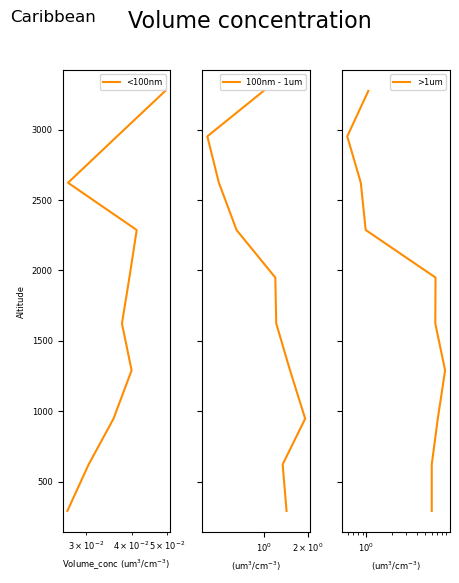

In [100]:
fig, ax = plt.subplots(1, 3, figsize=(5, 6), sharey='all')
plt.rcParams['font.size'] = '6'
ax[0].plot(Caribbean_transport_plot['vSMPS_ZIEMBA'], Caribbean_transport_plot['GPS_Altitude_THORNHILL'], color="darkorange", label="<100nm")
ax[1].plot(Caribbean_transport_plot['IntegV_100to1000nm_LAS_ZIEMBA'], Caribbean_transport_plot['GPS_Altitude_THORNHILL'], color="darkorange", label='100nm - 1um')
ax[2].plot(Caribbean_transport_plot['IntegV_gt1000nm_LAS_ZIEMBA'], Caribbean_transport_plot['GPS_Altitude_THORNHILL'], color="darkorange", label='>1um')
ax[0].set_ylabel('Altitude')
ax[0].set_xlabel('Volume_conc (um$^{3}$/cm$^{-3}$)')
ax[1].set_xlabel('(um$^{3}$/cm$^{-3}$)')
ax[2].set_xlabel('(um$^{3}$/cm$^{-3}$)')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[0].legend(loc='upper right', fontsize=6)
ax[1].legend(loc='upper right', fontsize=6)
ax[2].legend(loc='upper right', fontsize=6)
# Reduce the number of x-axis tickers to 2 for ax[1]
ax[1].xaxis.set_major_locator(ticker.MaxNLocator(nbins=2))
ax[1].xaxis.set_minor_locator(ticker.NullLocator())
# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)
fig.text(0.02, 0.98, 'Caribbean', ha='left', va='top', fontsize=12)
fig.suptitle('Volume concentration', fontsize=16)

In [101]:
ocean_transport = pd.concat([ocean, ocean2], axis=0)
ocean_transport.reset_index(drop=True, inplace=True)
ocean_transport
nbins = 10
bins = np.linspace(ocean_transport.GPS_Altitude_THORNHILL.min(), ocean_transport.GPS_Altitude_THORNHILL.max(), nbins+1)
ocean_transport['Bins'] = pd.cut(ocean_transport['GPS_Altitude_THORNHILL'], bins)
ocean_transport_plot = ocean_transport.groupby('Bins').mean()
ocean_transport_plot

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
Bins,,,,,,,,,,,,,,,,,
"(121.848, 453.131]",2022-06-02 15:57:31.055699968,2022-06-02 15:57:32.055699968,32.249258,-65.060651,296.931069,467.929730,364.312640,218.401554,200.555603,27.297755,1.225684,0.698828,5.604299,1.789143,197.434654,1.644007,0.017266
"(453.131, 784.414]",2022-06-02 16:04:38.332896000,2022-06-02 16:04:39.332896256,32.278078,-65.100031,617.356923,434.434445,332.496792,198.518664,198.445269,26.107216,1.129984,0.684883,6.095181,2.143023,163.766829,1.414267,0.015333
"(784.414, 1115.697]",2022-06-02 16:05:36.944226304,2022-06-02 16:05:37.944226304,32.263959,-65.089102,942.856853,436.558835,332.925139,190.264273,175.416168,22.773028,1.000915,0.401214,4.177298,1.538399,203.158908,1.705542,0.020000
"(1115.697, 1446.98]",2022-06-02 16:01:12.666964224,2022-06-02 16:01:13.666964224,32.287938,-65.078211,1280.417202,454.813205,339.674582,183.092839,148.612559,18.512102,0.806468,0.376302,3.283564,1.082409,271.409495,1.980102,0.022500
"(1446.98, 1778.263]",2022-06-02 16:01:58.177345024,2022-06-02 16:01:59.177345024,32.274061,-65.097221,1607.945840,502.608062,368.093385,202.205953,142.835715,17.110533,0.735912,0.410995,4.260926,1.604279,261.104176,2.047666,0.023757
"(1778.263, 2109.546]",2022-06-02 16:03:38.672211200,2022-06-02 16:03:39.672211200,32.302976,-65.081504,1936.178949,674.536956,473.942999,317.136786,179.158245,18.422243,0.732050,0.317164,3.096529,1.091534,367.139978,3.565513,0.041355
"(2109.546, 2440.829]",2022-06-02 16:14:45.090909184,2022-06-02 16:14:46.090909184,32.276720,-65.024779,2272.100005,686.672395,473.603783,260.800430,138.657720,13.707291,0.533677,0.121344,0.890081,0.275779,428.767368,2.884211,0.030000
"(2440.829, 2772.112]",2022-06-02 16:09:02.619047680,2022-06-02 16:09:03.619047680,32.246802,-64.961837,2607.371214,659.601467,456.176380,242.812757,109.936586,11.285052,0.472921,0.135812,1.366692,0.469162,359.092222,2.333333,0.024444
"(2772.112, 3103.395]",2022-06-02 17:40:30.291666688,2022-06-02 17:40:31.291666688,32.312592,-64.966409,2904.782931,900.977692,617.764384,214.871514,70.919741,7.022845,0.275905,0.082075,0.722181,0.241920,458.686364,2.633636,0.027273


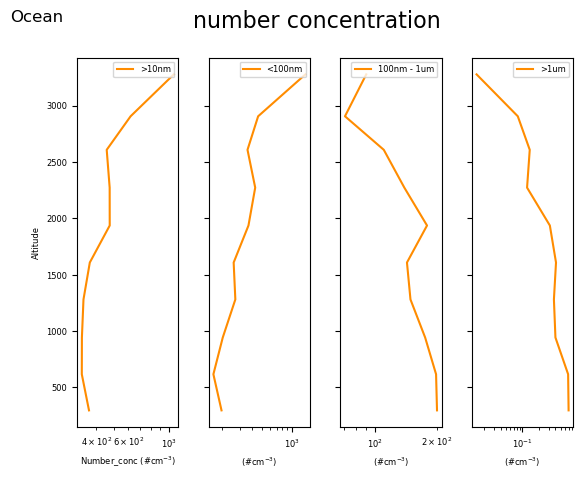

In [102]:
fig, ax = plt.subplots(1, 4, sharey='all')
plt.rcParams['font.size'] = '6'
ax[0].plot(ocean_transport_plot['CNgt10nm_ZIEMBA'], ocean_transport_plot['GPS_Altitude_THORNHILL'], color="darkorange", label=">10nm")
ax[1].plot(ocean_transport_plot['nSMPS_ZIEMBA'], ocean_transport_plot['GPS_Altitude_THORNHILL'], color="darkorange", label="<100nm")
ax[2].plot(ocean_transport_plot['IntegN_100to1000nm_LAS_ZIEMBA'], ocean_transport_plot['GPS_Altitude_THORNHILL'], color="darkorange", label="100nm - 1um")
ax[3].plot(ocean_transport_plot['IntegN_gt1000nm_LAS_ZIEMBA'], ocean_transport_plot['GPS_Altitude_THORNHILL'], color="darkorange", label='>1um')
ax[0].set_ylabel('Altitude')
ax[0].set_xlabel('Number_conc (#cm$^{-3}$)')
ax[1].set_xlabel('(#cm$^{-3}$)')
ax[2].set_xlabel('(#cm$^{-3}$)')
ax[3].set_xlabel('(#cm$^{-3}$)')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[3].set_xscale('log')
ax[0].legend(loc='upper right', fontsize=6)
ax[1].legend(loc='upper right', fontsize=6)
ax[2].legend(loc='upper right', fontsize=6)
ax[3].legend(loc='upper right', fontsize=6)
# Reduce the number of x-axis tickers to 2 for ax[2]
#ax[0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=2))
#ax[0].xaxis.set_minor_locator(ticker.NullLocator())

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)



fig.text(0.02, 0.98, 'Ocean', ha='left', va='top', fontsize=12)

# Set the title
fig.suptitle('number concentration', fontsize=16)

plt.show()

Text(0.5, 0.98, 'Volume concentration')

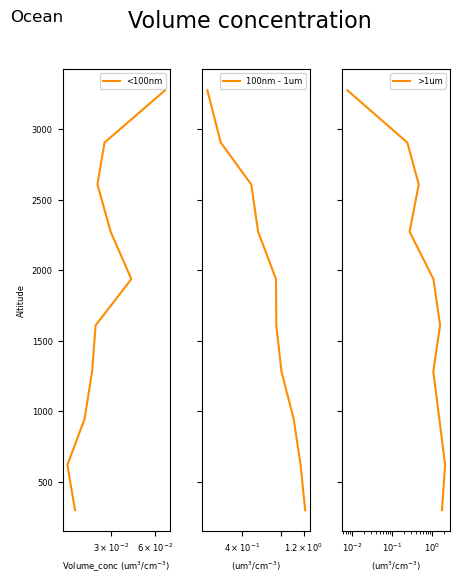

In [103]:
fig, ax = plt.subplots(1, 3, figsize=(5, 6), sharey='all')
plt.rcParams['font.size'] = '6'
ax[0].plot(ocean_transport_plot['vSMPS_ZIEMBA'], ocean_transport_plot['GPS_Altitude_THORNHILL'], color="darkorange", label="<100nm")
ax[1].plot(ocean_transport_plot['IntegV_100to1000nm_LAS_ZIEMBA'], ocean_transport_plot['GPS_Altitude_THORNHILL'], color="darkorange", label='100nm - 1um')
ax[2].plot(ocean_transport_plot['IntegV_gt1000nm_LAS_ZIEMBA'], ocean_transport_plot['GPS_Altitude_THORNHILL'], color="darkorange", label='>1um')
ax[0].set_ylabel('Altitude')
ax[0].set_xlabel('Volume_conc (um$^{3}$/cm$^{-3}$)')
ax[1].set_xlabel('(um$^{3}$/cm$^{-3}$)')
ax[2].set_xlabel('(um$^{3}$/cm$^{-3}$)')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[0].legend(loc='upper right', fontsize=6)
ax[1].legend(loc='upper right', fontsize=6)
ax[2].legend(loc='upper right', fontsize=6)
# Reduce the number of x-axis tickers to 2 for ax[]
ax[0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=2))
ax[0].xaxis.set_minor_locator(ticker.NullLocator())
ax[1].xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
ax[1].xaxis.set_minor_locator(ticker.NullLocator())
# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)
fig.text(0.02, 0.98, 'Ocean', ha='left', va='top', fontsize=12)
fig.suptitle('Volume concentration', fontsize=16)

In [104]:
Africa_transport = pd.concat([Africa, DAY14_subset_3000], axis=0)
Africa_transport.reset_index(drop=True, inplace=True)
nbins = 10
bins = np.linspace(Africa_transport.GPS_Altitude_THORNHILL.min(), Africa_transport.GPS_Altitude_THORNHILL.max(), nbins+1)
Africa_transport['Bins'] = pd.cut(Africa_transport['GPS_Altitude_THORNHILL'], bins)
Africa_transport_plot = Africa_transport.groupby('Bins').mean()
Africa_transport_plot

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CNgt3nm_ZIEMBA,CNgt10nm_ZIEMBA,CNgt10nm_nonvol_ZIEMBA,IntegN_100to1000nm_LAS_ZIEMBA,IntegS_100to1000nm_LAS_ZIEMBA,IntegV_100to1000nm_LAS_ZIEMBA,IntegN_gt1000nm_LAS_ZIEMBA,IntegS_gt1000nm_LAS_ZIEMBA,IntegV_gt1000nm_LAS_ZIEMBA,nSMPS_ZIEMBA,sSMPS_ZIEMBA,vSMPS_ZIEMBA
Bins,,,,,,,,,,,,,,,,,
"(121.141, 442.87]",2022-06-13 22:15:21.900000000,2022-06-13 22:15:22.900000000,31.899818,-64.858323,293.886773,303.115882,236.070125,109.914919,86.597554,12.227632,0.627860,0.580363,5.488776,1.919735,192.814256,1.531765,0.013529
"(442.87, 764.599]",2022-06-13 22:16:42.277777920,2022-06-13 22:16:43.277777920,31.907996,-64.900447,613.039744,307.806678,235.684003,107.426178,89.905388,12.102241,0.649486,0.844202,8.580541,3.058272,161.935882,1.448824,0.014706
"(764.599, 1086.328]",2022-06-13 22:42:49.416666880,2022-06-13 22:42:50.416666624,31.829494,-64.852175,884.663618,359.939223,273.059448,125.212107,105.981791,16.609004,1.111226,1.983396,20.638197,7.712774,178.458182,1.662727,0.017273
"(1086.328, 1408.057]",2022-06-14 16:07:48.666666752,2022-06-14 16:07:49.666666496,30.641470,-64.404228,1246.981444,309.362537,232.561759,113.050222,83.811148,16.119278,1.334870,2.524259,25.854296,8.922981,110.270000,0.800000,0.010000
"(1408.057, 1729.786]",2022-06-14 16:08:22.249999872,2022-06-14 16:08:23.249999872,30.656191,-64.432512,1539.005417,330.870958,243.282042,112.559236,76.946319,18.055528,1.699847,3.433486,35.308875,13.063125,154.050000,0.950000,0.010000
"(1729.786, 2051.515]",2022-06-14 16:09:00.750000128,2022-06-14 16:09:01.750000128,30.688544,-64.415486,1873.197944,352.985792,245.357417,94.305542,60.409542,13.724208,1.240750,2.209611,23.437556,8.966931,174.175000,0.910000,0.010000
"(2051.515, 2373.244]",2022-06-14 16:09:38.875000064,2022-06-14 16:09:39.875000064,30.677510,-64.375355,2207.540278,404.875264,287.158097,66.066583,30.660764,4.552833,0.345639,0.668889,8.039403,3.167667,194.300000,0.870000,0.010000
"(2373.244, 2694.973]",2022-06-14 16:10:18.249999872,2022-06-14 16:10:19.249999872,30.643522,-64.384657,2541.211023,360.844620,248.299530,73.745184,33.605217,5.072077,0.396730,0.769528,7.422933,2.440451,474.800000,1.340000,0.010000
"(2694.973, 3016.702]",2022-06-14 16:10:59.500000000,2022-06-14 16:11:00.500000000,30.655523,-64.424406,2877.968333,469.505660,323.009896,72.828854,20.886944,2.016563,0.105000,0.048750,0.192292,0.036667,367.035000,1.350000,0.010000


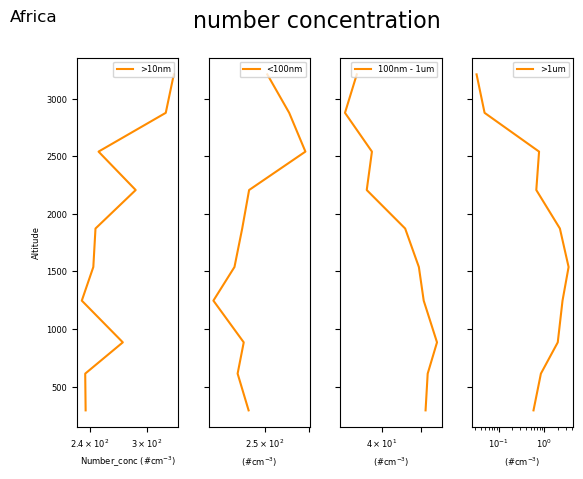

In [110]:
fig, ax = plt.subplots(1, 4, sharey='all')
plt.rcParams['font.size'] = '6'
ax[0].plot(Africa_transport_plot['CNgt10nm_ZIEMBA'], Africa_transport_plot['GPS_Altitude_THORNHILL'], color="darkorange", label=">10nm")
ax[1].plot(Africa_transport_plot['nSMPS_ZIEMBA'], Africa_transport_plot['GPS_Altitude_THORNHILL'], color="darkorange", label="<100nm")
ax[2].plot(Africa_transport_plot['IntegN_100to1000nm_LAS_ZIEMBA'], Africa_transport_plot['GPS_Altitude_THORNHILL'], color="darkorange", label="100nm - 1um")
ax[3].plot(Africa_transport_plot['IntegN_gt1000nm_LAS_ZIEMBA'], Africa_transport_plot['GPS_Altitude_THORNHILL'], color="darkorange", label='>1um')
ax[0].set_ylabel('Altitude')
ax[0].set_xlabel('Number_conc (#cm$^{-3}$)')
ax[1].set_xlabel('(#cm$^{-3}$)')
ax[2].set_xlabel('(#cm$^{-3}$)')
ax[3].set_xlabel('(#cm$^{-3}$)')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[3].set_xscale('log')
ax[0].legend(loc='upper right', fontsize=6)
ax[1].legend(loc='upper right', fontsize=6)
ax[2].legend(loc='upper right', fontsize=6)
ax[3].legend(loc='upper right', fontsize=6)
# Reduce the number of x-axis tickers to 2 for ax[2]
ax[0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=2))
ax[0].xaxis.set_minor_locator(ticker.NullLocator())
ax[1].xaxis.set_major_locator(ticker.MaxNLocator(nbins=2))
ax[1].xaxis.set_minor_locator(ticker.NullLocator())
ax[2].xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
ax[2].xaxis.set_minor_locator(ticker.NullLocator())
# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)



fig.text(0.02, 0.98, 'Africa', ha='left', va='top', fontsize=12)

# Set the title
fig.suptitle('number concentration', fontsize=16)

plt.show()

Text(0.5, 0.98, 'Volume_concentration')

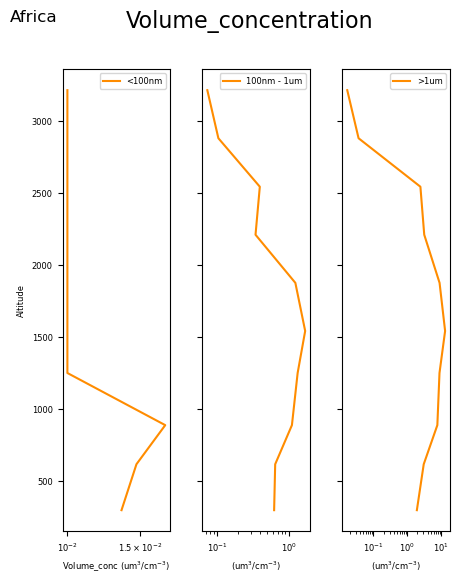

In [106]:
fig, ax = plt.subplots(1, 3, figsize=(5, 6), sharey='all')
plt.rcParams['font.size'] = '6'
ax[0].plot(Africa_transport_plot['vSMPS_ZIEMBA'], Africa_transport_plot['GPS_Altitude_THORNHILL'], color="darkorange", label="<100nm")
ax[1].plot(Africa_transport_plot['IntegV_100to1000nm_LAS_ZIEMBA'], Africa_transport_plot['GPS_Altitude_THORNHILL'], color="darkorange", label='100nm - 1um')
ax[2].plot(Africa_transport_plot['IntegV_gt1000nm_LAS_ZIEMBA'], Africa_transport_plot['GPS_Altitude_THORNHILL'], color="darkorange", label='>1um')
ax[0].set_ylabel('Altitude')
ax[0].set_xlabel('Volume_conc (um$^{3}$/cm$^{-3}$)')
ax[1].set_xlabel('(um$^{3}$/cm$^{-3}$)')
ax[2].set_xlabel('(um$^{3}$/cm$^{-3}$)')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[0].legend(loc='upper right', fontsize=6)
ax[1].legend(loc='upper right', fontsize=6)
ax[2].legend(loc='upper right', fontsize=6)
## Reduce the number of x-axis tickers to 2 for ax[2]
ax[0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=2))
ax[0].xaxis.set_minor_locator(ticker.NullLocator())
# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)
fig.text(0.02, 0.98, 'Africa', ha='left', va='top', fontsize=12)
fig.suptitle('Volume_concentration', fontsize=16)

In [107]:
# Concatenate the dataframes vertically (along rows)
'''merged_df = pd.concat([Caribbean.describe(), Caribbean2.describe(), North_America.describe(), North_America2.describe(), ocean.describe(), ocean2.describe(), Africa.describe(), DAY14_subset_3000.describe()], axis=0)

# Reset the index of the merged dataframe
merged_df.reset_index(drop=False, inplace=True)

# Display the merged dataframe
merged_df
merged_df.to_csv('C:/Users/taiwoajayi/OneDrive - University of Arizona/python/size_description.csv')'''

"merged_df = pd.concat([Caribbean.describe(), Caribbean2.describe(), North_America.describe(), North_America2.describe(), ocean.describe(), ocean2.describe(), Africa.describe(), DAY14_subset_3000.describe()], axis=0)\n\n# Reset the index of the merged dataframe\nmerged_df.reset_index(drop=False, inplace=True)\n\n# Display the merged dataframe\nmerged_df\nmerged_df.to_csv('C:/Users/taiwoajayi/OneDrive - University of Arizona/python/size_description.csv')"